In [1]:
import pandas as pd
import numpy as np
from glob import glob
from path import Path
import json
import seaborn as sns
import prody
from multiprocessing import Pool
from tqdm import tqdm
import itertools
import json
from rdkit import Chem
from rdkit.Chem import AllChem
from io import StringIO
from collections import OrderedDict, Counter
import traceback
import urllib
import pybel
from copy import deepcopy
from multiprocessing import Pool
from pymol import cmd

pd.set_option('display.max_columns', None)

from pocketdock.ligand.ligand_expo import LigandExpo
from pocketdock import utils
from pocketdock import pdb_tools

RDKit WARNING: [16:06:40] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
import logging
import logging.config

LOGGING = {
    'version': 1,
    'disable_existing_loggers': True,
    'formatters': {
        'default': {
            'format': '[%(levelname)s] %(asctime)s %(funcName)s [pid %(process)d] - %(message)s'
        }
    },
    'handlers': {
        'console': {
            'class': 'logging.StreamHandler',
            'formatter': 'default',
        }
    },
    'loggers': {
        'console': {
            'handlers': ['console'],
            'level': 'DEBUG',
            'propagate': False,
        }
    }
}

logging.config.dictConfig(LOGGING)
logger = logging.getLogger('console')


def get_file_handler(filename, mode='w', level='DEBUG'):
    h = logging.FileHandler(filename, mode=mode)
    h.setFormatter(logging.Formatter('[%(levelname)s] %(asctime)s %(funcName)s [pid %(process)d] - %(message)s'))
    h.setLevel(level)
    return h

In [3]:
CHAIN_INTERACTION_DIST = 6
MIN_POCKET_SIZE = 10
MAX_RESOLUTION = 4.0
LIGAND_GROUP_DIST = 5
MIN_LIGAND_TO_SYMMATES = 6
BSITE_SIM_RADIUS = 6
LIGAND_DOMAIN_CONTACT_RADIUS = 6
MAX_NUM_CHAINS = 20
COVALENT_LIGAND_DISTANCE = 1.8
FRAC_HEAVY_ATOMS_RESOLVED = 0.9
HOMO_SEARCH_MIN_COVERAGE = 0.4

In [4]:
def _build_d2mat(crd1, crd2):
    return np.sum((crd1[:, None, :] - crd2[None, :, :])**2, axis=2)
            
def _calc_overlap(lig_ag, ref_ag, dist):
    dmat = prody.buildDistMatrix(lig_ag.heavy, ref_ag.heavy)
    return np.any(dmat <= dist, axis=1).sum().item() / lig_ag.heavy.numAtoms()

def _aln_to_mapping(aln1, aln2):
    assert len(aln1) == len(aln2)
    i = 0
    j = 0
    mapping = []
    for a, b in zip(aln1, aln2):
        if a != '-' and b != '-':
            mapping.append((i, j))
        if a != '-':
            i += 1
        if b != '-':
            j += 1
    return mapping

def _get_affinity(pdb_id, chemid):
    try:
        url = 'https://data.rcsb.org/rest/v1/core/entry/' + pdb_id.lower()
        with urllib.request.urlopen(url) as f:
            affs = json.loads(f.read().decode())
    except urllib.error.HTTPError as e:
        print('HTTPError for', url)
        affs = {}
        
    for x in affs.get('rcsb_binding_affinity', []):
        if x['comp_id'] == chemid:
            return x
    return None

def calc_identity(aln1, aln2):
    return sum([x == y for x, y in zip(aln1, aln2)]) / len(aln1.replace('-', ''))

In [5]:
#get_cases_for_pdb('1QUR')

In [6]:
three2one = {'SER': 'S', 'LYS': 'K', 'PRO': 'P', 'ALA': 'A', 'ASP': 'D', 'ARG': 'R', 'VAL': 'V', 'CYS': 'C', 'HIS': 'H',
         'ASX': 'B', 'PHE': 'F', 'MET': 'M', 'LEU': 'L', 'ASN': 'N', 'TYR': 'Y', 'ILE': 'I', 'GLN': 'Q', 'THR': 'T',
         'GLX': 'Z', 'GLY': 'G', 'TRP': 'W', 'GLU': 'E'}

residue_bonds_noh = {
    'GLY': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C')},
    'ALA': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'), 'CB': ('CA',)},
    'CYS': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'SG'), 'SG': ('CB',)},
    'SER': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'OG'), 'OG': ('CB',)},
    'MET': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'SD'), 'SD': ('CG', 'CE'), 'CE': ('SD',)},
    'LYS': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD'), 'CD': ('CG', 'CE'), 'CE': ('CD', 'NZ'), 'NZ': ('CE',)},
    'ARG': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD'), 'CD': ('CG', 'NE'), 'NE': ('CD', 'CZ'), 'CZ': ('NE', 'NH1', 'NH2'),
            'NH1': ('CZ',), 'NH2': ('CZ',)},
    'GLU': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD'), 'CD': ('CG', 'OE1', 'OE2'), 'OE1': ('CD',), 'OE2': ('CD',)},
    'GLN': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD'), 'CD': ('CG', 'OE1', 'NE2'), 'OE1': ('CD',), 'NE2': ('CD',)},
    'ASP': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'OD1', 'OD2'), 'OD1': ('CG',), 'OD2': ('CG',)},
    'ASN': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'OD1', 'ND2'), 'OD1': ('CG',), 'ND2': ('CG',)},
    'LEU': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD1', 'CD2'), 'CD1': ('CG',), 'CD2': ('CG',)},
    'HIS': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'ND1', 'CD2'), 'ND1': ('CG', 'CE1'), 'CD2': ('CG', 'NE2'),
            'CE1': ('ND1', 'NE2'), 'NE2': ('CD2', 'CE1')},
    'PHE': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD1', 'CD2'), 'CD1': ('CG', 'CE1'), 'CD2': ('CG', 'CE2'),
            'CE1': ('CD1', 'CZ'), 'CE2': ('CD2', 'CZ'), 'CZ': ('CE1', 'CE2')},
    'TYR': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD1', 'CD2'), 'CD1': ('CG', 'CE1'), 'CD2': ('CG', 'CE2'),
            'CE1': ('CD1', 'CZ'), 'CE2': ('CD2', 'CZ'), 'CZ': ('CE1', 'CE2', 'OH'), 'OH': ('CZ',)},
    'TRP': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD1', 'CD2'), 'CD1': ('CG', 'NE1'), 'CD2': ('CG', 'CE2', 'CE3'),
            'NE1': ('CD1', 'CE2'), 'CE2': ('CD2', 'NE1', 'CZ2'), 'CE3': ('CD2', 'CZ3'), 'CZ3': ('CE3', 'CH2'),
            'CZ2': ('CE2', 'CH2'), 'CH2': ('CZ2', 'CZ3')},
    'VAL': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG1', 'CG2'), 'CG1': ('CB',), 'CG2': ('CB',)},
    'THR': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'OG1', 'CG2'), 'OG1': ('CB',), 'CG2': ('CB',)},
    'ILE': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA',), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG1', 'CG2'), 'CG1': ('CB', 'CD1'), 'CD1': ('CG1',), 'CG2': ('CB',)},
    'PRO': {'OXT': ('C',), 'C': ('CA', 'O', 'OXT'), 'O': ('C',), 'N': ('CA', 'CD'), 'CA': ('N', 'C', 'CB'),
            'CB': ('CA', 'CG'), 'CG': ('CB', 'CD'), 'CD': ('N', 'CG')},
}


def fetch_AF_model(uniprot_id):
    url = f'https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v1.pdb'
    with urllib.request.urlopen(url) as f:
        data = f.read().decode()
    return prody.parsePDBStream(StringIO(data))


def _find_closest_residue(resid_list, target, upstream=True):
    if not upstream:
        resid_list = reversed(resid_list)
    for resid in resid_list:
        if upstream and target <= resid:
            return resid
        if not upstream and target >= resid:
            return resid
    return None


def fetch_domains(instance_data, entity_to_pdb, pdb_residues, entity_len):
    data = instance_data['rcsb_polymer_instance_feature']
    cath_data = [x for x in data if x['type'] == 'CATH']
    entity_nums = sorted(entity_to_pdb.keys())
    
    domains = []
    for dom_id, dom_data in enumerate(cath_data):
        domain = OrderedDict(
            domain_id=dom_id,
            manually_filled=False,
            domain_chunks=[]
        )
        for chunk_data in dom_data['feature_positions']:
            # zero based position in the entity sequence
            chunk_ent_orig = [int(chunk_data['beg_seq_id'])-1, int(chunk_data['end_seq_id'])-1]
            # zero based position mapped to the closest residue with coordinates
            chunk_ent_map = [
                _find_closest_residue(entity_nums, chunk_ent_orig[0], True), 
                _find_closest_residue(entity_nums, chunk_ent_orig[1], False)
            ]
            # discard region if None
            if chunk_ent_map[0] is None or chunk_ent_map[1] is None:
                continue
            # pdb residue ids
            chunk_pdb = [
                pdb_residues[entity_to_pdb[chunk_ent_map[0]]].getResnum().item() if chunk_ent_map[0] is not None else None,
                pdb_residues[entity_to_pdb[chunk_ent_map[1]]].getResnum().item() if chunk_ent_map[1] is not None else None
            ]
            domain['domain_chunks'].append(
                OrderedDict(
                    chunk_ent_orig=chunk_ent_orig,
                    chunk_ent_map=chunk_ent_map,
                    chunk_pdb_resid=chunk_pdb
                )
            )
        if len(domain['domain_chunks']) == 0:
            continue
        domains.append(domain)
        
    #assert len(domains) > 0, domains
    
    # if there is no domains identified, fill them manually - whole structure
    if len(domains) == 0:
        chunk_ent_orig = [0, entity_len-1]
        chunk_ent_map = [
            _find_closest_residue(entity_nums, chunk_ent_orig[0], True), 
            _find_closest_residue(entity_nums, chunk_ent_orig[1], False)
        ]
        chunk_pdb = [
            pdb_residues[entity_to_pdb[chunk_ent_map[0]]].getResnum().item(),
            pdb_residues[entity_to_pdb[chunk_ent_map[1]]].getResnum().item()
        ]
        domains = [OrderedDict(
            domain_id=0,
            manually_filled=True,
            domain_chunks=[
                OrderedDict(
                    chunk_ent_orig=chunk_ent_orig,
                    chunk_ent_map=chunk_ent_map,
                    chunk_pdb_resid=chunk_pdb
                )
            ]
        )]
        
    return domains


def find_correct_instance(pdb_id, target_chain, chain_list):
    for cid in chain_list:
        url = f'https://data.rcsb.org/rest/v1/core/polymer_entity_instance/{pdb_id}/{cid}'
        with urllib.request.urlopen(url) as f:
            instance_data = json.loads(f.read().decode())   
        if instance_data['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id'] == target_chain:
            break
    
    if instance_data['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id'] != target_chain:
        return None
    
    return instance_data


def process_pdb_chain(outdir, pdb_id, chain):
    pdb_id = pdb_id.upper()
    outdir = Path(outdir).mkdir_p()
    ag, header = pdb_tools.get_atom_group(pdb_id, header=True)
    
    url = f'https://data.rcsb.org/rest/v1/core/entry/{pdb_id}'
    with urllib.request.urlopen(url) as f:
        entry_data = json.loads(f.read().decode())
    
    url = f'https://data.rcsb.org/rest/v1/core/polymer_entity_instance/{pdb_id}/{chain}'
    with urllib.request.urlopen(url) as f:
        instance_data = json.loads(f.read().decode())
    
    # yes, instance id can be different from the chain name, 
    # so we have to loop though all instances (chains) until 
    # we find the correct one
    buf = instance_data['rcsb_polymer_entity_instance_container_identifiers']
    if buf['asym_id'] != buf['auth_asym_id']:
        instance_data = find_correct_instance(pdb_id, chain, set(ag.getChids()))
    if instance_data is None:
        raise RuntimeError('Cannot find correct RESTful link for {pdb_id}/{chain}. RCSB and Author\'s namings are different')
    
    entity_id = instance_data['rcsb_polymer_entity_instance_container_identifiers']['entity_id']
    
    url = f'https://data.rcsb.org/rest/v1/core/polymer_entity/{pdb_id}/{entity_id}'
    with urllib.request.urlopen(url) as f:
        entity_data = json.loads(f.read().decode())
    assert chain in entity_data['entity_poly']['pdbx_strand_id'].split(',')
        
    url = f'https://data.rcsb.org/rest/v1/core/uniprot/{pdb_id}/{entity_id}'
    with urllib.request.urlopen(url) as f:
        uniprot_data = json.loads(f.read().decode())
        
    # ensure there is no non-standard linkage and aas
    assert entity_data['entity_poly']['nstd_linkage'] == 'no'
    assert entity_data['entity_poly']['nstd_monomer'] == 'no'
    assert entity_data['entity_poly']['rcsb_non_std_monomer_count'] == 0
    
    # align residues that have coordinates in the pdb to the 
    # sequence announced in the entity description and ID
    # the missing residues as well as partially resolved residues
    entity_seq = entity_data['entity_poly']['pdbx_seq_one_letter_code']
    
    # double check for nstd residues
    assert '(' not in entity_seq
    
    ag_chain = ag.select(f'chain {chain} and (stdaa or nonstdaa)').copy()
    residues = list(ag_chain.getHierView().iterResidues())
    pdb_seq = ''.join([three2one[x.getResname()] for x in residues])
    #print(entity_data['entity_poly'])
    #print(entity_seq)
    #print(pdb_seq)
    entity_aln, pdb_aln = utils.global_align(entity_seq, pdb_seq)[0][:2]
    
    # sanity check
    assert calc_identity(pdb_aln, entity_aln) > 0.90, 'Entity sequence doesn\'t match the chain'
    
    entity_to_pdb = dict(_aln_to_mapping(entity_aln, pdb_aln))
    missing_residue = []
    missing_ca = []
    missing_atoms = []
    for ent_i, ent_res in enumerate(entity_seq):
        if ent_i not in entity_to_pdb:
            missing_residue.append(True)
            missing_ca.append(True)
            missing_atoms.append(True)
            continue
        missing_residue.append(False)
        res = residues[entity_to_pdb[ent_i]]
        res_ideal_names = set(residue_bonds_noh[res.getResname()].keys())
        res_ideal_names.discard('OXT')
        res_cur_names = set(res.heavy.getNames())
        res_cur_names.discard('OXT')
        missing_ca.append('CA' not in res_cur_names)
        missing_atoms.append(res_ideal_names != res_cur_names)
        
    # write full pdb
    prody.writePDB(outdir / f'{pdb_id}.pdb', ag)
        
    # ag_chain
    prody.writePDB(outdir / 'rec_orig.pdb', ag_chain)
        
    # download alphafold model
    uniprot_id = uniprot_data[0]['rcsb_id']
    ag_af = fetch_AF_model(uniprot_id)
    prody.writePDB(outdir / 'AF_orig.pdb', ag_af)
    
    # align AF to crystal
    ag_af_aln, rmsd, (af_seq_aln, pdb_seq_aln) = pdb_tools.align(ag_af, ag_chain)
    rmsd = rmsd[0]
    prody.writePDB(outdir / 'AF_aln.pdb', ag_af_aln)
    
    AF_residues = list(ag_af.getHierView().iterResidues())
    AF_seq = ''.join([three2one[x.getResname()] for x in AF_residues])
    
    # domain data
    domains = fetch_domains(instance_data, entity_to_pdb, residues, len(entity_seq))
    
    entity_info = entity_data['entity_poly'].copy()
    entity_info['entity_aln'] = entity_aln
    entity_info['pdb_aln'] = pdb_aln
    #print(entity_aln)
    #print(pdb_aln)
    
    rec_dict = OrderedDict(
        case_name=pdb_id + '_' + chain,
        pdb_id=pdb_id,
        pdb_chain=chain,
        instance_id=instance_data['rcsb_polymer_entity_instance_container_identifiers']['asym_id'],
        entity_id=entity_id,
        experiment=header.get('experiment'), #entry_data['exptl']['method'],
        resolution=header.get('resolution'), #entry_data['exptl']['method'],
        deposition_date=entry_data['rcsb_accession_info']['deposit_date'],
        
        seqclus100=pdb_tools.CHAIN_TO_CLUSTER[100][pdb_id + '_' + chain],
        seqclus90=pdb_tools.CHAIN_TO_CLUSTER[90][pdb_id + '_' + chain],
        seqclus40=pdb_tools.CHAIN_TO_CLUSTER[40][pdb_id + '_' + chain],
        seqclus30=pdb_tools.CHAIN_TO_CLUSTER[30][pdb_id + '_' + chain],
        
        missing_residue=''.join([str(int(x)) for x in missing_residue]),
        missing_ca=''.join([str(int(x)) for x in missing_ca]),
        missing_atoms=''.join([str(int(x)) for x in missing_atoms]),
        
        entity_info=entity_info,
        
        uniprot=OrderedDict(
            uniprot_id=uniprot_id,
            uniprot_seq=uniprot_data[0]['rcsb_uniprot_protein']['sequence'],
            uniprot_name=uniprot_data[0]['rcsb_uniprot_protein']['name']['value'],
        ),
        
        domains=domains,
        
        alphafold=OrderedDict(
            seq=AF_seq,
            PDB_CA_RMSD=rmsd,
            AF_seq_aln=af_seq_aln,
            PDB_seq_aln=pdb_seq_aln,
            PDB_AF_identity=calc_identity(pdb_seq_aln, af_seq_aln),
            AF_confidence=ag_af.calpha.getBetas().tolist()
        )
    )
    return rec_dict

In [7]:
def _add_hs(out_mol, in_mol):
    # add hydrogens
    mol = next(pybel.readfile('mol', in_mol))
    mol.addh()
    mol.localopt('mmff94', steps=500)
    mol.write('mol', out_mol, overwrite=True)

    # fix back the coordinates
    mol = Chem.MolFromMolFile(out_mol, removeHs=False)
    ag = utils.mol_to_ag(mol)
    ref_ag = utils.mol_to_ag(Chem.MolFromMolFile(in_mol, removeHs=True))
    tr = prody.calcTransformation(ag.heavy, ref_ag.heavy)
    ag = tr.apply(ag)
    prody.writePDB(Path(out_mol).stripext() + '.pdb', ag)

    utils.change_mol_coords(mol, ag.getCoords())
    AllChem.ComputeGasteigerCharges(mol, throwOnParamFailure=False)
    Chem.MolToMolFile(mol, out_mol)


def _calc_rmsd(crd1, crd2):
    return np.square(crd1 - crd2).sum(1).mean().item()


def _bsite_similarity(mol_ag, mob_ag, ref_ag, mob_aln, ref_aln):
    ref_to_mob = dict(_aln_to_mapping(ref_aln, mob_aln))
    mob_residues = list(mob_ag.copy().getHierView().iterResidues())
    ref_residues = list(ref_ag.copy().getHierView().iterResidues())

    assert len(mob_residues) == len(mob_aln.replace('-', ''))
    assert len(ref_residues) == len(ref_aln.replace('-', ''))
    
    pocket = ref_ag.select(f'exwithin {BSITE_SIM_RADIUS} of sel', sel=mol_ag)
    pocket_resnums = set(pocket.getResnums())
    pocket_ref_residues = []
    pocket_mob_residues = []
    for i, x in enumerate(ref_residues):
        if x.getResnum() in pocket_resnums:
            pocket_ref_residues.append(x)
            mob_id = ref_to_mob.get(i, None)
            pocket_mob_residues.append(None if mob_id is None else mob_residues[mob_id])
    
    pocket_rmsd = None
    if not all([x is None for x in pocket_mob_residues]):
        pocket_rmsd = _calc_rmsd(
            np.stack([x['CA'].getCoords() for i, x in enumerate(pocket_ref_residues) if pocket_mob_residues[i] is not None]),
            np.stack([x['CA'].getCoords() for x in pocket_mob_residues if x is not None])
        )
    pocket_identity = sum([y is not None and x.getResname() == y.getResname() 
                           for x, y in zip(pocket_ref_residues, pocket_mob_residues)]) / len(pocket_ref_residues)
    return OrderedDict(
        nresidues=len(pocket_ref_residues),
        rmsd_ca=pocket_rmsd,
        identity=pocket_identity,
        resnums_pdb=[x.getResnum().item() for x in pocket_ref_residues],
        resnums_af=[x.getResnum().item() if x is not None else None for x in pocket_mob_residues],
        seq_pdb=''.join([x['CA'].getSequence() for x in pocket_ref_residues]),
        seq_af=''.join([x['CA'].getSequence() if x is not None else '-' for x in pocket_mob_residues])
    )
    

def process_ligand_group(case_dir, case_dict, group_dict):
    case_dir = Path(case_dir)
    group_dir = case_dir / group_dict['name'] 
    
    # add hs
    for item in group_dict['ligands']:
        _add_hs(group_dir / item['sdf_id'] + '_ah.mol', group_dir / item['sdf_id'] + '.mol')
    
    # make ligand group ag
    mols = [(x['sdf_id'], utils.mol_to_ag(Chem.MolFromMolFile(group_dir / x['sdf_id'] + '.mol'))) for x in group_dict['ligands']]
    combined_ag = mols[0][1].copy()
    for _, mol in mols[1:]:
        combined_ag += mol.copy()
        
    # define domains in contact
    pdb_ag = prody.parsePDB(case_dir / 'rec_orig.pdb')
    domains = case_dict['domains']
    bsite_ag = pdb_ag.select(f'exwithin {LIGAND_DOMAIN_CONTACT_RADIUS} of lig', lig=combined_ag).copy()
    interacting_domains = []
    for dom in domains:
        for chunk in dom['domain_chunks']:
            a, b = chunk['chunk_pdb_resid']
            if bsite_ag.select(f"resnum `{a} to {b}`") is not None:
                interacting_domains.append(dom['domain_id'])
                break
    
    #print(domains)
    #print(interacting_domains)
                
    # select domains in pdb
    resnums = []
    for dom_id in interacting_domains:
        dom = domains[dom_id]
        for chunk in dom['domain_chunks']:
            a, b = chunk['chunk_pdb_resid']
            resnums.append((a, b))
    #print('PD', ' or '.join([f'(resnum {a} to {b})' for a, b in resnums]))
    domains_pdb_ag = pdb_ag.select(' or '.join([f"(resnum `{a} to {b}`)" for a, b in resnums])).copy()
    prody.writePDB(group_dir / 'domains_crys.pdb', domains_pdb_ag)
    pdb_resnums = resnums
    
    # select domains in AF
    # align AF sequence to the entity sequence and select domain regions
    af_ag = prody.parsePDB(case_dir / 'AF_orig.pdb')
    entity_seq = case_dict['entity_info']['pdbx_seq_one_letter_code']
    af_residues = list(af_ag.getHierView().iterResidues())
    af_seq = ''.join([three2one[x.getResname()] for x in af_residues]) #case_dict['alphafold']['seq']
    entity_aln, af_aln = utils.global_align(entity_seq, af_seq)[0][:2]
    ent_to_af_map = dict(_aln_to_mapping(entity_aln, af_aln))
    ent_resids = list(ent_to_af_map.keys())
    #print(entity_aln)
    #print(af_aln)
    #print(ent_to_af_map)
    #print(ent_resids)
    #print('af_residues', len(af_residues))
    #print('af_seq', len(af_seq))
    resnums = []
    for dom_id in interacting_domains:
        dom = domains[dom_id]
        #print(dom)
        for chunk in dom['domain_chunks']:
            a, b = chunk['chunk_ent_orig']
            #print(a, b)
            #print(ent_to_af_map[_find_closest_residue(ent_resids, a, True)], 
            #      ent_to_af_map[_find_closest_residue(ent_resids, b, False)])
            a = af_residues[ent_to_af_map[_find_closest_residue(ent_resids, a, True)]].getResnum().item()
            b = af_residues[ent_to_af_map[_find_closest_residue(ent_resids, b, False)]].getResnum().item()
            resnums.append((a, b))
    #print('AF', ' or '.join([f'(resnum {a} to {b})' for a, b in resnums]))
    domains_af_ag = af_ag.select(' or '.join([f"(resnum `{a} to {b}`)" for a, b in resnums])).copy()
    prody.writePDB(group_dir / 'domains_AF.pdb', domains_af_ag)
    af_resnums = resnums
    
    # align AF domain to PDB domain
    domains_af_ag_aln, rmsd, (af_aln, pdb_aln) = pdb_tools.align(domains_af_ag, domains_pdb_ag)
    rmsd = rmsd[0]
    prody.writePDB(group_dir / 'domains_AF_aln.pdb', domains_af_ag_aln)
    
    domain_aligment = OrderedDict(
        interacting_domains=interacting_domains,
        pdb_resi_ranges=pdb_resnums,
        af_resi_ranges=af_resnums,
        af_aln=af_aln,
        pdb_aln=pdb_aln,
        pdb_af_identity=calc_identity(pdb_aln, af_aln),
        rmsd_aln=rmsd
    )
    
    bsite_analysis = _bsite_similarity(combined_ag, domains_af_ag_aln, domains_pdb_ag, af_aln, pdb_aln)
    return domain_aligment, bsite_analysis
    
    
#process_ligand_group('data/3WKE_A', case_dict, case_dict['ligand_groups'][0])
    

In [8]:
#get_cases_for_pdb('6bg0')

In [9]:
def get_chain(chemid, mol_rd, pdb_ag):
    mol_ag = utils.mol_to_ag(mol_rd)
    not_lig = pdb_ag.select('not resname ' + chemid).copy()
    
    pocket_all = not_lig.select(f'(not water) exwithin {CHAIN_INTERACTION_DIST} of sel', sel=mol_ag)
    assert pocket_all is not None
    assert len(pocket_all) > MIN_POCKET_SIZE
    
    dmat_min = np.sqrt(_build_d2mat(pocket_all.getCoords(), mol_ag.getCoords())).min()
    #print(dmat_min)
    assert dmat_min > COVALENT_LIGAND_DISTANCE, f'{dmat_min} <= {COVALENT_LIGAND_DISTANCE}'
    
    # exclude hetero because ligands in the same group can be in different chains
    # and count toward "counts"
    pocket = pocket_all.select('not hetero')
    assert pocket is not None
    
    counts = Counter(pocket.getChids())
    chain = sorted(counts.items(), key=lambda x: -x[1])[0][0]
    assert (counts[chain] / len(pocket)) > 0.8
    return chain


def assert_one_chemid_copy_per_chain(chemid, pdb_ag):
    for chain_ag in pdb_ag.getHierView().iterChains():
        chain_ag = chain_ag.protein
        if chain_ag is None:
            continue
        lig = pdb_ag.select(f'resname {chemid} within 6 of sel', sel=chain_ag)
        if lig is not None:
            assert len(set(lig.getResnums())) == 1
            

def get_crystall_lattice(pdb, cutoff=6):
    pdb_file = pdb_tools.pdb_file_path(pdb)
    cmd.reinitialize()
    cmd.load(pdb_file, 'orig')
    cmd.symexp('symm', 'orig', 'orig', cutoff)
    tmp_file = utils.tmp_file(prefix='alphadock-', suffix='.pdb')
    cmd.save(tmp_file, 'symm*')
    symm_ag = prody.parsePDB(tmp_file)
    Path(tmp_file).remove_p()
    cmd.delete('all')
    return symm_ag


#get_crystall_lattice('4ow1')


def get_cases_for_pdb(pdb_id):
    pdb_id = pdb_id.upper()
    wdir = Path('data/cases').mkdir_p().mkdir_p()
    
    try:
        db_result = pdb_tools.get_atom_group(pdb_id, header=True)
        assert db_result is not None
        pdb_ag, header = db_result
        assert header.get('resolution', MAX_RESOLUTION + 10) <= MAX_RESOLUTION
        # avoid crazy large pdb files like ribosomes
        num_chains = len(set(pdb_ag.getChids()))
        assert num_chains <= MAX_NUM_CHAINS, f'{num_chains} > {MAX_NUM_CHAINS}'
    except AssertionError as e:
        logger.warning(f'{pdb_id} does not pass the criteria')
        logger.exception(e)
        return []
    
    chemids = LigandExpo.get_chemids_list(pdb_id)
    
    # find groups of ligands. here we treat groups of proximal ligands as 
    # whole instead of discarding them. such cases will represent cooperative binding
    mol_sdf_ids = []
    mol_rds = {}
    mol_rd_coords = {}
    for chemid in chemids:
        sdf_ids = LigandExpo.get_all_sdf_ids(pdb_id, chemid)
        for sdf_id in sdf_ids:
            mol_rd = LigandExpo.get_all_sdf_mol(sdf_id)
            if mol_rd is not None:
                mol_rds[sdf_id] = mol_rd
                mol_rd_coords[sdf_id] = mol_rd.GetConformer(0).GetPositions()
                mol_sdf_ids.append(sdf_id)
            else:
                logger.warning(f'Cannot read {sdf_id}')
    
    mol_groups = []
    for sdf_a in mol_sdf_ids:
        crd_a = mol_rd_coords[sdf_a]
        found = None
        for mol_group in mol_groups:
            for sdf_b in mol_group:
                crd_b = mol_rd_coords[sdf_b]
                d2mat = np.sum((crd_a[:, None, :] - crd_b[None, :, :])**2, axis=2)
                if np.any(d2mat < LIGAND_GROUP_DIST**2):
                    found = mol_group
                    break
            if found is not None:
                break
        if found is not None:
            found.append(sdf_a)
        else:
            mol_groups.append([sdf_a])
            
    #print(mol_groups)
            
    # build symmetry mates
    symm_mates_ag = get_crystall_lattice(pdb_id)
    
    # for each sdf_id
    detailed_groups = []
    for mol_group in mol_groups:
        detailed_group = []
        # if at least one ligand in the group is bad, we skip the whole group
        try:
            for sdf_id in mol_group:
                mol_rd = mol_rds[sdf_id]
                #assert mol_rd is not None
                
                chemid = sdf_id.split('_')[1]
                assert_one_chemid_copy_per_chain(chemid, pdb_ag)
                
                # check smiles and that all heavy atoms are present
                smi = LigandExpo.get_smiles(chemid)
                assert smi is not None
                
                mol_smi = Chem.MolFromSmiles(smi)
                nheavy = mol_smi.GetNumHeavyAtoms()
                assert nheavy > 0
                frac_resolved = nheavy / mol_rd.GetNumHeavyAtoms()
                assert frac_resolved >= FRAC_HEAVY_ATOMS_RESOLVED, f'{nheavy} < {mol_rd.GetNumHeavyAtoms()}, ({smi})'
                
                # check that ligand interacts with a single chain
                pdb_chain = get_chain(chemid, mol_rd, pdb_ag)
                
                # check that there is no symm mates interaction
                mol_ag = utils.mol_to_ag(mol_rd)
                if symm_mates_ag is not None:
                    assert mol_ag.select(f'within {MIN_LIGAND_TO_SYMMATES} of symmmates', symmmates=symm_mates_ag) is None, \
                    'Ligand interacts with symmetry mates'
                
                case = OrderedDict(
                    sdf_id=sdf_id, 
                    chemid=chemid,
                    smiles=smi,
                    pdb_id=pdb_id,
                    pdb_chain=pdb_chain,
                    num_heavy_atoms=mol_rd.GetNumHeavyAtoms(),
                    frac_resolved=frac_resolved,
                    affinity=_get_affinity(pdb_id, chemid)
                )
                detailed_group.append(case)
                
            # check that all chains in the group are the same
            inter_chains = set([x['pdb_chain'] for x in detailed_group])
            assert len(inter_chains) == 1, f'Multiple interacting chains: {inter_chains}'
            
        except AssertionError as e:
            logger.info(f'Dropping group {mol_group}')
            logger.exception(e)
            continue
            
        detailed_groups.append(detailed_group)
        
    if len(detailed_groups) == 0:
        logger.error('Groups are empty')
        return []
        
    # select unique (chain, chemids) groups
    unique_groups = []
    _desc_list = []
    for group in detailed_groups:
        seqclus100 = pdb_tools.CHAIN_TO_CLUSTER[100].get(pdb_id + '_' + group[0]['pdb_chain'])
        if seqclus100 is None:
            continue
        _desc = [seqclus100]
        _desc += sorted([x['chemid'] for x in group])
        _desc = tuple(_desc)
        if _desc in _desc_list:
            continue
        _desc_list.append(_desc)
        unique_groups.append(group)
        
    # prepare dict with chains
    chains_dict = OrderedDict()
    chains_list = sorted(set([x[0]['pdb_chain'] for x in unique_groups]))
    for chain in chains_list:
        try:
            chain_name = pdb_id + '_' + chain
            chains_dict[chain_name] = process_pdb_chain(wdir / chain_name, pdb_id, chain)
            chains_dict[chain_name]['ligand_groups'] = []
        except Exception as e:
            (wdir / chain_name).rmtree_p()
            logger.warning(f'Cannot process {chain_name}, skipping')
            #traceback.print_exc()
            #logger.exception(e)
    
    # process ligand groups
    for group in unique_groups:
        try:
            chain_name = pdb_id + '_' + group[0]['pdb_chain']
            chain_dict = chains_dict.get(chain_name)
            if chain_dict is None:
                continue

            group_name = '_'.join(sorted([x['chemid'] for x in group]))
            group_dir = (wdir / chain_name / group_name).mkdir_p()
            group_dict = OrderedDict(
                name=group_name,
                ligands=group
            )

            for lig_dict in group:
                Chem.MolToMolFile(mol_rds[lig_dict['sdf_id']], group_dir / lig_dict['sdf_id'] + '.mol')

            domain_aligment, bsite_analysis = process_ligand_group(wdir / chain_name, chain_dict, group_dict)
            group_dict['domain_aligment'] = domain_aligment
            group_dict['bsite_analysis'] = bsite_analysis
            chain_dict['ligand_groups'].append(group_dict)
        except Exception as e:
            logger.warning(f'Cannot process {group_name}, skipping')
            logger.exception(e)
        
    cases = []
    for case in chains_dict.values():
        # if all ligand groups were discarded skip this chain
        if len(case['ligand_groups']) == 0:
            (wdir / case['case_name']).rmtree_p()
            continue
        utils.write_json(case, wdir / case['case_name'] / 'case.json')
        cases.append(case)
        
    return cases

In [10]:
#case_dicts = get_cases_for_pdb('3wke')

In [11]:
#case_dicts[0]

In [12]:
#set(['a',24]) in [set([24,'a'])]

In [24]:
#LigandExpo._PDB_TO_CC #.keys()
logger.handlers

[<StreamHandler stderr (NOTSET)>]

In [ ]:
try:
    old_h = logger.handlers
    logger.handlers = [get_file_handler(Path('data') / 'log.txt', mode='a')]
    logger.info(f'============ Starting ===========')
    for i, pdb in tqdm(list(enumerate(LigandExpo._PDB_TO_CC.keys()))[:]):
        logger.info(f'============ Processing {pdb} [{i}] ===========')
        get_cases_for_pdb(pdb)
        logger.info(f'============== Finished {pdb} =================\n\n')
except Exception as e:
    logger.exception(e)
    raise
finally:
    logger.handlers[0].close()
    logger.handlers = old_h

  0%|          | 210/57369 [05:30<22:41:23,  1.43s/it] RDKit ERROR: [19:33:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [19:33:12] Explicit valence for atom # 39 N, 4, is greater than permitted
  0%|          | 237/57369 [06:20<44:01:06,  2.77s/it]RDKit ERROR: [19:34:02] Explicit valence for atom # 36 O, 3, is greater than permitted
RDKit ERROR: [19:34:02] Explicit valence for atom # 36 O, 3, is greater than permitted
  1%|          | 478/57369 [16:12<51:16:27,  3.24s/it] RDKit ERROR: [19:43:53] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [19:43:53] Explicit valence for atom # 39 N, 4, is greater than permitted
  1%|          | 615/57369 [21:14<35:49:12,  2.27s/it]RDKit ERROR: [19:48:57] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [19:48:57] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [19:48:57] Explicit valence for atom # 39 N, 4, is greater than permitted

Symmetry-Error: Unrecognized space group symbol 'P 21 21 2 A'.


  1%|▏         | 760/57369 [25:51<29:07:59,  1.85s/it]RDKit ERROR: [19:53:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [19:53:33] Explicit valence for atom # 39 N, 4, is greater than permitted
  1%|▏         | 761/57369 [25:54<36:26:35,  2.32s/it]RDKit ERROR: [19:53:36] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [19:53:36] Explicit valence for atom # 39 N, 4, is greater than permitted
  1%|▏         | 762/57369 [25:57<38:58:56,  2.48s/it]RDKit ERROR: [19:53:39] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [19:53:39] Explicit valence for atom # 39 N, 4, is greater than permitted
  2%|▏         | 910/57369 [31:12<36:03:18,  2.30s/it]RDKit ERROR: [19:58:54] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [19:58:54] Explicit valence for atom # 16 N, 4, is greater than permitted
  2%|▏         | 911/57369 [31:14<33:56:03,  2.16s/it]RDKit ERROR: [19:58:55] Explicit v

  3%|▎         | 1545/57369 [57:40<21:52:33,  1.41s/it] RDKit WARNING: [20:25:22] Element 'X' not found
RDKit WARNING: [20:25:22] Element 'X' not found
RDKit WARNING: [20:25:22] Element 'X' not found
RDKit WARNING: [20:25:22] Element 'X' not found
  3%|▎         | 1577/57369 [59:04<28:03:58,  1.81s/it] RDKit ERROR: [20:25:22] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [20:25:22] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [20:25:22] 
RDKit ERR

  3%|▎         | 2004/57369 [1:21:47<36:11:44,  2.35s/it]RDKit ERROR: ound
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [20:49:29] Explicit valence for atom # 39 N, 4, is greater than permitted
  4%|▎         | 2145/57369 [1:26:34<49:55:18,  3.25s/it] RDKit ERROR: [20:54:15] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [20:54:15] Explicit valence for atom # 39 N, 4, is greater than permitted
  4%|▍         | 2343/57369 [1:30:44<28:58:00,  1.90s/it]RDKit WARNING: [20:58:26] Element 'X' not found
RDKit WARNING: [20:58:26] Element 'X' not found
RDKit WARNING: [20:58:26] Element 'X' not found
RDKit WARNING: [20:58:26] Element 'X' not found
  4%|▍         | 2386/57369 [1:32:05<24:05:54,  1.58s/it]RDKit ERROR: [20:58:26] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKi

  5%|▌         | 2877/57369 [1:50:19<63:11:02,  4.17s/it]RDKit ERROR: [21:18:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:18:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:18:01] Explicit valence for atom # 39 N, 4, is greater than permitted
  5%|▌         | 2882/57369 [1:50:23<25:09:49,  1.66s/it]RDKit ERROR: [21:18:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:18:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:18:05] Explicit valence for atom # 39 N, 4, is greater than permitted
  5%|▌         | 2883/57369 [1:50:23<18:16:00,  1.21s/it]RDKit ERROR: [21:18:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:18:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:18:05] Explicit valence for atom # 39 N, 4, is greater than permitted
  5%|▌         | 2884/57369 [1:50:23<13:19:03,

  6%|▌         | 3200/57369 [2:04:25<39:29:26,  2.62s/it] RDKit ERROR: [21:32:07] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:32:07] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:32:07] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:32:07] Explicit valence for atom # 39 N, 4, is greater than permitted
  6%|▌         | 3211/57369 [2:04:52<26:37:14,  1.77s/it]RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WARNING: [21:32:34] Element 'X' not found
RDKit WAR

  7%|▋         | 3853/57369 [2:26:45<19:37:14,  1.32s/it]RDKit ERROR: [21:54:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [21:54:27] Explicit valence for atom # 39 N, 4, is greater than permitted
  7%|▋         | 4005/57369 [2:34:43<10:37:46,  1.39it/s] RDKit WARNING: [22:02:25] Element 'X' not found
RDKit WARNING: [22:02:25] Element 'X' not found
RDKit WARNING: [22:02:25] Element 'X' not found
RDKit WARNING: [22:02:25] Element 'X' not found
  7%|▋         | 4109/57369 [2:37:55<41:02:47,  2.77s/it] RDKit ERROR: [22:02:25] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [22:02:25] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found


 30%|██▉       | 17105/57369 [12:01:01<22:56:16,  2.05s/it]RDKit ERROR: [07:28:43] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:28:43] Explicit valence for atom # 39 N, 4, is greater than permitted
 30%|██▉       | 17124/57369 [12:01:22<15:28:23,  1.38s/it]RDKit ERROR: [07:29:04] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:29:04] Explicit valence for atom # 39 N, 4, is greater than permitted
 30%|██▉       | 17125/57369 [12:01:24<16:02:07,  1.43s/it]RDKit ERROR: [07:29:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:29:06] Explicit valence for atom # 39 N, 4, is greater than permitted
 30%|██▉       | 17130/57369 [12:01:31<13:54:20,  1.24s/it]RDKit ERROR: [07:29:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:29:13] Explicit valence for atom # 39 N, 4, is greater than permitted
 30%|███       | 17257/57369 [12:05:39<12:10:23,  1.09s/it] RDKit ER

 31%|███       | 17635/57369 [12:18:35<25:54:35,  2.35s/it]RDKit ERROR: [07:46:17] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:46:17] Explicit valence for atom # 39 N, 4, is greater than permitted
 31%|███       | 17707/57369 [12:21:04<34:20:35,  3.12s/it]RDKit ERROR: [07:48:46] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:48:46] Explicit valence for atom # 39 N, 4, is greater than permitted
 31%|███       | 17711/57369 [12:21:10<19:44:20,  1.79s/it]RDKit ERROR: [07:48:52] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:48:52] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:48:52] Explicit valence for atom # 39 N, 4, is greater than permitted
 31%|███       | 17759/57369 [12:22:27<17:46:43,  1.62s/it]RDKit ERROR: [07:50:09] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [07:50:09] Explicit valence for atom # 39 N, 4, is grea

 32%|███▏      | 18467/57369 [12:44:36<10:35:43,  1.02it/s]RDKit WARNING: [08:12:18] Element 'X' not found
RDKit WARNING: [08:12:18] Element 'X' not found
RDKit WARNING: [08:12:18] Element 'X' not found
RDKit WARNING: [08:12:18] Element 'X' not found
RDKit WARNING: [08:12:18] Element 'X' not found
RDKit WARNING: [08:12:18] Element 'X' not found
RDKit WARNING: [08:12:18] Element 'X' not found
RDKit ERROR: ound
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [08:12:18] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [08:12:18] 
RDKit ERROR: 
RDKit ERROR: ***

 32%|███▏      | 18560/57369 [12:48:20<11:11:37,  1.04s/it]RDKit ERROR: [08:16:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:16:01] Explicit valence for atom # 39 N, 4, is greater than permitted
 33%|███▎      | 18681/57369 [12:51:48<12:44:04,  1.18s/it]RDKit ERROR: [08:19:30] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:19:30] Explicit valence for atom # 39 N, 4, is greater than permitted
 33%|███▎      | 18762/57369 [12:54:47<47:50:38,  4.46s/it]RDKit ERROR: [08:22:29] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:22:29] Explicit valence for atom # 39 N, 4, is greater than permitted
 33%|███▎      | 18769/57369 [12:55:01<24:06:13,  2.25s/it]RDKit ERROR: [08:22:43] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:22:43] Explicit valence for atom # 39 N, 4, is greater than permitted
 33%|███▎      | 18770/57369 [12:55:04<27:18:26,  2.55s/it]RDKit ERR

 33%|███▎      | 19035/57369 [13:03:45<10:01:21,  1.06it/s]RDKit ERROR: [08:31:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:31:27] Explicit valence for atom # 39 N, 4, is greater than permitted
 33%|███▎      | 19149/57369 [13:07:12<14:21:23,  1.35s/it]RDKit ERROR: [08:34:54] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:34:54] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:34:54] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:34:54] Explicit valence for atom # 39 N, 4, is greater than permitted
 33%|███▎      | 19174/57369 [13:08:13<28:17:18,  2.67s/it]RDKit ERROR: [08:35:49] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RD

 33%|███▎      | 19214/57369 [13:09:23<14:53:42,  1.41s/it]RDKit ERROR: on Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [08:36:24] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [08:36:24] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [08:

 34%|███▍      | 19521/57369 [13:21:13<16:16:19,  1.55s/it]RDKit ERROR: [08:48:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:48:55] Explicit valence for atom # 39 N, 4, is greater than permitted
 34%|███▍      | 19579/57369 [13:22:57<7:20:30,  1.43it/s] RDKit ERROR: [08:50:39] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:50:39] Explicit valence for atom # 39 N, 4, is greater than permitted
 34%|███▍      | 19601/57369 [13:23:26<6:05:22,  1.72it/s] RDKit ERROR: [08:51:08] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:51:08] Explicit valence for atom # 39 N, 4, is greater than permitted
 34%|███▍      | 19621/57369 [13:24:14<17:32:37,  1.67s/it]RDKit ERROR: [08:51:56] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [08:51:56] Explicit valence for atom # 39 N, 4, is greater than permitted
 34%|███▍      | 19753/57369 [13:28:08<34:40:11,  3.32s/it]RDKit ERR

 42%|████▏     | 24008/57369 [15:59:19<7:22:33,  1.26it/s] RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:01] Explicit valence for atom # 39 N, 4, is greater

 42%|████▏     | 24074/57369 [16:00:08<7:44:09,  1.20it/s]RDKit ERROR: [11:27:49] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:49] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24075/57369 [16:00:10<12:35:40,  1.36s/it]RDKit ERROR: [11:27:52] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:52] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:52] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:52] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24077/57369 [16:00:11<9:21:46,  1.01s/it] RDKit ERROR: [11:27:53] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:27:53] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24080/57369 [16:00:13<9:23:54,  1.02s/it]RDKit ERROR: [11:27:55] Explicit valence for atom # 39 N, 4, is greate

Symmetry-Error: Unrecognized space group symbol 'B 2'.


 42%|████▏     | 24093/57369 [16:00:23<8:41:14,  1.06it/s]RDKit ERROR: [11:28:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:28:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:28:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:28:05] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24096/57369 [16:00:31<14:31:37,  1.57s/it]RDKit ERROR: [11:28:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:28:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:28:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:28:13] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24100/57369 [16:00:35<10:28:48,  1.13s/it]RDKit ERROR: [11:28:17] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:28:17] Explicit valence 

 42%|████▏     | 24149/57369 [16:02:18<23:53:02,  2.59s/it]RDKit ERROR: [11:30:00] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:00] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24153/57369 [16:02:19<7:00:31,  1.32it/s]RDKit ERROR: [11:30:00] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:00] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24154/57369 [16:02:19<5:32:46,  1.66it/s]RDKit ERROR: [11:30:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:01] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24155/57369 [16:02:23<14:35:18,  1.58s/it]RDKit ERROR: [11:30:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:05] Explicit valence for atom # 39 N, 4, is greate

 42%|████▏     | 24185/57369 [16:02:50<5:57:41,  1.55it/s]RDKit ERROR: [11:30:32] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [11:30:32] Explicit valence for atom # 35 N, 4, is greater than permitted
 42%|████▏     | 24186/57369 [16:02:51<7:31:11,  1.23it/s]RDKit ERROR: [11:30:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:33] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24187/57369 [16:02:52<6:30:39,  1.42it/s]RDKit ERROR: [11:30:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:34] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24193/57369 [16:02:54<4:42:19,  1.96it/s]RDKit ERROR: [11:30:36] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:36] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:30:36] Explicit valence for atom # 39 N, 4, is greater 

 42%|████▏     | 24222/57369 [16:03:37<26:32:56,  2.88s/it]RDKit ERROR: [11:31:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:19] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24223/57369 [16:03:37<20:23:18,  2.21s/it]RDKit ERROR: [11:31:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:19] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24225/57369 [16:03:38<11:43:54,  1.27s/it]RDKit ERROR: [11:31:20] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:20] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:20] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:20] Explicit valence

 42%|████▏     | 24253/57369 [16:04:13<7:05:16,  1.30it/s]RDKit ERROR: [11:31:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:31:55] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24255/57369 [16:04:21<20:39:51,  2.25s/it]RDKit ERROR: [11:32:03] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:32:03] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24257/57369 [16:04:24<17:05:30,  1.86s/it]RDKit ERROR: [11:32:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:32:06] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24258/57369 [16:04:25<13:46:27,  1.50s/it]RDKit ERROR: [11:32:07] Explicit valence for atom # 39 N, 4, is great

 42%|████▏     | 24288/57369 [16:05:28<17:02:13,  1.85s/it]RDKit ERROR: [11:33:10] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:33:10] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24289/57369 [16:05:29<13:04:43,  1.42s/it]RDKit ERROR: [11:33:11] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [11:33:11] Explicit valence for atom # 35 N, 4, is greater than permitted
RDKit ERROR: [11:33:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:33:11] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24290/57369 [16:05:29<10:04:04,  1.10s/it]RDKit ERROR: [11:33:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:33:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:33:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:33:11] Explicit valence

 42%|████▏     | 24320/57369 [16:06:18<12:25:44,  1.35s/it]RDKit ERROR: [11:34:00] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:00] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:00] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:00] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24322/57369 [16:06:20<12:17:01,  1.34s/it]RDKit ERROR: [11:34:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24323/57369 [16:06:21<9:46:34,  1.07s/it] RDKit ERROR: [11:34:03] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:03] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24327/57369 [16:06:29<15:42:41,  1.71s/it]RDKit ERROR: [11:34:11] Explicit valence for atom # 39 N, 4, is grea

 42%|████▏     | 24348/57369 [16:06:50<8:26:02,  1.09it/s]RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:32] Explicit valence for atom # 39 N, 4, is greater 

 42%|████▏     | 24368/57369 [16:07:16<6:01:41,  1.52it/s]RDKit ERROR: [11:34:58] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:34:58] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24370/57369 [16:07:20<11:28:28,  1.25s/it]RDKit ERROR: [11:35:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24371/57369 [16:07:21<9:28:15,  1.03s/it] RDKit ERROR: [11:35:03] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:03] Explicit valence for atom # 39 N, 4, is greater than permitted
 42%|████▏     | 24372/57369 [16:07:21<8:16:34,  1.11it/s]RDKit ERROR: [11:35:03] Explicit valence for atom # 39 N, 4, is greate

 43%|████▎     | 24403/57369 [16:07:53<5:42:45,  1.60it/s]RDKit ERROR: [11:35:35] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:35] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:35] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:35] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24404/57369 [16:07:55<7:58:18,  1.15it/s]RDKit ERROR: [11:35:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:37] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24405/57369 [16:07:55<6:09:31,  1.49it/s]RDKit ERROR: [11:35:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:35:37] Explicit valence fo

RDKit ERROR: [11:36:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:06] Explicit valence for atom # 39 N, 4, is greater than permitted


Symmetry-Error: Unrecognized space group symbol 'I 21'.
Symmetry-Error: Unrecognized space group symbol 'I 21'.
Symmetry-Error: Unrecognized space group symbol 'I 21'.
Symmetry-Error: Unrecognized space group symbol 'I 21'.


 43%|████▎     | 24441/57369 [16:08:26<5:40:54,  1.61it/s]RDKit ERROR: [11:36:08] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:08] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24443/57369 [16:08:30<11:00:13,  1.20s/it]RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: 

 43%|████▎     | 24464/57369 [16:08:44<6:33:17,  1.39it/s]RDKit ERROR: [11:36:26] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:26] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:26] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:26] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24466/57369 [16:08:45<6:12:27,  1.47it/s]RDKit ERROR: [11:36:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:27] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24468/57369 [16:08:48<10:18:27,  1.13s/it]RDKit ERROR: [11:36:30] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:36:30] Explicit valence f

 43%|████▎     | 24499/57369 [16:09:33<18:08:27,  1.99s/it]RDKit ERROR: [11:37:15] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:15] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24502/57369 [16:09:39<14:39:57,  1.61s/it]RDKit ERROR: [11:37:21] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:21] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:21] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:21] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24503/57369 [16:09:42<18:53:58,  2.07s/it]RDKit ERROR: [11:37:24] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:24] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:24] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:24] Explicit valence

 43%|████▎     | 24543/57369 [16:10:13<3:45:21,  2.43it/s]RDKit ERROR: [11:37:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:55] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24544/57369 [16:10:14<6:01:40,  1.51it/s]RDKit ERROR: [11:37:56] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:37:56] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24545/57369 [16:10:18<14:59:11,  1.64s/it]RDKit ERROR: [11:38:00] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:00] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24546/57369 [16:10:20<15:27:37,  1.70s/it]RDKit ERROR: [11:38:02] Explicit valence for atom # 39 N, 4, is greate

 43%|████▎     | 24575/57369 [16:10:51<8:12:08,  1.11it/s]RDKit ERROR: [11:38:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:33] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24578/57369 [16:10:52<5:07:04,  1.78it/s]RDKit ERROR: [11:38:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:34] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24579/57369 [16:10:53<6:13:45,  1.46it/s]RDKit ERROR: [11:38:35] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:35] Explicit valence fo

 43%|████▎     | 24615/57369 [16:11:17<3:59:30,  2.28it/s]RDKit ERROR: [11:38:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:38:59] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24616/57369 [16:11:20<9:25:55,  1.04s/it]RDKit ERROR: [11:39:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎    

Symmetry-Error: Unrecognized space group symbol 'I 1 21 1'.


 43%|████▎     | 24636/57369 [16:11:45<8:20:16,  1.09it/s]RDKit ERROR: [11:39:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:27] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24639/57369 [16:11:50<11:48:44,  1.30s/it]RDKit ERROR: [11:39:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:32] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24643/57369 [16:11:52<6:00:07,  1.51it/s]RDKit ERROR: [11:39:34] Explicit valence for atom # 37 N, 4, is greater than permitted
RDKit ERROR: [11:39:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:39:34] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24644/57369 [16:11:53<6:5

 43%|████▎     | 24668/57369 [16:12:24<15:07:22,  1.66s/it]RDKit ERROR: [11:40:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:05] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24669/57369 [16:12:24<11:29:22,  1.26s/it]RDKit ERROR: [11:40:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:06] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:06] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24670/57369 [16:12:31<27:55:13,  3.07s/it]RDKit ERROR: [11:40:13] Explicit valence

Symmetry-Error: Unrecognized space group symbol 'I 1 21 1'.


 43%|████▎     | 24696/57369 [16:12:52<4:42:23,  1.93it/s]RDKit ERROR: [11:40:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:34] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24697/57369 [16:12:55<12:10:36,  1.34s/it]RDKit ERROR: [11:40:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:37] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24701/57369 [16:12:58<6:37:23,  1.37it/s]RDKit ERROR: [11:40:40] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:40] Explicit valence f

Symmetry-Error: Unrecognized space group symbol 'I 21'.


 43%|████▎     | 24703/57369 [16:12:59<5:20:13,  1.70it/s]RDKit ERROR: [11:40:40] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:40] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24705/57369 [16:13:00<6:06:05,  1.49it/s]RDKit ERROR: [11:40:42] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:42] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24706/57369 [16:13:01<5:56:29,  1.53it/s]RDKit ERROR: [11:40:43] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:43] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24707/57369 [16:13:01<5:10:20,  1.75it/s]RDKit ERROR: [11:40:43] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:40:43] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24708/57369 [16:13:03<7:55:36,  1.14it/s]RDKit ERROR: [

 43%|████▎     | 24727/57369 [16:13:31<25:05:44,  2.77s/it]RDKit ERROR: [11:41:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:41:13] Explicit valence for atom # 5 N, 4, is greater than

Symmetry-Error: Unrecognized space group symbol 'I 21'.
Symmetry-Error: Unrecognized space group symbol 'I 21'.


 43%|████▎     | 24753/57369 [16:14:06<17:04:46,  1.89s/it]RDKit ERROR: [11:41:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:48] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24756/57369 [16:14:09<11:50:58,  1.31s/it]RDKit ERROR: [11:41:51] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:51] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24757/57369 [16:14:09<9:05:03,  1.00s/it] RDKit ERROR: [11:41:51] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:51] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24758/57369 [16:14:10<8:54:44,  1.02it/s]RDKit ERROR: [11:41:52] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:41:52] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24760/57369 [16:14:12<8:45:40,  1.03it/s] RDKit ERRO

 43%|████▎     | 24827/57369 [16:15:50<9:09:55,  1.01s/it]RDKit ERROR: [11:43:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:43:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:43:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:43:31] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24828/57369 [16:15:50<8:55:58,  1.01it/s]RDKit ERROR: [11:43:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:43:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:43:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:43:32] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24830/57369 [16:15:51<6:08:17,  1.47it/s]RDKit ERROR: [11:43:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:43:33] Explicit valence fo

 43%|████▎     | 24862/57369 [16:16:20<4:06:07,  2.20it/s]RDKit ERROR: [11:44:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24863/57369 [16:16:20<3:25:16,  2.64it/s]RDKit ERROR: [11:44:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24864/57369 [16:16:22<6:21:20,  1.42it/s]RDKit ERROR: [11:44:04] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:04] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24865/57369 [16:16:23<8:07:58,  1.11it/s]RDKit ERROR: [11:44:05] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:05] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24866/57369 [16:16:24<9:31:01,  1.05s/it]RDKit ERROR: [

Symmetry-Error: Unrecognized space group symbol 'B 2'.
Symmetry-Error: Unrecognized space group symbol 'B 2'.


 43%|████▎     | 24878/57369 [16:16:29<4:15:49,  2.12it/s]RDKit ERROR: [11:44:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:11] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24879/57369 [16:16:29<4:50:46,  1.86it/s]RDKit ERROR: [11:44:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:11] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:11] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24880/57369 [16:16:33<12:52:52,  1.43s/it]RDKit ERROR: [11:44:15] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:15] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:15] Explicit valence f

Symmetry-Error: Unrecognized space group symbol 'A 2'.


RDKit ERROR: [11:44:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:32] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:32] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24902/57369 [16:16:54<5:49:20,  1.55it/s]RDKit ERROR: [11:44:36] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:36] Explicit valence for atom # 39 N, 4, is greater than permitted
 43%|████▎     | 24910/57369 [16:16:59<4:00:32,  2.25it/s]RDKit ERROR: [11:44:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:44:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [

 44%|████▎     | 24972/57369 [16:18:00<9:33:31,  1.06s/it] RDKit ERROR: [11:45:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:41] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 24973/57369 [16:18:00<7:14:42,  1.24it/s]RDKit ERROR: [11:45:42] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:42] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 24977/57369 [16:18:03<7:27:23,  1.21it/s]RDKit ERROR: [11:45:45] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:45] Explicit valence for atom # 5 N, 4, is greater than permitted
 44%|████▎     | 24980/57369 [16:18:06<7:11:46,  1.25it/s]RDKit ERROR: [11:45:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:48] Explicit valence for atom # 39 N, 4, is greater 

Symmetry-Error: Unrecognized space group symbol 'B 2'.


 44%|████▎     | 24983/57369 [16:18:09<7:45:24,  1.16it/s]RDKit ERROR: [11:45:51] Explicit valence for atom # 39 N, 4, is greater than permitted


Symmetry-Error: Unrecognized space group symbol 'B 2'.


 44%|████▎     | 24987/57369 [16:18:11<3:38:32,  2.47it/s]RDKit ERROR: [11:45:52] Explicit valence for atom # 39 N, 4, is greater than permitted


Symmetry-Error: Unrecognized space group symbol 'B 2'.


 44%|████▎     | 24991/57369 [16:18:12<2:35:25,  3.47it/s]RDKit ERROR: [11:45:54] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:54] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 24992/57369 [16:18:13<5:11:39,  1.73it/s]RDKit ERROR: [11:45:55] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:55] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 24993/57369 [16:18:14<6:00:04,  1.50it/s]RDKit ERROR: [11:45:56] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:56] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 24994/57369 [16:18:15<6:21:52,  1.41it/s]RDKit ERROR: [11:45:57] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:45:57] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 24995/57369 [16:18:15<6:36:25,  1.36it/s]RDKit ERROR: [

 44%|████▎     | 25019/57369 [16:18:45<4:39:31,  1.93it/s]RDKit ERROR: [11:46:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:46:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:46:27] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:46:27] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25022/57369 [16:18:47<3:27:13,  2.60it/s]RDKit ERROR: [11:46:29] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:46:29] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:46:29] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:46:29] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25023/57369 [16:18:59<36:36:47,  4.07s/it]RDKit ERROR: [11:46:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:46:41] Explicit valence f

 44%|████▎     | 25054/57369 [16:19:30<6:20:00,  1.42it/s]RDKit ERROR: [11:47:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:12] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25055/57369 [16:19:35<15:59:01,  1.78s/it]RDKit ERROR: [11:47:17] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:17] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25056/57369 [16:19:35<11:50:38,  1.32s/it]RDKit ERROR: [11:47:17] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:17] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25057/57369 [16:19:36<9:54:32,  1.10s/it] RDKit ERROR: [11:47:17] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:17] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25061/57369 [16:19:37<4:55:26,  1.82it/s]RDKit ERROR

Symmetry-Error: Unrecognized space group symbol 'I 1 21 1'.


 44%|████▎     | 25078/57369 [16:19:59<6:29:43,  1.38it/s]RDKit ERROR: [11:47:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:41] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25079/57369 [16:20:00<7:22:42,  1.22it/s]RDKit ERROR: [11:47:42] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:42] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25080/57369 [16:20:03<13:40:10,  1.52s/it]RDKit ERROR: [11:47:45] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:45] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25081/57369 [16:20:04<12:42:52,  1.42s/it]RDKit ERROR: [11:47:46] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:47:46] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▎     | 25083/57369 [16:20:06<10:22:19,  1.16s/it]RDKit ERROR

 44%|████▍     | 25111/57369 [16:21:20<12:56:51,  1.44s/it]RDKit ERROR: [11:49:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25114/57369 [16:21:26<15:12:53,  1.70s/it]RDKit ERROR: [11:49:08] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:08] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25115/57369 [16:21:27<13:03:48,  1.46s/it]RDKit ERROR: [11:49:09] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:09] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25116/57369 [16:21:27<10:25:55,  1.16s/it]RDKit ERROR: [11:49:09] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:09] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25117/57369 [16:21:28<8:20:58,  1.07it/s] RDKit ERR

 44%|████▍     | 25146/57369 [16:21:51<11:42:52,  1.31s/it]RDKit ERROR: [11:49:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:33] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25147/57369 [16:21:51<9:47:03,  1.09s/it] RDKit ERROR: [11:49:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:33] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25151/57369 [16:21:55<8:38:18,  1.04it/s] RDKit ERROR: [11:49:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:37] Explicit valence

 44%|████▍     | 25185/57369 [16:22:15<4:58:45,  1.80it/s]RDKit ERROR: [11:49:57] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:57] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:57] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25186/57369 [16:22:17<7:21:47,  1.21it/s]RDKit ERROR: [11:49:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:49:59] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25188/57369 [16:22:19<7:28:33,  1.20it/s]RDKit ERROR: [11:50:00] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:50:00] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25189/57369 [16:22:19<7:24:20,  1.21it/s]RDKit ERROR: [11:50:01] Explicit valence for atom # 39 N, 4, is greater 

 44%|████▍     | 25215/57369 [16:23:04<8:46:50,  1.02it/s] RDKit ERROR: [11:50:46] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:50:46] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25217/57369 [16:23:06<9:01:42,  1.01s/it]RDKit ERROR: [11:50:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:50:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:50:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:50:48] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25218/57369 [16:23:06<6:38:43,  1.34it/s]RDKit ERROR: [11:50:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:50:48] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:50:48] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25219/57369 [16:23:09<11:

 44%|████▍     | 25246/57369 [16:23:40<7:28:01,  1.19it/s]RDKit ERROR: [11:51:22] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:51:22] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25250/57369 [16:23:42<4:19:09,  2.07it/s]RDKit ERROR: [11:51:24] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:51:24] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25254/57369 [16:23:49<10:02:14,  1.13s/it]RDKit ERROR: [11:51:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:51:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:51:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:51:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:51:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:51:31] Explicit valence f

 44%|████▍     | 25315/57369 [16:24:36<4:36:41,  1.93it/s]RDKit ERROR: [11:52:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:52:18] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25318/57369 [16:24:37<3:14:47,  2.74it/s]RDKit ERROR: [11:52:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:52:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:52:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:52:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:52:19] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25321/57369 [16:24:39<5:39:36,  1.57it/s]RDKit ERROR: [11:52:21] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:52:21] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:52:21] Explicit valence fo

 44%|████▍     | 25359/57369 [16:25:19<16:19:19,  1.84s/it]RDKit ERROR: [11:53:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:01] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25360/57369 [16:25:19<12:49:15,  1.44s/it]RDKit ERROR: [11:53:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:01] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25361/57369 [16:25:20<9:43:05,  1.09s/it] RDKit ERROR: [11:53:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25362/57369 [16:25:21<9:27:18,  1.06s/it]RDKit ERROR: [11:53:03] Explicit valence for atom # 39 N, 4, is great

Symmetry-Error: Unrecognized space group symbol 'I 21'.


 44%|████▍     | 25382/57369 [16:25:44<7:47:32,  1.14it/s]RDKit ERROR: [11:53:26] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:26] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25388/57369 [16:25:47<4:46:26,  1.86it/s]RDKit ERROR: [11:53:29] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:29] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25389/57369 [16:25:48<4:59:28,  1.78it/s]RDKit ERROR: [11:53:30] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:30] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:30] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:30] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25390/57369 [16:25:48<5:15:44,  1.69it/s]RDKit ERROR: [11:53:30] Explicit valence for atom # 39 N, 4, is greater 

 44%|████▍     | 25411/57369 [16:26:17<13:39:52,  1.54s/it]RDKit ERROR: [11:53:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:53:59] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25421/57369 [16:26:21<2:48:00,  3.17it/s]RDKit ERROR: [11:54:03] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:03] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25425/57369 [16:26:26<6:14:47,  1.42it/s]RDKit ERROR: [11:54:08] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:08] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25429/57369 [16:26:28<3:46:51,  2.35it/s]RDKit ERROR: [11:54:10] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:10] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:10] Explicit valence for atom # 39 N, 4, is greater

 44%|████▍     | 25448/57369 [16:26:47<7:50:56,  1.13it/s]RDKit ERROR: [11:54:29] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:29] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25449/57369 [16:26:49<9:37:46,  1.09s/it]RDKit ERROR: [11:54:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:31] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:31] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25450/57369 [16:26:56<25:30:28,  2.88s/it]RDKit ERROR: [11:54:38] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:54:38] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25452/57369 [16:26:58<16:58:05,  1.91s/it]RDKit ERROR: [11:54:40] Explicit valence for atom # 39 N, 4, is greate

 44%|████▍     | 25484/57369 [16:27:36<3:04:22,  2.88it/s]RDKit ERROR: [11:55:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:18] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25485/57369 [16:27:37<4:38:21,  1.91it/s]RDKit ERROR: [11:55:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:18] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25486/57369 [16:27:37<5:03:54,  1.75it/s]RDKit ERROR: [11:55:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:19] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:19] Explicit valence fo

Symmetry-Error: Unrecognized space group symbol 'P 21 21 2 A'.


 44%|████▍     | 25503/57369 [16:27:51<14:06:27,  1.59s/it]RDKit ERROR: [11:55:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:33] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25510/57369 [16:27:56<6:29:49,  1.36it/s]RDKit ERROR: [11:55:38] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:38] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:38] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:38] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:38] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:38] Explicit valence for atom # 39 N, 4, is greater than permitted
 44%|████▍     | 25511/57369 [16:28:00<14:32:39,  1.64s/it]RDKit ERROR: [11:55:42] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:55:42] Explicit valence 

 45%|████▍     | 25542/57369 [16:28:33<5:23:48,  1.64it/s]RDKit ERROR: [11:56:15] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:15] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:15] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:15] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25543/57369 [16:28:34<5:31:53,  1.60it/s]RDKit ERROR: [11:56:16] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:16] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:16] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:16] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25544/57369 [16:28:34<5:43:05,  1.55it/s]RDKit ERROR: [11:56:16] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:16] Explicit valence fo

 45%|████▍     | 25572/57369 [16:29:16<6:11:11,  1.43it/s]RDKit ERROR: [11:56:58] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:58] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25573/57369 [16:29:16<4:51:17,  1.82it/s]RDKit ERROR: [11:56:58] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:58] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25574/57369 [16:29:16<4:06:26,  2.15it/s]RDKit ERROR: [11:56:58] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:58] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25575/57369 [16:29:17<3:45:04,  2.35it/s]RDKit ERROR: [11:56:59] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:56:59] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25576/57369 [16:29:18<5:14:47,  1.68it/s]RDKit ERROR: [

 45%|████▍     | 25612/57369 [16:30:19<12:56:33,  1.47s/it]RDKit ERROR: [11:58:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:58:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:58:01] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:58:01] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25613/57369 [16:30:20<11:13:25,  1.27s/it]RDKit ERROR: [11:58:02] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:58:02] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25614/57369 [16:30:21<10:19:17,  1.17s/it]RDKit ERROR: [11:58:03] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:58:03] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25615/57369 [16:30:22<9:27:24,  1.07s/it] RDKit ERROR: [11:58:04] Explicit valence for atom # 39 N, 4, is grea

 45%|████▍     | 25674/57369 [16:31:31<15:35:27,  1.77s/it]RDKit ERROR: [11:59:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:59:13] Explicit valence for atom # 5 N, 4, is greater than

Symmetry-Error: Unrecognized space group symbol 'I 21'.


 45%|████▍     | 25704/57369 [16:31:59<8:02:33,  1.09it/s] RDKit ERROR: [11:59:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:41] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:41] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25705/57369 [16:32:00<7:24:23,  1.19it/s]RDKit ERROR: [11:59:42] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:42] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:42] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:42] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25706/57369 [16:32:01<6:50:10,  1.29it/s]RDKit ERROR: [11:59:43] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [11:59:43] Explicit valence f

 45%|████▍     | 25736/57369 [16:32:51<5:20:10,  1.65it/s]RDKit ERROR: [12:00:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:00:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:00:33] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25737/57369 [16:32:52<7:24:53,  1.18it/s]RDKit ERROR: [12:00:34] Explicit valence for atom # 36 N, 4, is greater than permitted
RDKit ERROR: [12:00:34] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:00:34] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25739/57369 [16:32:55<9:23:06,  1.07s/it] RDKit ERROR: [12:00:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:00:37] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [12:00:37] Explicit valence for atom # 16 N, 4, is greater than permitted
 45%|████▍     | 25740/57369 [16:32:56<9:2

 45%|████▍     | 25769/57369 [16:33:51<17:35:04,  2.00s/it]RDKit ERROR: [12:01:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:01:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:01:33] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:01:33] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25771/57369 [16:33:55<18:02:10,  2.05s/it]RDKit ERROR: [12:01:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:01:37] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25772/57369 [16:33:56<15:25:00,  1.76s/it]RDKit ERROR: [12:01:38] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:01:38] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25776/57369 [16:33:58<5:37:32,  1.56it/s]RDKit ERROR: [12:01:40] Explicit valence for atom # 39 N, 4, is great

 45%|████▍     | 25809/57369 [16:34:31<16:20:07,  1.86s/it]RDKit ERROR: [12:02:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:02:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:02:12] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:02:12] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25813/57369 [16:34:34<8:14:29,  1.06it/s] RDKit ERROR: [12:02:16] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:02:16] Explicit valence for atom # 39 N, 4, is greater than permitted
 45%|████▍     | 25814/57369 [16:34:36<10:08:07,  1.16s/it]RDKit ERROR: [12:02:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:02:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:02:18] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [12:02:18] Explicit valence

 46%|████▌     | 26190/57369 [16:44:13<17:15:08,  1.99s/it]RDKit ERROR: on Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [12:11:55] Explicit valence for atom # 1 N, 4, is greater than permitted
 46%|████▌     | 26285/57369 [16:47:03<20:46:41,  2.41s/it]RDKit ERROR: [12:14:45] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [12:14:45] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [12:14:45] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [12:14:45] Explicit valence for atom # 5 N, 4, is greater than permitted
 46%|████▌     | 26319/57369 [16:47:29<5:30:44,  1.56it/s] RDKit ERROR: [12:15:11] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [12:15:11] Explicit valence for

Symmetry-Error: Unrecognized space group symbol 'P 21 21 2 A'.


 49%|████▉     | 28073/57369 [17:35:11<11:04:40,  1.36s/it]RDKit ERROR: [13:02:53] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [13:02:53] Explicit valence for atom # 14 N, 4, is greater than permitted
 50%|████▉     | 28512/57369 [17:51:23<18:58:30,  2.37s/it] RDKit WARNING: [13:19:05] Element 'X' not found
RDKit WARNING: [13:19:05] Element 'X' not found
 50%|████▉     | 28594/57369 [17:55:31<14:52:28,  1.86s/it]RDKit ERROR: [13:19:05] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [13:19:05] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331

 51%|█████     | 29333/57369 [18:27:47<8:03:38,  1.04s/it] RDKit ERROR: [13:55:29] Explicit valence for atom # 24 O, 3, is greater than permitted
RDKit ERROR: [13:55:29] Explicit valence for atom # 24 O, 3, is greater than permitted
 51%|█████     | 29394/57369 [18:30:10<17:36:51,  2.27s/it]RDKit WARNING: [13:57:52] Element 'X' not found
RDKit WARNING: [13:57:52] Element 'X' not found
RDKit WARNING: [13:57:52] Element 'X' not found
RDKit WARNING: [13:57:52] Element 'X' not found
RDKit WARNING: [13:57:52] Element 'X' not found
 51%|█████▏    | 29427/57369 [18:32:22<23:53:02,  3.08s/it]RDKit WARNING: [14:00:04] Element 'X' not found
RDKit WARNING: [14:00:04] Element 'X' not found
RDKit WARNING: [14:00:04] Element 'X' not found
RDKit WARNING: [14:00:04] Element 'X' not found
RDKit WARNING: [14:00:04] Element 'X' not found
RDKit WARNING: [14:00:04] Element 'X' not found
RDKit WARNING: [14:00:04] Element 'X' not found
RDKit WARNING: [14:00:04] Element 'X' not found
 51%|█████▏    | 29484/57

 52%|█████▏    | 29752/57369 [18:43:36<9:58:34,  1.30s/it] RDKit ERROR: on Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [14:03:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [14:03:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [14:

Symmetry-Error: Unrecognized space group symbol 'I 41/a'.


 53%|█████▎    | 30590/57369 [19:14:42<4:52:48,  1.52it/s]  RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit WARNING: [14:42:24] Element 'X' not found
RDKit ERROR: [14:12:20] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not 

 53%|█████▎    | 30662/57369 [19:15:46<3:38:09,  2.04it/s]RDKit WARNING: [14:43:28] Element 'X' not found
RDKit ERROR: ound
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [14:43:25] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [14:43:25] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: 

 55%|█████▍    | 31423/57369 [19:40:46<8:44:48,  1.21s/it] RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit WARNING: [15:08:28] Element 'X' not found
RDKit ERROR: [15:08:28] 
RDKi

 55%|█████▍    | 31447/57369 [19:41:31<9:48:56,  1.36s/it] RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
RDKit WARNING: [15:09:13] Element 'X' not found
 55%|█████▌    | 31627/57369 [19:47:55<28:13:31,  3.95s/it]RDKit ERROR: ound
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [15:08:28] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /o

 57%|█████▋    | 32456/57369 [20:28:37<15:13:38,  2.20s/it] RDKit ERROR: [15:53:47] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Post-condition Violation
RDKit ERROR: Element 'X' not found
RDKit ERROR: Violation occurred on line 91 in file /opt/conda/conda-bld/rdkit_1578630403331/work/Code/GraphMol/PeriodicTable.h
RDKit ERROR: Failed Expression: anum > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [15:56:19] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:56:19] Explicit valence for atom # 1 C, 5, is greater than permitted
 57%|█████▋    | 32457/57369 [20:28:40<18:20:48,  2.65s/it]RDKit ERROR: [15:56:22] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:56:22] Explicit valence for atom # 1 C, 5, is greater than permitted
 57%|█████▋    | 32556/57369 [20:37:29<12:14:12,  1.78s/it] RDKit ERROR: [16:05:11] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [16:05:11] Explicit valence for atom # 1 N, 4, 

 61%|██████▏   | 35251/57369 [22:19:02<5:26:03,  1.13it/s] 

In [13]:
case_jsons = sorted(Path('data/cases').glob('*/case.json'))
len(case_jsons)

20562

In [14]:
with open('data/chains.txt', 'w') as f:
    f.write('\n'.join([x.dirname().basename()[:4].lower() + '_' + x.dirname().basename()[5:] for x in case_jsons]))

In [15]:
# run hhpred for chains.txt on scc
# location: /projectnb2/sc3dm/ignatovm/projects/alphadock/data_preparation/run_hhpred.sh

In [16]:
# run cross mcs for all ligands in the dataset

chemids = list()
for case_json in tqdm(case_jsons):
    for group in utils.read_json(case_json)['ligand_groups']:
        for lig in group['ligands']:
            chemids.append(lig['chemid'])

100%|██████████| 20562/20562 [01:36<00:00, 212.09it/s]


In [17]:
len(chemids)

28133

In [18]:
chemids = sorted(set(chemids))
len(chemids)

7654

In [20]:
import multiprocessing as mp


def _calc_mcs_mp(trg_mol, ref_chemid, ref_smiles,
                 mcs_size_min=0, mcs_cov_min=0,
                 fp_tanimoto_min=0, mcs_flags=[],
                 max_mol_size=None):
    mcs_size_min = min(mcs_size_min, trg_mol.GetNumAtoms())

    output = {'ref_chemid': ref_chemid,
              'ref_smiles': ref_smiles,
              'mcs_flags': mcs_flags}

    try:
        ref_mol = Chem.MolFromSmiles(ref_smiles)
        mcs_smarts, mcs_natoms, mcs_nbonds = LigandExpo.calc_mcs(trg_mol, ref_mol, mcs_flags=mcs_flags)
    except Exception as e:
        output.update({'exc': str(e)})
        return output

    mcs_tar_coverage = float(mcs_natoms) / trg_mol.GetNumAtoms()
    mcs_ref_coverage = float(mcs_natoms) / ref_mol.GetNumAtoms()
    mcs_tanimoto = float(mcs_natoms) / (trg_mol.GetNumAtoms() + ref_mol.GetNumAtoms() - mcs_natoms)
    fp_tanimoto = LigandExpo.calc_fp_tanimoto(trg_mol, ref_mol)

    if (mcs_tar_coverage >= mcs_cov_min) and (fp_tanimoto >= fp_tanimoto_min) and (mcs_natoms >= mcs_size_min) \
            and (max_mol_size is None or ref_mol.GetNumHeavyAtoms() <= max_mol_size):
        output.update({'fp_tanimoto': fp_tanimoto,
                       'mcs_tar_coverage': mcs_tar_coverage,
                       'mcs_ref_coverage': mcs_ref_coverage,
                       'mcs_tanimoto': mcs_tanimoto,
                       'mcs_smarts': mcs_smarts,
                       'mcs_num_atoms': mcs_natoms,
                       'mcs_num_bonds': mcs_nbonds})
        return output
    return None


def compute_mcs_for_smiles(smiles,
                           chemid_list,
                           mcs_size_min=0,
                           mcs_cov_min=0.0,
                           fp_tanimoto_min=0.0,
                           max_mol_size=None,
                           mcs_flags=[],
                           nprocs=1,
                           max_results=None):
    
    # Get ligand list
    chemid_smiles_list = [(chemid, LigandExpo.get_smiles(chemid)) for chemid in chemid_list]
    absent_chemids = [x[0] for x in chemid_smiles_list if x[1] is None]
    if len(absent_chemids) != 0:
        logger.warning(
            'The following chemids are missing from Ligand Expo Database - {}'.format(' '.join(absent_chemids)))
    chemid_smiles_list = [x for x in chemid_smiles_list if x[1] is not None]

    # Prepare args
    trg_mol = Chem.MolFromSmiles(smiles)
    mp_inputs = [(trg_mol, chemid, smiles, mcs_size_min, mcs_cov_min, fp_tanimoto_min, mcs_flags, max_mol_size)
                 for chemid, smiles in chemid_smiles_list if smiles]

    # Run
    with mp.Pool(nprocs) as pool:
        logger.info(f'Started MCS with PDB ligands ({nprocs} workers for {len(mp_inputs)} ligands)')
        mp_outputs = pool.starmap(_calc_mcs_mp, mp_inputs)
        logger.info('Finished MCS calculation')

    # Make dict chemid -> mcs output
    chemid_to_mcs = {o['ref_chemid']: o for o in mp_outputs if o and 'exc' not in o}
    for output in mp_outputs:
        if output and 'exc' in output:
            logger.warning(f"MCS for {output['ref_chemid']} failed")
    logger.info(f'Found {len(chemid_to_mcs)} chemids')

    # Sort by strict coverage and fingerprint
    if max_results is not None and len(chemid_to_mcs) > max_results:
        logger.info(f'Number of chemids is larger than permitted ({max_results}), truncating')
        chemid_scores = [(mcs['mcs_tar_coverage'], mcs['fp_tanimoto'], chemid) for chemid, mcs in chemid_to_mcs.items()]
        chemid_scores = sorted(chemid_scores, reverse=True)
        best_chemids = list(zip(*chemid_scores))[2][:max_results]
        chemid_to_mcs = {chemid: mcs for chemid, mcs in chemid_to_mcs.items() if chemid in best_chemids}
        logger.info(f'Keeping {len(chemid_to_mcs)} chemids with best MCS coverage and fingerprint score')

    return chemid_to_mcs

In [21]:
from collections import defaultdict

chemid_to_matches = defaultdict(dict)
for i in tqdm(range(len(chemids))):
    target_chemid = chemids[i]
    if target_chemid in chemid_to_matches:
        continue
        
    target_smiles = LigandExpo.get_smiles(target_chemid)
    print(target_chemid, target_smiles)
    matches = compute_mcs_for_smiles(target_smiles, chemids[i:], mcs_cov_min=HOMO_SEARCH_MIN_COVERAGE, nprocs=28, mcs_flags=['r'])
    chemid_to_matches[target_chemid] = matches
    # symmetrize matches
    for k, v in matches.items():
        if v['mcs_ref_coverage'] < HOMO_SEARCH_MIN_COVERAGE:
            continue
        add_dict = v.copy()
        add_dict['ref_chemid'] = target_chemid
        add_dict['ref_smiles'] = target_smiles
        add_dict['mcs_tar_coverage'] = v['mcs_ref_coverage']
        add_dict['mcs_ref_coverage'] = v['mcs_tar_coverage']
        chemid_to_matches[k][target_chemid] = add_dict
        
    if i % 100 == 0:
        utils.write_json(chemid_to_matches, 'data/chemid_to_matches.json')

  0%|          | 0/7654 [00:00<?, ?it/s]

002 CC[C@H](C)[C@@H](C(=O)N[C@@H](CC(C)C)C(=O)O)NC(=O)[C@H](Cc1ccccc1)CC(=O)NO


[INFO] 2021-09-08 16:09:30,932 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7654 ligands)
[INFO] 2021-09-08 16:09:31,582 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:09:31,718 compute_mcs_for_smiles [pid 34696] - Found 137 chemids
  0%|          | 1/7654 [00:01<3:35:55,  1.69s/it]

006 Cc1cccc(c1OCC(=O)N[C@@H](Cc2ccccc2)[C@@H](C(=O)N3CSC([C@H]3C(=O)N[C@H]4c5ccccc5C[C@H]4O)(C)C)O)C


[INFO] 2021-09-08 16:09:32,712 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7653 ligands)
[INFO] 2021-09-08 16:09:34,261 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:09:34,402 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
  0%|          | 2/7654 [00:04<4:13:33,  1.99s/it]

009 CN(C)c1cccc(c1)CNC[C@H]([C@H](Cc2ccccc2)NC(=O)[C@@]3(CN(C(=O)N3)Cc4ccccc4)Cc5ccccc5)O


[INFO] 2021-09-08 16:09:35,360 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7652 ligands)
[INFO] 2021-09-08 16:09:36,491 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:09:36,648 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
  0%|          | 3/7654 [00:06<4:23:22,  2.07s/it]

00G c1ccn(c1)CCOc2ccc3c(c2)cc[nH]3


[INFO] 2021-09-08 16:09:37,620 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7651 ligands)
[INFO] 2021-09-08 16:09:38,234 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:09:38,410 compute_mcs_for_smiles [pid 34696] - Found 4741 chemids
  0%|          | 4/7654 [00:08<4:11:49,  1.98s/it]

00P c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O)C(=O)NCC4CCC(CC4)N


[INFO] 2021-09-08 16:09:39,384 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7649 ligands)
[INFO] 2021-09-08 16:09:42,784 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:09:42,876 compute_mcs_for_smiles [pid 34696] - Found 48 chemids
  0%|          | 6/7654 [00:12<4:21:34,  2.05s/it]

018 c1cc(c(cc1C(F)(F)F)[N+](=O)[O-])NCc2ccsc2


[INFO] 2021-09-08 16:09:43,869 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7646 ligands)
[INFO] 2021-09-08 16:09:44,461 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:09:44,550 compute_mcs_for_smiles [pid 34696] - Found 1725 chemids
  0%|          | 9/7654 [00:14<3:24:22,  1.60s/it]

01K CC(=O)N[C@H](CCCCNC(=O)CSCCNC(=O)CCNC(=O)[C@@H](C(C)(C)CO[P@@](=O)(O)O[P@](=O)(O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2ncnc3N)O)OP(=O)(O)O)O)C(=O)N


[INFO] 2021-09-08 16:09:45,548 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7645 ligands)
[INFO] 2021-09-08 16:10:33,712 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:10:34,066 compute_mcs_for_smiles [pid 34696] - Found 114 chemids
  0%|          | 10/7654 [01:04<33:55:31, 15.98s/it]

01P COc1cc(ccc1N2CCOCC2)Nc3nccc(n3)Nc4cc5ccccc5nc4


[INFO] 2021-09-08 16:10:35,047 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7644 ligands)
[INFO] 2021-09-08 16:10:36,911 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:10:37,037 compute_mcs_for_smiles [pid 34696] - Found 386 chemids
  0%|          | 11/7654 [01:07<25:38:12, 12.08s/it]

01T CCc1c(c(c(c(n1)CC(C)(C)C)CN)c2ccc(cc2)C)CC(=O)O


[INFO] 2021-09-08 16:10:38,033 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7643 ligands)
[INFO] 2021-09-08 16:10:38,911 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:10:39,021 compute_mcs_for_smiles [pid 34696] - Found 1123 chemids
  0%|          | 12/7654 [01:08<19:12:24,  9.05s/it]

02Z c1ccc(cc1)Nc2nc(c(s2)C(=O)N)N


[INFO] 2021-09-08 16:10:40,006 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7641 ligands)
[INFO] 2021-09-08 16:10:40,551 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:10:40,689 compute_mcs_for_smiles [pid 34696] - Found 2146 chemids
  0%|          | 14/7654 [01:10<13:58:19,  6.58s/it]

032 CCCS(=O)(=O)Nc1ccc(c(c1F)C(=O)c2c[nH]c3c2cc(cn3)c4ccc(cc4)Cl)F


[INFO] 2021-09-08 16:10:41,672 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7640 ligands)
[INFO] 2021-09-08 16:10:44,416 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:10:44,564 compute_mcs_for_smiles [pid 34696] - Found 472 chemids
  0%|          | 15/7654 [01:14<12:14:44,  5.77s/it]

034 CC(C)c1c(c(no1)c2c(cccc2Cl)Cl)COc3ccc(cc3)c4ccc5c(c4)cc([nH]5)C(=O)O


[INFO] 2021-09-08 16:10:45,574 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7639 ligands)
[INFO] 2021-09-08 16:10:53,743 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:10:53,881 compute_mcs_for_smiles [pid 34696] - Found 309 chemids
  0%|          | 16/7654 [01:23<14:30:03,  6.83s/it]

039 COc1ccccc1N2C(=Nc3cccc(c3C2=O)Cl)CSc4c5c([nH]cn5)ncn4


[INFO] 2021-09-08 16:10:54,861 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7638 ligands)
[INFO] 2021-09-08 16:10:56,087 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:10:56,248 compute_mcs_for_smiles [pid 34696] - Found 261 chemids
  0%|          | 17/7654 [01:26<11:39:23,  5.49s/it]

03C Cc1ccccc1n2c(c(cn2)C(=O)c3cccc(c3)C4CCN(CC4)S(=O)(=O)C)N


[INFO] 2021-09-08 16:10:57,246 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7637 ligands)
[INFO] 2021-09-08 16:10:58,272 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:10:58,436 compute_mcs_for_smiles [pid 34696] - Found 123 chemids
  0%|          | 18/7654 [01:28<9:33:01,  4.50s/it] 

03H CC(C)C[C@@H](C(=O)O)Cl


[INFO] 2021-09-08 16:10:59,423 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7635 ligands)
[INFO] 2021-09-08 16:10:59,790 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:10:59,913 compute_mcs_for_smiles [pid 34696] - Found 2472 chemids
  0%|          | 20/7654 [01:29<7:09:12,  3.37s/it]

03P CC(C)(CC(=O)NCCn1ccc2c1c(ncn2)Nc3ccc(c(c3)Cl)Oc4cccc(c4)C(F)(F)F)O


[INFO] 2021-09-08 16:11:00,900 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7634 ligands)
[INFO] 2021-09-08 16:11:02,511 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:11:02,685 compute_mcs_for_smiles [pid 34696] - Found 59 chemids
  0%|          | 21/7654 [01:32<6:46:10,  3.19s/it]

03S CS(=O)(=O)O


[INFO] 2021-09-08 16:11:03,653 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7632 ligands)
[INFO] 2021-09-08 16:11:04,414 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:11:04,606 compute_mcs_for_smiles [pid 34696] - Found 1176 chemids
  0%|          | 23/7654 [01:34<5:20:53,  2.52s/it]

03X CC1=C(C(=O)N(N1C)c2ccccc2)C(=O)Nc3ccc(c(c3)F)Oc4ccnc5c4cc(c(c5)OC)OC


[INFO] 2021-09-08 16:11:05,596 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7629 ligands)
[INFO] 2021-09-08 16:11:25,359 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:11:25,526 compute_mcs_for_smiles [pid 34696] - Found 74 chemids
  0%|          | 26/7654 [01:55<8:10:30,  3.86s/it]

04L Cc1ccc(cc1C(=O)Nc2cc3c([nH]c(n3)c4ccccc4)nc2)NC(=O)/C=C/c5ccccc5


[INFO] 2021-09-08 16:11:26,483 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7623 ligands)
[INFO] 2021-09-08 16:11:27,587 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:11:27,773 compute_mcs_for_smiles [pid 34696] - Found 172 chemids
  0%|          | 32/7654 [01:57<5:57:21,  2.81s/it]

05B c1cc2c(cc1c3nccc(n3)c4cc5c([nH]4)C6(CCNCC6)CNC5=O)OCO2


[INFO] 2021-09-08 16:11:28,727 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7619 ligands)
[INFO] 2021-09-08 16:11:30,116 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:11:30,217 compute_mcs_for_smiles [pid 34696] - Found 1018 chemids
  0%|          | 36/7654 [02:00<4:33:17,  2.15s/it]

06F Cc1ccc(cc1)n2c(cc(n2)C(C)(C)C)NC(=O)Nc3cccc(c3)Nc4ccc5c(c4)CCCCC5=O


[INFO] 2021-09-08 16:11:31,206 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7617 ligands)
[INFO] 2021-09-08 16:12:01,726 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:01,870 compute_mcs_for_smiles [pid 34696] - Found 98 chemids
  0%|          | 38/7654 [02:31<13:13:54,  6.25s/it]

072 CCCCCCC[C@H]1N(C(=O)[C@@H](S1)CC(=O)N(Cc2ccccc2)Cc3ccccc3)CCCCc4ccc(cc4)C(=O)O


[INFO] 2021-09-08 16:12:02,858 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7613 ligands)
[INFO] 2021-09-08 16:12:03,798 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:03,950 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
  1%|          | 42/7654 [02:33<9:35:13,  4.53s/it] 

07M c1cc(c(nc1)C#N)CSc2c3c(c(c(n2)O)C#N)CCOC3


[INFO] 2021-09-08 16:12:04,925 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7611 ligands)
[INFO] 2021-09-08 16:12:05,649 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:05,816 compute_mcs_for_smiles [pid 34696] - Found 594 chemids
  1%|          | 44/7654 [02:35<7:18:04,  3.45s/it]

07P CCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)CO)O)O)O)[C@@H](CCCCCCC[C@@H]2C[C@H]2CCCCCCCCCC)O


[INFO] 2021-09-08 16:12:06,790 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7610 ligands)
[INFO] 2021-09-08 16:12:11,043 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:11,187 compute_mcs_for_smiles [pid 34696] - Found 41 chemids
  1%|          | 45/7654 [02:41<8:30:56,  4.03s/it]

07Q C[C@H](c1cccc(c1)OC)NC(=O)Nc2nc(cs2)c3ccncc3


[INFO] 2021-09-08 16:12:12,144 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7609 ligands)
[INFO] 2021-09-08 16:12:12,792 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:12,931 compute_mcs_for_smiles [pid 34696] - Found 521 chemids
  1%|          | 46/7654 [02:42<7:03:57,  3.34s/it]

07S c1cc(cnc1)c2cnc(s2)Nc3cc(ccn3)N4CCN(CC4)CC(=O)N5CCOCC5


[INFO] 2021-09-08 16:12:13,907 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7607 ligands)
[INFO] 2021-09-08 16:12:14,692 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:14,793 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
  1%|          | 48/7654 [02:44<5:32:06,  2.62s/it]

08S CC(C)c1nnc(s1)NS(=O)(=O)c2ccc(cc2)CCNC(=O)c3c(c4ccc(cc4s3)F)Cl


[INFO] 2021-09-08 16:12:15,782 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7600 ligands)
[INFO] 2021-09-08 16:12:16,930 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:17,072 compute_mcs_for_smiles [pid 34696] - Found 86 chemids
  1%|          | 55/7654 [02:47<4:04:37,  1.93s/it]

08W CNC(=O)c1cn(cn1)c2cc3c(cc2C(F)(F)F)NC(=O)N(C3=O)NS(=O)(=O)C


[INFO] 2021-09-08 16:12:18,069 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7599 ligands)
[INFO] 2021-09-08 16:12:19,186 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:19,359 compute_mcs_for_smiles [pid 34696] - Found 195 chemids
  1%|          | 56/7654 [02:49<4:18:04,  2.04s/it]

08Y CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]3(N1C(=O)[C@](O3)(C(C)C)NC(=O)[C@H]4CN([C@@H]5Cc6c7c(cccc7[nH]c6Br)C5=C4)C)O


[INFO] 2021-09-08 16:12:20,334 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7598 ligands)
[INFO] 2021-09-08 16:12:24,921 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:25,027 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
  1%|          | 57/7654 [02:54<6:35:57,  3.13s/it]

093 CC1=C(SC(=NC(=O)C)N1)c2ccc(c(c2)S(=O)(=O)NCCO)Cl


[INFO] 2021-09-08 16:12:25,981 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7594 ligands)
[INFO] 2021-09-08 16:12:26,610 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:26,770 compute_mcs_for_smiles [pid 34696] - Found 874 chemids
  1%|          | 61/7654 [02:56<4:53:34,  2.32s/it]

096 CN1CCN(CC1)CCCc2cc(c(cc2[C@@H]3N(C(=O)CS3)c4cccnc4)OC)O


[INFO] 2021-09-08 16:12:27,729 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7591 ligands)
[INFO] 2021-09-08 16:12:28,622 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:28,723 compute_mcs_for_smiles [pid 34696] - Found 71 chemids
  1%|          | 64/7654 [02:58<3:50:06,  1.82s/it]

09L c1ccc2c(c1)C(=NNC2=O)Cc3ccc(c(c3)C(=O)N4CCN(CC4)C(=O)C5CC5)F


[INFO] 2021-09-08 16:12:29,683 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7581 ligands)
[INFO] 2021-09-08 16:12:40,459 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:40,605 compute_mcs_for_smiles [pid 34696] - Found 440 chemids
  1%|          | 74/7654 [03:10<3:25:54,  1.63s/it]

0BI CC(C)c1cccc(c1)C2(CC2)NC[C@H]([C@@H]3Cc4cccc(c4)OCCCCNc5cc(cc(c5)C(=O)N3)COC)O


[INFO] 2021-09-08 16:12:41,570 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7577 ligands)
[INFO] 2021-09-08 16:12:43,168 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:43,262 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
  1%|          | 78/7654 [03:13<2:49:12,  1.34s/it]

0CG C#CCOP(=O)(O)OP(=O)(O)O


[INFO] 2021-09-08 16:12:44,224 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7568 ligands)
[INFO] 2021-09-08 16:12:44,619 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:44,708 compute_mcs_for_smiles [pid 34696] - Found 434 chemids
  1%|          | 87/7654 [03:14<2:04:23,  1.01it/s]

0F5 c1cc(cc(c1)c2cncc(n2)NC3CCC(CC3)N)CC4=[S@@H]C(=O)NC4=O


[INFO] 2021-09-08 16:12:45,675 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7556 ligands)
[INFO] 2021-09-08 16:12:46,468 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:46,560 compute_mcs_for_smiles [pid 34696] - Found 480 chemids
  1%|▏         | 99/7654 [03:16<1:32:45,  1.36it/s]

0GM CC(C)C[C@H]1[C@H](CC(=O)N[C@H](C(=O)NCc2cccc(c2)CNC(=O)CC[C@@H](C(=O)N1)NC(=O)C(Cc3cccc4c3cccc4)Cc5cccc6c5cccc6)CC(C)C)O


[INFO] 2021-09-08 16:12:47,523 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7548 ligands)
[INFO] 2021-09-08 16:12:49,542 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:49,715 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
  1%|▏         | 107/7654 [03:19<1:19:44,  1.58it/s]

0GS CC(c1cccc(c1)CN[C@H]2CS(=O)(=O)C[C@H]([C@@H]2O)Cc3cc(c(c(c3)Br)N)F)(F)F


[INFO] 2021-09-08 16:12:50,671 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7546 ligands)
[INFO] 2021-09-08 16:12:51,508 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:51,658 compute_mcs_for_smiles [pid 34696] - Found 297 chemids
  1%|▏         | 109/7654 [03:21<1:32:26,  1.36it/s]

0GV C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2C(=O)C=C4[C@@]3(CC[C@@H](C4)O)C)C


[INFO] 2021-09-08 16:12:52,632 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7544 ligands)
[INFO] 2021-09-08 16:12:56,676 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:56,822 compute_mcs_for_smiles [pid 34696] - Found 686 chemids
  1%|▏         | 111/7654 [03:26<2:42:04,  1.29s/it]

0H4 Cc1ccc(nc1)NC(=O)[C@H](CC2CCCC2)N3C=CC(=CC3=O)C(F)(F)F


[INFO] 2021-09-08 16:12:57,797 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7543 ligands)
[INFO] 2021-09-08 16:12:58,521 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:12:58,682 compute_mcs_for_smiles [pid 34696] - Found 142 chemids
  1%|▏         | 112/7654 [03:28<3:03:34,  1.46s/it]

0H7 c1cc(sc1C(c2ccc(s2)Cl)([C@H]3CN4CCC3CC4)O)Cl


[INFO] 2021-09-08 16:12:59,637 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7541 ligands)
[INFO] 2021-09-08 16:13:00,458 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:00,623 compute_mcs_for_smiles [pid 34696] - Found 871 chemids
  1%|▏         | 114/7654 [03:30<2:45:04,  1.31s/it]

0HD c1ccc(cc1)CCNC(=O)Nc2ccc3c(c2)cn[nH]3


[INFO] 2021-09-08 16:13:01,577 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7540 ligands)
[INFO] 2021-09-08 16:13:02,238 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:02,361 compute_mcs_for_smiles [pid 34696] - Found 1779 chemids
  2%|▏         | 115/7654 [03:32<3:01:03,  1.44s/it]

0HL [H]/N=C(\c1cc(cs1)CN2CC[C@H](C2=O)N(Cc3ccsc3)S(=O)(=O)c4ccc5ccc(cc5c4)OC)/N


[INFO] 2021-09-08 16:13:03,325 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7537 ligands)
[INFO] 2021-09-08 16:13:04,654 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:04,816 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
  2%|▏         | 118/7654 [03:34<2:37:31,  1.25s/it]

0IV [H]/N=C(\N)/N1CCC[C@@H](C1)C[C@@H](C=O)NC(=O)CN2CCC[C@@H](C2=O)NS(=O)(=O)Cc3ccccc3


[INFO] 2021-09-08 16:13:05,800 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7535 ligands)
[INFO] 2021-09-08 16:13:06,595 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:06,688 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
  2%|▏         | 120/7654 [03:36<2:25:29,  1.16s/it]

0IW CN1CCN(CC1)C(=O)NC(Cc2ccccc2)C(=O)NC(CCc3ccccc3)CCS(=O)(=O)c4ccccc4


[INFO] 2021-09-08 16:13:07,654 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7534 ligands)
[INFO] 2021-09-08 16:13:08,470 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:08,643 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
  2%|▏         | 121/7654 [03:38<2:55:28,  1.40s/it]

0JA c1cc(c(c(c1)C2(CC2)C#N)Cl)C(=O)Nc3cc(ccc3F)Oc4ccc5c(n4)sc(n5)NC(=O)C6CC6


[INFO] 2021-09-08 16:13:09,609 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7531 ligands)
[INFO] 2021-09-08 16:13:10,860 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:11,001 compute_mcs_for_smiles [pid 34696] - Found 58 chemids
  2%|▏         | 124/7654 [03:40<2:32:21,  1.21s/it]

0JD c1ccc2c(c1)OC[C@H](O2)C(=O)O


[INFO] 2021-09-08 16:13:11,978 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7530 ligands)
[INFO] 2021-09-08 16:13:12,488 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:12,662 compute_mcs_for_smiles [pid 34696] - Found 6192 chemids
  2%|▏         | 125/7654 [03:42<2:49:13,  1.35s/it]

0JJ Cc1cc(sn1)c2ccc3nnc(n3n2)CNc4ccnc5c4ncc(c5)OC


[INFO] 2021-09-08 16:13:13,614 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7526 ligands)
[INFO] 2021-09-08 16:13:14,529 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:14,698 compute_mcs_for_smiles [pid 34696] - Found 198 chemids
  2%|▏         | 129/7654 [03:44<2:17:31,  1.10s/it]

0JM CC1([C@@H](N2[C@@H]([C@H]([C@H]2S1)NC(=O)[C@@H](c3ccccc3)C(=O)O)O)C(=O)O)C


[INFO] 2021-09-08 16:13:15,665 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7524 ligands)
[INFO] 2021-09-08 16:13:16,460 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:16,550 compute_mcs_for_smiles [pid 34696] - Found 145 chemids
  2%|▏         | 131/7654 [03:46<2:11:05,  1.05s/it]

0JO Cc1c(c(c(cn1)COP(=O)(O)O)/C=N/C(=C)C(=O)O)O


[INFO] 2021-09-08 16:13:17,514 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7523 ligands)
[INFO] 2021-09-08 16:13:18,080 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:18,203 compute_mcs_for_smiles [pid 34696] - Found 349 chemids
  2%|▏         | 132/7654 [03:48<2:33:54,  1.23s/it]

0JQ Cc1cc(cnc1N2CCC(CC2)C(C)(C)O)c3cnnc4c3cc(c(c4)OC)OC


[INFO] 2021-09-08 16:13:19,166 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7521 ligands)
[INFO] 2021-09-08 16:13:20,360 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:20,458 compute_mcs_for_smiles [pid 34696] - Found 669 chemids
  2%|▏         | 134/7654 [03:50<2:30:06,  1.20s/it]

0KO Cc1nc(nc(n1)N)c2cc(cnc2Nc3ccc(nc3)OC)CN4CCN(CC4)S(=O)(=O)C


[INFO] 2021-09-08 16:13:21,441 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7511 ligands)
[INFO] 2021-09-08 16:13:22,306 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:22,434 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
  2%|▏         | 144/7654 [03:52<1:52:21,  1.11it/s]

0KT CN(c1ccc(cc1)[C@](c2cccn2CCOC)(C(F)(F)F)O)S(=O)(=O)c3ccccc3


[INFO] 2021-09-08 16:13:23,416 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7507 ligands)
[INFO] 2021-09-08 16:13:24,391 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:24,507 compute_mcs_for_smiles [pid 34696] - Found 137 chemids
  2%|▏         | 148/7654 [03:54<1:38:03,  1.28it/s]

0LG CC(C)c1cccc(c1)CNC[C@H]([C@@H]2COC/C=C/C[C@H](NC(=O)c3cc(cc(c3)N(C)S(=O)(=O)C)C(=O)N2)c4ccccc4)O


[INFO] 2021-09-08 16:13:25,466 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7505 ligands)
[INFO] 2021-09-08 16:13:26,875 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:27,054 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
  2%|▏         | 150/7654 [03:57<1:56:25,  1.07it/s]

0LI Cc1ccc(cc1C#Cc2cnc3n2nccc3)C(=O)Nc4ccc(c(c4)C(F)(F)F)CN5CCN(CC5)C


[INFO] 2021-09-08 16:13:28,029 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7504 ligands)
[INFO] 2021-09-08 16:13:30,366 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:30,523 compute_mcs_for_smiles [pid 34696] - Found 115 chemids
  2%|▏         | 151/7654 [04:00<3:31:38,  1.69s/it]

0LT CC(C)N(C[C@@H]1CNC[C@H]1Cc2ccccc2)C(=O)c3ccc(c(c3)OCCCOC)OC


[INFO] 2021-09-08 16:13:31,491 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7502 ligands)
[INFO] 2021-09-08 16:13:32,355 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:32,481 compute_mcs_for_smiles [pid 34696] - Found 157 chemids
  2%|▏         | 153/7654 [04:02<3:04:48,  1.48s/it]

0MC CC[C@@H]1CCCC[C@]1(C(=O)C(=O)N2CCCC[C@H]2C(=O)O[C@H](CCc3ccc(c(c3)OC)OC)c4cccc(c4)OCC(=O)O)O


[INFO] 2021-09-08 16:13:33,458 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7499 ligands)
[INFO] 2021-09-08 16:13:35,289 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:35,449 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
  2%|▏         | 156/7654 [04:05<2:46:24,  1.33s/it]

0MN COc1cccc(c1)OCC(=O)Nc2ccc(cc2)c3nc4ccccc4s3


[INFO] 2021-09-08 16:13:36,423 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7496 ligands)
[INFO] 2021-09-08 16:13:37,214 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:37,312 compute_mcs_for_smiles [pid 34696] - Found 378 chemids
  2%|▏         | 159/7654 [04:07<2:19:43,  1.12s/it]

0NM C(#N)O


[INFO] 2021-09-08 16:13:38,289 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7489 ligands)
[INFO] 2021-09-08 16:13:38,629 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:38,781 compute_mcs_for_smiles [pid 34696] - Found 3976 chemids
  2%|▏         | 166/7654 [04:08<1:45:34,  1.18it/s]

0NN c1ccc(cc1)CN2CCC[C@@H]2C(=O)NCCCN3CCC4(CC3)c5ccccc5CO4


[INFO] 2021-09-08 16:13:39,753 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7488 ligands)
[INFO] 2021-09-08 16:13:41,078 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:41,246 compute_mcs_for_smiles [pid 34696] - Found 315 chemids
  2%|▏         | 167/7654 [04:11<2:46:07,  1.33s/it]

0OM c1ccc(cc1)COC(=O)c2cccnc2


[INFO] 2021-09-08 16:13:42,210 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7483 ligands)
[INFO] 2021-09-08 16:13:42,719 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:42,898 compute_mcs_for_smiles [pid 34696] - Found 4338 chemids
  2%|▏         | 172/7654 [04:12<2:08:35,  1.03s/it]

0QJ CC(C)(C)c1ccc(cc1)NC(=O)NCCCN(C)C[C@@H]2[C@H]([C@H]([C@@H](O2)n3cnc4c3ncnc4N)O)O


[INFO] 2021-09-08 16:13:43,874 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7472 ligands)
[INFO] 2021-09-08 16:13:46,068 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:13:46,161 compute_mcs_for_smiles [pid 34696] - Found 317 chemids
  2%|▏         | 183/7654 [04:16<1:40:57,  1.23it/s]

0R4 CC(=O)Nc1cccc(c1)c2ccc3c(n2)n(c(n3)c4cccnc4N)c5ccc(cc5)CNC(=O)c6cccc(c6)F


[INFO] 2021-09-08 16:13:47,132 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7468 ligands)
[INFO] 2021-09-08 16:14:04,656 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:04,781 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
  2%|▏         | 187/7654 [04:34<4:04:25,  1.96s/it]

0RO CCCc1cc2c(ncnc2s1)N3CCN(CC3)C4=NCC(S4)(C)C


[INFO] 2021-09-08 16:14:05,750 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7465 ligands)
[INFO] 2021-09-08 16:14:06,445 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:06,541 compute_mcs_for_smiles [pid 34696] - Found 795 chemids
  2%|▏         | 190/7654 [04:36<3:12:55,  1.55s/it]

0S9 Cc1cc(on1)CNc2ncc(c(n2)Nc3cc(n[nH]3)CCc4ccccc4)Br


[INFO] 2021-09-08 16:14:07,531 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7458 ligands)
[INFO] 2021-09-08 16:14:08,194 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:08,322 compute_mcs_for_smiles [pid 34696] - Found 140 chemids
  3%|▎         | 197/7654 [04:38<2:24:24,  1.16s/it]

0T0 CNC(=O)c1cccc(c1)S(=O)(=O)N2CCc3ccccc3C2


[INFO] 2021-09-08 16:14:09,290 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7444 ligands)
[INFO] 2021-09-08 16:14:10,173 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:10,283 compute_mcs_for_smiles [pid 34696] - Found 1125 chemids
  3%|▎         | 211/7654 [04:40<1:46:06,  1.17it/s]

0TJ c1nc2c(n1CC(=O)NCCCCCC=O)c(c(c(c2Br)Br)Br)Br


[INFO] 2021-09-08 16:14:11,274 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7434 ligands)
[INFO] 2021-09-08 16:14:11,983 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:12,166 compute_mcs_for_smiles [pid 34696] - Found 524 chemids
  3%|▎         | 221/7654 [04:42<1:21:10,  1.53it/s]

0UP C[C@H]1C[C@]2(CCN1Cc3ccc(c(c3)OC(C)C)O)CN(S(=O)(=O)N2c4cccc(c4)F)C


[INFO] 2021-09-08 16:14:13,140 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7427 ligands)
[INFO] 2021-09-08 16:14:14,283 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:14,435 compute_mcs_for_smiles [pid 34696] - Found 170 chemids
  3%|▎         | 228/7654 [04:44<1:08:48,  1.80it/s]

0US C=CCNS(=O)(=O)c1cccc(c1)C(=O)Nc2nc3cc(ccc3n2C4CCC(CC4)CO)CN5CCCCC5


[INFO] 2021-09-08 16:14:15,449 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7425 ligands)
[INFO] 2021-09-08 16:14:16,664 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:16,841 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
  3%|▎         | 230/7654 [04:46<1:32:48,  1.33it/s]

0UV CC(C)NC(=O)C1CCC(CC1)N\2c3cc(ccc3N/C2=N\C(=O)c4ccc(cc4)F)CN5CCC(CC5)C(C)(C)O


[INFO] 2021-09-08 16:14:17,824 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7424 ligands)
[INFO] 2021-09-08 16:14:19,046 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:19,215 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
  3%|▎         | 231/7654 [04:49<2:33:01,  1.24s/it]

0V6 [H]/N=C\1/NC(CC(=O)N1C)(C)c2c(cc(s2)c3cc(cnc3)C#CC)Cl


[INFO] 2021-09-08 16:14:20,215 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7422 ligands)
[INFO] 2021-09-08 16:14:20,992 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:21,106 compute_mcs_for_smiles [pid 34696] - Found 205 chemids
  3%|▎         | 233/7654 [04:51<2:22:11,  1.15s/it]

0VK CCCc1cc(ccc1c2cc(ccc2C)OCc3ccc(c(c3)CO)CO)C(CC)(CC)O


[INFO] 2021-09-08 16:14:22,095 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7421 ligands)
[INFO] 2021-09-08 16:14:23,111 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:23,288 compute_mcs_for_smiles [pid 34696] - Found 253 chemids
  3%|▎         | 234/7654 [04:53<3:00:26,  1.46s/it]

0VQ CC/C(=C\C=C\C(C(F)(F)F)(C(F)(F)F)O)/c1cccc(c1)CCc2ccc(c(c2)CO)CO


[INFO] 2021-09-08 16:14:24,708 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7416 ligands)
[INFO] 2021-09-08 16:14:25,461 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:25,598 compute_mcs_for_smiles [pid 34696] - Found 57 chemids
  3%|▎         | 239/7654 [04:55<2:23:21,  1.16s/it]

0VW C1CNC(=NS(=O)(=O)N)NC1


[INFO] 2021-09-08 16:14:26,592 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7414 ligands)
[INFO] 2021-09-08 16:14:27,018 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:27,181 compute_mcs_for_smiles [pid 34696] - Found 4602 chemids
  3%|▎         | 241/7654 [04:57<2:09:41,  1.05s/it]

0W3 C[C@H](CCC(=O)O)C[C@H](C)C[C@H](C)C(=O)CC(=O)[C@H](C)C[C@H](C)C/C=C\[C@@H](C)[C@H]([C@@H](C)[C@H](C[C@@H]1CC[C@@](O1)(C)[C@H]2CC[C@@](O2)(C)[C@@H](C)O)O)O


[INFO] 2021-09-08 16:14:28,140 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7410 ligands)
[INFO] 2021-09-08 16:14:28,938 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:29,036 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
  3%|▎         | 245/7654 [04:59<1:47:53,  1.14it/s]

0WE Cc1c2ccccc2oc1CN(C)C(=O)CCc3cc4c(nc3)NC(=O)CC4


[INFO] 2021-09-08 16:14:29,997 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7405 ligands)
[INFO] 2021-09-08 16:14:30,938 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:31,090 compute_mcs_for_smiles [pid 34696] - Found 262 chemids
  3%|▎         | 250/7654 [05:01<1:30:41,  1.36it/s]

0WR CC(C)(C1CCN(CC1)Cc2nc3c(n2C)nc(nc3N4CCOCC4)n5c6ccccc6nc5N(C)C)O


[INFO] 2021-09-08 16:14:32,064 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7400 ligands)
[INFO] 2021-09-08 16:14:33,277 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:33,458 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
  3%|▎         | 255/7654 [05:03<1:20:57,  1.52it/s]

0XF Cc1ccc(nc1C)Nc2cc(nnc2C(=O)N)N[C@@H]3CCCC[C@@H]3N


[INFO] 2021-09-08 16:14:34,428 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7394 ligands)
[INFO] 2021-09-08 16:14:35,092 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:35,224 compute_mcs_for_smiles [pid 34696] - Found 479 chemids
  3%|▎         | 261/7654 [05:05<1:07:30,  1.83it/s]

0YV c1cc(cc(c1)C#Cc2cc(cc(c2)Br)CCN)C#Cc3cc(cc(c3)Br)CCN


[INFO] 2021-09-08 16:14:36,184 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7382 ligands)
[INFO] 2021-09-08 16:14:36,822 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:36,973 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
  4%|▎         | 273/7654 [05:06<52:33,  2.34it/s]  

10A CCCCCCCCCC[N+](C)(C)CCCCCCCCCC


[INFO] 2021-09-08 16:14:37,949 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7378 ligands)
[INFO] 2021-09-08 16:14:38,365 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:38,538 compute_mcs_for_smiles [pid 34696] - Found 199 chemids
  4%|▎         | 277/7654 [05:08<51:12,  2.40it/s]

12P C(COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCO)O


[INFO] 2021-09-08 16:14:39,509 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7358 ligands)
[INFO] 2021-09-08 16:14:39,964 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:40,101 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
  4%|▍         | 297/7654 [05:10<38:37,  3.17it/s]

12V CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](S[C@@H]1OP(=O)(O)OP(=O)(O)OC[C@@H]2[C@H]([C@H]([C@@H](O2)N3C=CC(=O)NC3=O)O)O)CO)O)O


[INFO] 2021-09-08 16:14:41,089 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7356 ligands)
[INFO] 2021-09-08 16:14:44,097 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:44,289 compute_mcs_for_smiles [pid 34696] - Found 265 chemids
  4%|▍         | 299/7654 [05:14<1:44:03,  1.18it/s]

144 C[N+](CO)(CO)CO


[INFO] 2021-09-08 16:14:45,282 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7344 ligands)
[INFO] 2021-09-08 16:14:45,636 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:45,773 compute_mcs_for_smiles [pid 34696] - Found 363 chemids
  4%|▍         | 311/7654 [05:15<1:17:15,  1.58it/s]

15M CCNC(=O)CCC\C=C/C[C@H]1[C@H](C[C@H]([C@@H]1\C=C\[C@H](CCc2ccccc2)O)O)O


[INFO] 2021-09-08 16:14:46,765 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7331 ligands)
[INFO] 2021-09-08 16:14:47,395 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:47,555 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
  4%|▍         | 324/7654 [05:17<59:00,  2.07it/s]  

15P COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCO


[INFO] 2021-09-08 16:14:48,549 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7330 ligands)
[INFO] 2021-09-08 16:14:49,238 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:49,332 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
  4%|▍         | 325/7654 [05:19<1:46:25,  1.15it/s]

15U [H]/N=C(\N)/NCCC[C@@H](C(=O)N1CC[C@H](C[C@@H]1C(=O)O)C)NS(=O)(=O)c2cccc3c2NC[C@H](C3)C


[INFO] 2021-09-08 16:14:50,312 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7326 ligands)
[INFO] 2021-09-08 16:14:51,406 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:51,505 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
  4%|▍         | 329/7654 [05:21<1:34:21,  1.29it/s]

16C CCCCCCCCCCCCCCCC(=O)N[C@@H](CO)[C@@H](\C=C\CCCCCCCCCCCCC)O


[INFO] 2021-09-08 16:14:52,498 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7319 ligands)
[INFO] 2021-09-08 16:14:52,976 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:53,090 compute_mcs_for_smiles [pid 34696] - Found 91 chemids
  4%|▍         | 336/7654 [05:23<1:14:15,  1.64it/s]

178 CC(C)c1cc(ccc1O)Sc2ccc(c(c2)C(C)C)O


[INFO] 2021-09-08 16:14:54,088 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7310 ligands)
[INFO] 2021-09-08 16:14:54,720 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:54,879 compute_mcs_for_smiles [pid 34696] - Found 484 chemids
  5%|▍         | 345/7654 [05:24<59:11,  2.06it/s]  

18U c1cc(ccc1CNS(=O)(=O)c2ccsc2C(=O)O)C(=O)O


[INFO] 2021-09-08 16:14:55,862 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7299 ligands)
[INFO] 2021-09-08 16:14:56,456 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:56,551 compute_mcs_for_smiles [pid 34696] - Found 701 chemids
  5%|▍         | 356/7654 [05:26<46:55,  2.59it/s]

18W Cc1c(c(c([nH]1)/C=C\2/C(=C(C(=O)N2)CCC(=O)O)CC(=O)O)CCC(=O)O)CC(=O)O


[INFO] 2021-09-08 16:14:57,534 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7297 ligands)
[INFO] 2021-09-08 16:14:58,284 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:14:58,421 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
  5%|▍         | 358/7654 [05:28<1:06:55,  1.82it/s]

198 C[C@](CS(=O)(=O)c1ccc(cc1)F)(C(=O)Nc2ccc(c(c2)C(F)(F)F)C#N)O


[INFO] 2021-09-08 16:14:59,400 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7292 ligands)
[INFO] 2021-09-08 16:15:00,113 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:00,290 compute_mcs_for_smiles [pid 34696] - Found 120 chemids
  5%|▍         | 363/7654 [05:30<1:00:26,  2.01it/s]

19A CN(C)C(=O)c1cc(c[nH]1)c2c(c[nH]n2)c3ccccc3


[INFO] 2021-09-08 16:15:01,282 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7290 ligands)
[INFO] 2021-09-08 16:15:01,900 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:02,068 compute_mcs_for_smiles [pid 34696] - Found 1727 chemids
  5%|▍         | 365/7654 [05:32<1:14:42,  1.63it/s]

19F Cc1c2n(c(n1)[C@@H](CCCc3ccccc3)[C@@H](C)O)N=C(NC2=O)Cc4ccc(c(c4)OC)OC


[INFO] 2021-09-08 16:15:03,050 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7288 ligands)
[INFO] 2021-09-08 16:15:04,053 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:04,236 compute_mcs_for_smiles [pid 34696] - Found 51 chemids
  5%|▍         | 367/7654 [05:34<1:31:45,  1.32it/s]

19Q C[C@@H](C(C)(C)O)NC(=O)c1c[nH]c2c1nc(cn2)C3CC3


[INFO] 2021-09-08 16:15:05,215 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7284 ligands)
[INFO] 2021-09-08 16:15:05,971 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:06,104 compute_mcs_for_smiles [pid 34696] - Found 1749 chemids
  5%|▍         | 371/7654 [05:36<1:21:12,  1.49it/s]

19V CC(C)(C)N1CCN(CC1)c2ccc(nc2)N3CCN(c4c3cccc4)C(=O)NC5[C@@H]6CC7C[C@H]5CC(C6)(C7)C(=O)N


[INFO] 2021-09-08 16:15:07,093 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7280 ligands)
[INFO] 2021-09-08 16:15:08,991 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:09,091 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
  5%|▍         | 375/7654 [05:39<1:23:59,  1.44it/s]

1AC C1CC1(C(=O)O)N


[INFO] 2021-09-08 16:15:10,077 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7276 ligands)
[INFO] 2021-09-08 16:15:10,461 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:10,570 compute_mcs_for_smiles [pid 34696] - Found 6883 chemids
  5%|▍         | 379/7654 [05:40<1:12:14,  1.68it/s]

1AG CCCCC/C=C\C/C=C\C/C=C\C/C=C\CCCC(=O)OC[C@H](CO)O


[INFO] 2021-09-08 16:15:11,586 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7275 ligands)
[INFO] 2021-09-08 16:15:12,008 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:12,174 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
  5%|▍         | 380/7654 [05:42<1:48:48,  1.11it/s]

1AK CS(=O)(=O)c1ccc(nc1)c2nnc(n2c3ccccc3Cl)/C=C/c4nnc(o4)c5ccc(cc5)C#N


[INFO] 2021-09-08 16:15:13,154 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7274 ligands)
[INFO] 2021-09-08 16:15:14,109 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:14,248 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
  5%|▍         | 381/7654 [05:44<2:31:32,  1.25s/it]

1AL C(C(=O)[O-])(NC(=O)N)NC(=O)N


[INFO] 2021-09-08 16:15:15,228 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7273 ligands)
[INFO] 2021-09-08 16:15:15,600 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:15,719 compute_mcs_for_smiles [pid 34696] - Found 1071 chemids
  5%|▍         | 382/7654 [05:45<2:39:33,  1.32s/it]

1AM COc1ccc2c(c1)C(=O)N(C2)c3nc(cs3)C(=O)Nc4cnccc4N5CCNCC5


[INFO] 2021-09-08 16:15:16,700 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7272 ligands)
[INFO] 2021-09-08 16:15:17,736 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:17,894 compute_mcs_for_smiles [pid 34696] - Found 40 chemids
  5%|▌         | 383/7654 [05:47<3:10:45,  1.57s/it]

1B7 CCCc1cscc1C[C@@H](C(=O)O)NC2=NC(Cc3c2ccc(c3)Cl)(C)C


[INFO] 2021-09-08 16:15:18,864 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7260 ligands)
[INFO] 2021-09-08 16:15:19,626 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:19,756 compute_mcs_for_smiles [pid 34696] - Found 410 chemids
  5%|▌         | 395/7654 [05:49<2:18:56,  1.15s/it]

1BC CCCc1c(c(cs1)c2c[nH]nc2)C[C@@H](C3=NC(=O)CC=N3)/N=C\4/c5ccc(cc5CC(N4)(C)C)Cl


[INFO] 2021-09-08 16:15:20,732 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7255 ligands)
[INFO] 2021-09-08 16:15:21,943 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:22,118 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
  5%|▌         | 400/7654 [05:52<1:54:19,  1.06it/s]

1BL CC(C)(C)c1cccc(c1)C2(CCCCC2)NC[C@H]([C@H](Cc3cc(cc(c3)F)F)NC(=O)CC[C@H](C(=O)O)O)O


[INFO] 2021-09-08 16:15:23,101 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7252 ligands)
[INFO] 2021-09-08 16:15:24,109 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:24,291 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
  5%|▌         | 403/7654 [05:54<1:46:15,  1.14it/s]

1C7 CC[C@@H]1C(=O)N(c2cnc(nc2N1C3CCCC3)n4ccnc4c5ccccc5)C


[INFO] 2021-09-08 16:15:25,278 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7245 ligands)
[INFO] 2021-09-08 16:15:26,980 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:27,063 compute_mcs_for_smiles [pid 34696] - Found 600 chemids
  5%|▌         | 410/7654 [05:57<1:28:39,  1.36it/s]

1E8 C=CC(=O)N1CCC[C@H](C1)n2c3c(c(n2)c4ccc(cc4)Oc5ccccc5)c(ncn3)N


[INFO] 2021-09-08 16:15:28,047 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7229 ligands)
[INFO] 2021-09-08 16:15:44,096 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:44,287 compute_mcs_for_smiles [pid 34696] - Found 181 chemids
  6%|▌         | 426/7654 [06:14<1:40:49,  1.19it/s]

1EN c1ccc(c(c1)Oc2cccn3c2nnc3C4(CC4)c5ccc(cc5)Cl)F


[INFO] 2021-09-08 16:15:45,264 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7225 ligands)
[INFO] 2021-09-08 16:15:47,330 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:47,456 compute_mcs_for_smiles [pid 34696] - Found 494 chemids
  6%|▌         | 430/7654 [06:17<1:39:09,  1.21it/s]

1JD Cc1ccc(nc1)NC(=O)[C@H](COC(C)C)Oc2c3cnn(c3ncn2)c4c(cccn4)Cl


[INFO] 2021-09-08 16:15:48,463 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7191 ligands)
[INFO] 2021-09-08 16:15:49,282 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:49,450 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
  6%|▌         | 464/7654 [06:19<1:11:11,  1.68it/s]

1KA C(COCC=O)O


[INFO] 2021-09-08 16:15:50,429 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7189 ligands)
[INFO] 2021-09-08 16:15:50,770 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:50,917 compute_mcs_for_smiles [pid 34696] - Found 2928 chemids
  6%|▌         | 466/7654 [06:20<1:16:12,  1.57it/s]

1L2 CCCCCCCC/C=C\CCCCCCCC(=O)O[C@@H](CO[C@@H]1[C@@H]([C@H]([C@H]([C@H](O1)CO)O)O)O)COC(=O)CCCCCCC/C=C\C/C=C\CCCCC


[INFO] 2021-09-08 16:15:51,907 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7181 ligands)
[INFO] 2021-09-08 16:15:52,833 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:52,994 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
  6%|▌         | 474/7654 [06:22<1:02:36,  1.91it/s]

1N4 CCCc1cnn(c1[C@H](C(=O)O)N)O


[INFO] 2021-09-08 16:15:53,985 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7158 ligands)
[INFO] 2021-09-08 16:15:54,451 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:54,576 compute_mcs_for_smiles [pid 34696] - Found 2206 chemids
  6%|▋         | 497/7654 [06:24<46:08,  2.59it/s]  

1O8 C/C(=C\C(=O)O)/C=C/C=C(/C)\C=C\1/CCCc2c1cccc2


[INFO] 2021-09-08 16:15:55,590 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7150 ligands)
[INFO] 2021-09-08 16:15:56,200 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:56,378 compute_mcs_for_smiles [pid 34696] - Found 1310 chemids
  7%|▋         | 505/7654 [06:26<40:19,  2.96it/s]

1OD C[C@@H]1[C@H](N=C(O1)c2cccc(c2O)O)C(=O)N(CCCNC(=O)c3cccc(c3O)O)CCCNC(=O)c4cccc(c4O)O


[INFO] 2021-09-08 16:15:57,365 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7146 ligands)
[INFO] 2021-09-08 16:15:58,344 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:15:58,453 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
  7%|▋         | 509/7654 [06:28<46:43,  2.55it/s]

1QA c1ccc(cc1)[C@@H](C(=O)O)NC(=O)Cc2csc(n2)c3c(cc(cn3)C#N)O


[INFO] 2021-09-08 16:15:59,447 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7131 ligands)
[INFO] 2021-09-08 16:16:00,132 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:16:00,237 compute_mcs_for_smiles [pid 34696] - Found 117 chemids
  7%|▋         | 524/7654 [06:30<36:52,  3.22it/s]

1RL CCN(CC)CCOc1cccc2c1N=C3c4c5c(c(c6c4C(=O)[C@](O6)(O/C=C/C([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]([C@H](C=CC=C(C(=O)NC(=C3O2)C5=O)C)C)O)C)O)C)OC(=O)C)C)OC)C)C)O


[INFO] 2021-09-08 16:16:01,215 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7119 ligands)
[INFO] 2021-09-08 16:16:17,732 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:16:17,875 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
  7%|▋         | 536/7654 [06:47<1:18:05,  1.52it/s]

1S1 CCC(CC)(C#N)Nc1nc(nc(n1)n2cncn2)NC


[INFO] 2021-09-08 16:16:18,872 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7114 ligands)
[INFO] 2021-09-08 16:16:19,403 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:16:19,556 compute_mcs_for_smiles [pid 34696] - Found 131 chemids
  7%|▋         | 541/7654 [06:49<1:06:34,  1.78it/s]

1SY c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@H]4[C@H](O3)COP(=O)(O[C@@H]5[C@@H]([C@@H](COP(=O)(O4)O)O[C@H]5n6cnc7c6NC(=NC7=O)N)O)O)O)N


[INFO] 2021-09-08 16:16:20,534 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7106 ligands)
[INFO] 2021-09-08 16:16:42,909 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:16:43,072 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
  7%|▋         | 549/7654 [07:13<2:30:58,  1.27s/it]

1TT C[C@@H]1COCCN1C2=NC3N(CC[C@H](N3Cc4cc(cnc4)Cl)C(F)(F)F)C(=O)C2


[INFO] 2021-09-08 16:16:44,056 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7102 ligands)
[INFO] 2021-09-08 16:16:45,272 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:16:45,449 compute_mcs_for_smiles [pid 34696] - Found 297 chemids
  7%|▋         | 553/7654 [07:15<2:06:43,  1.07s/it]

1UH c1cc2ccsc2c(c1)c3cc4c(cnc(c4o3)N)c5cnn(c5)C6CCNCC6


[INFO] 2021-09-08 16:16:46,430 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7098 ligands)
[INFO] 2021-09-08 16:16:48,389 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:16:48,518 compute_mcs_for_smiles [pid 34696] - Found 684 chemids
  7%|▋         | 557/7654 [07:18<1:55:53,  1.02it/s]

1VC COC(=O)[C@H](Cc1ccccc1)NC(=O)CCC2=Nc3ccccc3C(=O)N2


[INFO] 2021-09-08 16:16:49,509 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7078 ligands)
[INFO] 2021-09-08 16:16:50,221 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:16:50,399 compute_mcs_for_smiles [pid 34696] - Found 258 chemids
  8%|▊         | 577/7654 [07:20<1:24:13,  1.40it/s]

1VY CC1=C(N(C2=NC(=O)NC(=O)C2=N1)C[C@@H]([C@@H]([C@@H](CO)O)O)O)O


[INFO] 2021-09-08 16:16:51,387 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7070 ligands)
[INFO] 2021-09-08 16:16:52,044 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:16:52,175 compute_mcs_for_smiles [pid 34696] - Found 577 chemids
  8%|▊         | 585/7654 [07:22<1:06:44,  1.77it/s]

1XJ CC1(CCC(=C(C1)CN2CCN(CC2)c3ccc(cc3)C(=O)NS(=O)(=O)c4ccc(c(c4)S(=O)(=O)C(F)(F)F)N[C@H](CCN5CCOCC5)CSc6ccccc6)c7ccc(cc7)Cl)C


[INFO] 2021-09-08 16:16:53,154 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7054 ligands)
[INFO] 2021-09-08 16:16:54,665 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:16:54,848 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
  8%|▊         | 601/7654 [07:26<56:40,  2.07it/s]  

1XQ c1cc(sc1)CN(CC2=NC3=C(COCC3)C(=O)N2)C(=O)CN4CCC(CC4)C(=O)c5ccc(cc5)F


[INFO] 2021-09-08 16:16:57,735 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7050 ligands)
[INFO] 2021-09-08 16:16:58,597 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:16:58,721 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
  8%|▊         | 605/7654 [07:28<57:04,  2.06it/s]

1YN CC[C@@H](C)N1C(=O)N(C=N1)c2ccc(cc2)N3CCN(CC3)c4ccc(cc4)OC[C@H]5CO[C@](O5)(Cn6cncn6)c7ccc(cc7Cl)Cl


[INFO] 2021-09-08 16:16:59,694 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7044 ligands)
[INFO] 2021-09-08 16:17:04,887 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:17:04,987 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
  8%|▊         | 611/7654 [07:34<1:16:41,  1.53it/s]

1YY C[C@H]1COCCN1C[C@H]2CN(CCN2c3ccc(cc3)[C@](C)(C(F)(F)F)O)S(=O)(=O)c4cccs4


[INFO] 2021-09-08 16:17:05,963 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7040 ligands)
[INFO] 2021-09-08 16:17:09,521 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:17:09,654 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
  8%|▊         | 615/7654 [07:39<1:34:42,  1.24it/s]

21L CC(=O)C1=C(C=C2[C@@](C1=O)(c3c(cc(c(c3O2)C(=O)NCc4cc(cc5c4cccc5)CCC(=O)OC)OC)O)C)O


[INFO] 2021-09-08 16:17:10,629 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7027 ligands)
[INFO] 2021-09-08 16:18:11,596 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-09-08 16:18:11,735 compute_mcs_for_smiles [pid 34696] - MCS for 24L failed
[INFO] 2021-09-08 16:18:11,736 compute_mcs_for_smiles [pid 34696] - Found 70 chemids
  8%|▊         | 628/7654 [08:41<3:53:56,  2.00s/it]

21P C[Si]1(C[Si](c2c1ccc(c2)C3(OCCO3)c4ccc(cc4)C(=O)O)(C)C)C


[INFO] 2021-09-08 16:18:12,729 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7026 ligands)
[INFO] 2021-09-08 16:18:13,572 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:18:13,716 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
  8%|▊         | 629/7654 [08:43<3:53:18,  1.99s/it]

222 c1ccc2c(c1)C(=O)N(C2=O)CCCN(c3ccc(cc3Cl)F)C4=NN(C(=O)C=C4)c5ccccc5Cl


[INFO] 2021-09-08 16:18:14,708 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7024 ligands)
[INFO] 2021-09-08 16:18:15,789 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:18:15,899 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
  8%|▊         | 631/7654 [08:45<3:21:36,  1.72s/it]

224 c1cc(ccc1CCC2(OCCO2)Cn3ccnc3)Cl


[INFO] 2021-09-08 16:18:16,875 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7023 ligands)
[INFO] 2021-09-08 16:18:17,420 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:18:17,561 compute_mcs_for_smiles [pid 34696] - Found 1441 chemids
  8%|▊         | 632/7654 [08:47<3:19:26,  1.70s/it]

230 CO[C@@H]1C[C@@H](N(C1)C(=O)Nc2ccc(cc2)Cl)C(=O)Nc3ccc(cc3F)N4C=CC=CC4=O


[INFO] 2021-09-08 16:18:18,549 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7015 ligands)
[INFO] 2021-09-08 16:18:19,494 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:18:19,639 compute_mcs_for_smiles [pid 34696] - Found 127 chemids
  8%|▊         | 640/7654 [08:49<2:28:34,  1.27s/it]

23I CC(C)C[C@@H]([C@H](C[C@@H](C)C(=O)N[C@@H](C(C)C)C(=O)NC(C)C)O)NC(=O)c1cc(cc(c1)[N@@](C)S(=O)(=O)C)C(=O)N[C@H](C)c2ccccc2


[INFO] 2021-09-08 16:18:20,632 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7012 ligands)
[INFO] 2021-09-08 16:18:25,980 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:18:26,127 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
  8%|▊         | 643/7654 [08:56<2:59:46,  1.54s/it]

243 CCCCC[C@@H](\C=C\C=C/CCCCCCCC(=O)O)O


[INFO] 2021-09-08 16:18:27,587 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7007 ligands)
[INFO] 2021-09-08 16:18:27,972 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:18:28,083 compute_mcs_for_smiles [pid 34696] - Found 227 chemids
  8%|▊         | 648/7654 [08:58<2:19:26,  1.19s/it]

24L CC(=O)C1=C(C=C2[C@@](C1=O)(c3c(cc(c(c3O2)C(=O)NCc4cc(cc5c4cccc5)CCCC(=O)O)OC)O)C)O


[INFO] 2021-09-08 16:18:29,083 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 7002 ligands)
[INFO] 2021-09-08 16:18:31,704 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:18:31,882 compute_mcs_for_smiles [pid 34696] - Found 80 chemids
  9%|▊         | 653/7654 [09:01<2:04:08,  1.06s/it]

25A c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)CO[P@@](=O)(O)O[C@@H]4[C@@H]([C@H](O[C@H]4n5cnc6c5ncnc6N)CO[P@@](=O)(O)O[C@@H]7[C@@H]([C@H](O[C@H]7n8cnc9c8ncnc9N)COP(=O)(O)O)O)O)O)O)N


[INFO] 2021-09-08 16:18:32,861 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6992 ligands)
[INFO] 2021-09-08 16:19:01,962 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:19:02,230 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
  9%|▊         | 663/7654 [09:32<3:12:51,  1.66s/it]

25R Cc1cnc(cn1)C


[INFO] 2021-09-08 16:19:03,215 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6987 ligands)
[INFO] 2021-09-08 16:19:03,609 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:19:03,705 compute_mcs_for_smiles [pid 34696] - Found 4623 chemids
  9%|▊         | 668/7654 [09:33<2:25:12,  1.25s/it]

298 C\C=C\C=NCCCC/N=C/C=C\C


[INFO] 2021-09-08 16:19:04,691 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6965 ligands)
[INFO] 2021-09-08 16:19:05,020 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:19:05,180 compute_mcs_for_smiles [pid 34696] - Found 115 chemids
  9%|▉         | 690/7654 [09:35<1:43:39,  1.12it/s]

2B3 CCCS(=O)(=O)NCc1nc(cs1)c2ccc(cc2)C(=O)NCCC(F)(F)F


[INFO] 2021-09-08 16:19:06,166 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6941 ligands)
[INFO] 2021-09-08 16:19:06,799 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:19:06,953 compute_mcs_for_smiles [pid 34696] - Found 200 chemids
  9%|▉         | 714/7654 [09:36<1:14:52,  1.54it/s]

2BW CCOC(OCC)P(=O)(CCCN)O


[INFO] 2021-09-08 16:19:07,939 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6933 ligands)
[INFO] 2021-09-08 16:19:08,299 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:19:08,424 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
  9%|▉         | 722/7654 [09:38<58:43,  1.97it/s]  

2C6 c1ccc(cc1)c2nnc(o2)C3CCC(CC3)NC(=O)CCSC4=Nc5ccccc5C(=O)N4


[INFO] 2021-09-08 16:19:09,415 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6928 ligands)
[INFO] 2021-09-08 16:19:10,250 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:19:10,402 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
  9%|▉         | 727/7654 [09:40<54:46,  2.11it/s]

2DS c1cc(c(c(c1)O)O)C(=O)N[C@H](CO)C(=O)OC[C@@H](C(=O)O)NC(=O)c2cccc(c2O)O


[INFO] 2021-09-08 16:19:11,386 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6909 ligands)
[INFO] 2021-09-08 16:19:12,138 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:19:12,274 compute_mcs_for_smiles [pid 34696] - Found 45 chemids
 10%|▉         | 746/7654 [09:42<41:38,  2.76it/s]

2DV COc1ccc2c(c1)cc(n2CC(=O)O)C(=O)NS(=O)(=O)Cc3ccc(cc3)C(F)(F)F


[INFO] 2021-09-08 16:19:13,268 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6908 ligands)
[INFO] 2021-09-08 16:19:14,237 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:19:14,359 compute_mcs_for_smiles [pid 34696] - Found 73 chemids
 10%|▉         | 747/7654 [09:44<1:41:10,  1.14it/s]

2FH Cc1c2cc3[n+]4c(cc5c(c(c6n5[Fe]47n2c(c1CCC(=O)O)c(c8[n+]7c(c6)C(=C8CCC(=O)O)C)c9ccccc9)C)C=C)C(=C3C=C)C


[INFO] 2021-09-08 16:19:15,355 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6895 ligands)
[INFO] 2021-09-08 16:22:21,187 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-09-08 16:22:21,380 compute_mcs_for_smiles [pid 34696] - MCS for FMI failed
[WARNING] 2021-09-08 16:22:21,381 compute_mcs_for_smiles [pid 34696] - MCS for HDD failed
[WARNING] 2021-09-08 16:22:21,381 compute_mcs_for_smiles [pid 34696] - MCS for HEC failed
[WARNING] 2021-09-08 16:22:21,381 compute_mcs_for_smiles [pid 34696] - MCS for HEO failed
[WARNING] 2021-09-08 16:22:21,382 compute_mcs_for_smiles [pid 34696] - MCS for SRM failed
[INFO] 2021-09-08 16:22:21,382 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 10%|▉         | 760/7654 [12:51<9:26:35,  4.93s/it]

2FP C([C@H]([C@@H]([C@H](C(=O)COP(=O)(O)O)O)O)O)OP(=O)(O)O


[INFO] 2021-09-08 16:22:22,378 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6893 ligands)
[INFO] 2021-09-08 16:22:22,797 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:22:22,965 compute_mcs_for_smiles [pid 34696] - Found 215 chemids
 10%|▉         | 762/7654 [12:52<7:03:45,  3.69s/it]

2IP [C@@H]1([C@H](C([C@@H]([C@H](C1OP(=O)(O)O)O)O)OP(=O)(O)O)O)O


[INFO] 2021-09-08 16:22:23,941 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6873 ligands)
[INFO] 2021-09-08 16:22:24,592 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:22:24,722 compute_mcs_for_smiles [pid 34696] - Found 800 chemids
 10%|█         | 782/7654 [12:54<4:58:47,  2.61s/it]

2NO N(=O)[O]


[INFO] 2021-09-08 16:22:25,702 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6843 ligands)
[INFO] 2021-09-08 16:22:26,008 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:22:26,192 compute_mcs_for_smiles [pid 34696] - Found 258 chemids
 11%|█         | 812/7654 [12:56<3:29:55,  1.84s/it]

2Q5 C[C@H](CO)OC[C@@H](C)OC[C@H](C)OC[C@@H](C)O


[INFO] 2021-09-08 16:22:27,201 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6826 ligands)
[INFO] 2021-09-08 16:22:27,564 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:22:27,684 compute_mcs_for_smiles [pid 34696] - Found 92 chemids
 11%|█         | 829/7654 [12:57<2:29:34,  1.31s/it]

2Q6 COC(=O)NC[C@@H](Cc1cc2ccccc2nc1)c3ccc(cc3)OCCCCCc4ccc(cc4)NC(=O)[C@H](C5CCCCC5)N6CCC[C@@H](C6=O)N


[INFO] 2021-09-08 16:22:28,674 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6825 ligands)
[INFO] 2021-09-08 16:22:30,242 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:22:30,368 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 11%|█         | 830/7654 [13:00<3:16:15,  1.73s/it]

2QG c1cc(ccc1OCCCCCC/N=C(\NC#N)/Nc2ccncc2)Cl


[INFO] 2021-09-08 16:22:31,350 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6822 ligands)
[INFO] 2021-09-08 16:22:31,882 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:22:32,040 compute_mcs_for_smiles [pid 34696] - Found 86 chemids
 11%|█         | 833/7654 [13:02<2:36:18,  1.38s/it]

2SH c1cc(c(cc1[C@@H](CO)NC(=O)N2CCc3cnc(nc3C2)NC4CCOCC4)Cl)F


[INFO] 2021-09-08 16:22:33,020 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6800 ligands)
[INFO] 2021-09-08 16:22:33,857 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:22:34,010 compute_mcs_for_smiles [pid 34696] - Found 118 chemids
 11%|█         | 855/7654 [13:03<1:52:06,  1.01it/s]

2SW CC[C@@H](CS(=O)(=O)C(C)(C)C)N1[C@@H]([C@H](C[C@](C1=O)(C)CC(=O)O)c2cccc(c2)Cl)c3ccc(cc3)Cl


[INFO] 2021-09-08 16:22:35,019 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6796 ligands)
[INFO] 2021-09-08 16:22:36,188 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:22:36,309 compute_mcs_for_smiles [pid 34696] - Found 153 chemids
 11%|█         | 859/7654 [13:06<1:37:57,  1.16it/s]

2TX CC(=CCC/C(=C/CC/C(=C/CC/C=C(\C)/CC/C=C(\C)/CC[C@H]1C(O1)(C)C)/C)/C)C


[INFO] 2021-09-08 16:22:37,300 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6787 ligands)
[INFO] 2021-09-08 16:22:37,737 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:22:37,889 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 11%|█▏        | 868/7654 [13:07<1:14:26,  1.52it/s]

2VQ Cc1ncc(n1CCNS(=O)(=O)N)[N+](=O)[O-]


[INFO] 2021-09-08 16:22:38,881 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6773 ligands)
[INFO] 2021-09-08 16:22:39,316 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:22:39,476 compute_mcs_for_smiles [pid 34696] - Found 540 chemids
 12%|█▏        | 882/7654 [13:09<55:50,  2.02it/s]  

2Y2 CSC[C@@H](C(=O)N[C@@H](CC1CCCCC1)[C@@H](C[C@@H](CC#C)C(=O)NCCN2CCOCC2)O)NC(=O)c3[nH]c4ccccc4n3


[INFO] 2021-09-08 16:22:40,464 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6743 ligands)
[INFO] 2021-09-08 16:22:41,315 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:22:41,453 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 12%|█▏        | 912/7654 [13:11<41:08,  2.73it/s]

2Y5 CCCCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC1[C@@H]([C@H](C([C@H]([C@H]1O)O)OP(=O)(O)O)O)O)OC(=O)CCCC=CCC=CCC=CCC=CCCCCC


[INFO] 2021-09-08 16:22:42,477 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6742 ligands)
[INFO] 2021-09-08 16:22:43,327 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:22:43,462 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 12%|█▏        | 913/7654 [13:13<1:36:28,  1.16it/s]

314 CCCN(CCC)C(=O)c1cc(cc(c1)C(=O)N[C@@H](Cc2cc(cc(c2)F)F)[C@@H]([C@H]3C[C@H](CCN3)Cc4ccccc4)O)C


[INFO] 2021-09-08 16:22:44,445 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6732 ligands)
[INFO] 2021-09-08 16:23:12,474 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:12,630 compute_mcs_for_smiles [pid 34696] - Found 60 chemids
 12%|█▏        | 923/7654 [13:42<2:45:36,  1.48s/it]

315 CS(=O)(=O)c1ccc(c(c1)F)C2NC(ON2)[C@@H](CC3CC3)[C@@H](C(=O)N4CC[C@@H](C4)F)N


[INFO] 2021-09-08 16:23:13,628 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6731 ligands)
[INFO] 2021-09-08 16:23:14,378 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:14,517 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
 12%|█▏        | 924/7654 [13:44<2:59:24,  1.60s/it]

333 c1cc(ccc1n2ccnc2)Oc3nccc(n3)Oc4ccc5c(c4)OCO5


[INFO] 2021-09-08 16:23:15,504 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6708 ligands)
[INFO] 2021-09-08 16:23:16,179 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:16,290 compute_mcs_for_smiles [pid 34696] - Found 130 chemids
 12%|█▏        | 947/7654 [13:46<2:07:44,  1.14s/it]

33K c1ccc(cc1)CN(CC(=O)N[C@@H](Cc2cnc[nH]2)C(=O)O)CC(=O)O


[INFO] 2021-09-08 16:23:17,285 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6703 ligands)
[INFO] 2021-09-08 16:23:17,817 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:17,972 compute_mcs_for_smiles [pid 34696] - Found 261 chemids
 12%|█▏        | 952/7654 [13:47<1:40:37,  1.11it/s]

349 c1ccc(c(c1)CNc2c(cnc(n2)NC3=CC4=CC(=O)N=C4C=C3)C(F)(F)F)S(=O)(=O)N5CCCC5


[INFO] 2021-09-08 16:23:18,949 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6698 ligands)
[INFO] 2021-09-08 16:23:20,291 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:20,443 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 13%|█▎        | 957/7654 [13:50<1:26:56,  1.28it/s]

34M Cc1nnc(n1c2ccc(cc2)OC)SCc3nc(no3)c4ccc(cc4)OC


[INFO] 2021-09-08 16:23:21,437 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6696 ligands)
[INFO] 2021-09-08 16:23:22,101 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:22,225 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 13%|█▎        | 959/7654 [13:52<1:30:39,  1.23it/s]

35V COc1cc(ccc1OCCS)CCNC[C@@H](c2ccc(c(c2)O)O)O


[INFO] 2021-09-08 16:23:23,211 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6679 ligands)
[INFO] 2021-09-08 16:23:23,793 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:23,901 compute_mcs_for_smiles [pid 34696] - Found 218 chemids
 13%|█▎        | 976/7654 [13:53<1:06:35,  1.67it/s]

364 c1ccc(cc1)c2cccc(c2)c3ccc[n+](c3)CC(O)(P(=O)(O)O)P(=O)(O)O


[INFO] 2021-09-08 16:23:24,896 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6674 ligands)
[INFO] 2021-09-08 16:23:25,774 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:25,891 compute_mcs_for_smiles [pid 34696] - Found 892 chemids
 13%|█▎        | 981/7654 [13:55<59:52,  1.86it/s]  

37J c1ccc(c(c1)C(=O)Nc2nc(cs2)C(=O)Nc3[nH]c4cc(ccc4n3)C(F)(F)F)OC(F)(F)F


[INFO] 2021-09-08 16:23:26,887 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6664 ligands)
[INFO] 2021-09-08 16:23:27,697 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:27,878 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 13%|█▎        | 991/7654 [13:57<48:27,  2.29it/s]

38H c1ccc2c(c1)nc(s2)NC(=O)c3cccc4c3CN(CC4)c5nc(c(s5)CCCOc6ccc(cc6)n7c8c(cncn8)cn7)C(=O)O


[INFO] 2021-09-08 16:23:28,888 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6657 ligands)
[INFO] 2021-09-08 16:23:30,415 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:30,580 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 13%|█▎        | 998/7654 [14:00<46:43,  2.37it/s]

3C3 CCCn1c(nc(n1)C2=C(NON2)N)C3=C(NON3)N


[INFO] 2021-09-08 16:23:31,558 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6623 ligands)
[INFO] 2021-09-08 16:23:32,052 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:32,148 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
 13%|█▎        | 1032/7654 [14:02<34:04,  3.24it/s]

3C9 CC(C)CS(=O)(=O)N1CCC[C@@H](C1)NC(=O)Nc2cnc3c(n2)cc[nH]3


[INFO] 2021-09-08 16:23:33,127 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6619 ligands)
[INFO] 2021-09-08 16:23:33,735 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:33,918 compute_mcs_for_smiles [pid 34696] - Found 126 chemids
 14%|█▎        | 1036/7654 [14:03<38:29,  2.87it/s]

3CO [Co+3]


[INFO] 2021-09-08 16:23:34,900 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6618 ligands)
[INFO] 2021-09-08 16:23:35,178 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:35,287 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 14%|█▎        | 1037/7654 [14:05<1:12:11,  1.53it/s]

3D4 C[C@H]([C@@H]([C@H](N[C@H](Cc1ccccc1)C(=O)N)O)NC(=O)CNC(=O)[C@H](CCCCN)NCc2ccc(cc2)c3cccnc3)O


[INFO] 2021-09-08 16:23:36,262 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6614 ligands)
[INFO] 2021-09-08 16:23:37,154 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:37,251 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 14%|█▎        | 1041/7654 [14:07<1:06:44,  1.65it/s]

3EF c1ccc(cc1)C[C@H](NC(=O)OCc2ccccc2)P(=O)(C[C@@H](Cc3cc(no3)c4ccccc4)C(=O)N[C@@H](Cc5ccc(cc5)O)C(=O)O)O


[INFO] 2021-09-08 16:23:38,244 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6596 ligands)
[INFO] 2021-09-08 16:23:39,221 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:39,335 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 14%|█▍        | 1059/7654 [14:09<50:24,  2.18it/s]  

3F2 c1cc(cc(c1)NC(=O)c2ccc(cc2)c3ccc(cc3)C(=O)Nc4cccc(c4)C5=NCCN5)C6=NCCN6


[INFO] 2021-09-08 16:23:40,335 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6587 ligands)
[INFO] 2021-09-08 16:23:41,385 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:41,526 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
 14%|█▍        | 1068/7654 [14:11<43:15,  2.54it/s]

3FV c1ccnc(c1)c2c(c[nH]n2)NC(=O)c3c(cn(n3)C4CCNCC4)Cl


[INFO] 2021-09-08 16:23:42,510 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6579 ligands)
[INFO] 2021-09-08 16:23:43,147 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:43,300 compute_mcs_for_smiles [pid 34696] - Found 219 chemids
 14%|█▍        | 1076/7654 [14:13<37:31,  2.92it/s]

3KQ COc1ccc(c(c1OC)OCC(=O)NCc2ccccc2)C(=O)Cc3c(cncc3Cl)Cl


[INFO] 2021-09-08 16:23:44,290 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6538 ligands)
[INFO] 2021-09-08 16:23:45,055 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:45,181 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
 15%|█▍        | 1117/7654 [14:15<27:36,  3.95it/s]

3NW CCNC(=O)NCc1ccccc1c2cc(nc(n2)NCCN(C)C)c3cnc(s3)NC(C)C


[INFO] 2021-09-08 16:23:46,198 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6512 ligands)
[INFO] 2021-09-08 16:23:46,950 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:23:47,091 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 15%|█▍        | 1143/7654 [14:17<21:38,  5.01it/s]

3P0 CC(C)(C#N)c1cc2c(c(c1)F)C(=O)N(CC2)c3cccc(c3CO)C4=CN(C(=O)C(=C4)Nc5ccc(cn5)N6CCN(CC6)C)C


[INFO] 2021-09-08 16:23:48,080 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6503 ligands)
 15%|█▍        | 1143/7654 [14:30<21:38,  5.01it/s][INFO] 2021-09-08 16:24:49,525 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-09-08 16:24:49,737 compute_mcs_for_smiles [pid 34696] - MCS for 7G6 failed
[INFO] 2021-09-08 16:24:49,738 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 15%|█▌        | 1152/7654 [15:19<4:01:25,  2.23s/it]

3RA c1ccc(cc1)NC2=NC(=O)C(=N2)Cc3ccc4c(c3)OCO4


[INFO] 2021-09-08 16:24:50,745 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6477 ligands)
[INFO] 2021-09-08 16:24:51,294 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:24:51,432 compute_mcs_for_smiles [pid 34696] - Found 164 chemids
 15%|█▌        | 1178/7654 [15:21<2:50:25,  1.58s/it]

3T0 Cc1ccc(cc1)CN2C(=O)/C(=C/c3cc(ccc3OC)Br)/SC2=O


[INFO] 2021-09-08 16:24:52,442 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6451 ligands)
[INFO] 2021-09-08 16:24:53,053 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:24:53,231 compute_mcs_for_smiles [pid 34696] - Found 477 chemids
 16%|█▌        | 1204/7654 [15:23<2:01:03,  1.13s/it]

424 [H]/N=C/C1(CC1)NC(=O)[C@@H]2C[C@H](CN2C(=O)C3(CC3)c4ccc(cc4)Cl)S(=O)(=O)c5ccccc5Cl


[INFO] 2021-09-08 16:24:54,217 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6362 ligands)
[INFO] 2021-09-08 16:24:55,159 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:24:55,305 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 17%|█▋        | 1293/7654 [15:25<1:24:18,  1.26it/s]

44R c1nc(c2c(n1)n(cn2)COCCNS(=O)(=O)NC(=O)CCCC[C@H]3[C@@H]4[C@H](CS3)NC(=O)N4)N


[INFO] 2021-09-08 16:24:56,337 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6330 ligands)
[INFO] 2021-09-08 16:24:57,014 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:24:57,129 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 17%|█▋        | 1325/7654 [15:27<1:00:31,  1.74it/s]

456 CC(=O)Nc1nc2c(s1)CN(CC2)c3cncc(n3)OC


[INFO] 2021-09-08 16:24:58,109 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6325 ligands)
[INFO] 2021-09-08 16:24:58,638 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:24:58,801 compute_mcs_for_smiles [pid 34696] - Found 862 chemids
 17%|█▋        | 1330/7654 [15:28<52:54,  1.99it/s]  

461 C[C@H](c1ccc(c(c1)F)N2CC[C@@H](C2=O)NS(=O)(=O)\C=C\c3ccc(s3)Cl)N(C)C


[INFO] 2021-09-08 16:24:59,810 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6321 ligands)
[INFO] 2021-09-08 16:25:00,484 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:00,601 compute_mcs_for_smiles [pid 34696] - Found 259 chemids
 17%|█▋        | 1334/7654 [15:30<51:13,  2.06it/s]

492 c1cc(sc1)c2ccc(s2)CN


[INFO] 2021-09-08 16:25:01,592 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6301 ligands)
[INFO] 2021-09-08 16:25:01,970 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:02,080 compute_mcs_for_smiles [pid 34696] - Found 4836 chemids
 18%|█▊        | 1354/7654 [15:32<38:04,  2.76it/s]

498 c1cc(ccc1n2c(cnn2)C34C5=C6[Ru]5378912(C6=C74)C3C8=C9C1=C23)S(=O)(=O)N


[INFO] 2021-09-08 16:25:03,076 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6299 ligands)
[INFO] 2021-09-08 16:25:12,343 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:12,498 compute_mcs_for_smiles [pid 34696] - Found 53 chemids
 18%|█▊        | 1356/7654 [15:42<3:10:38,  1.82s/it]

4BU c1ccc(cc1)[C@@H](COc2ccc(cc2)NC(=O)CC[C@@H](C(=O)O)N)O


[INFO] 2021-09-08 16:25:13,493 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6261 ligands)
[INFO] 2021-09-08 16:25:14,014 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:14,180 compute_mcs_for_smiles [pid 34696] - Found 175 chemids
 18%|█▊        | 1394/7654 [15:44<2:14:02,  1.28s/it]

4CZ CCS(=O)(=O)c1ccc(cc1)CC(=O)Nc2nc(c(s2)C(=O)c3ccccc3CC(C)C)c4ccccc4


[INFO] 2021-09-08 16:25:15,181 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6249 ligands)
[INFO] 2021-09-08 16:25:16,107 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:16,269 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 18%|█▊        | 1406/7654 [15:46<1:39:04,  1.05it/s]

4DI [H]/N=C(\N)/SCCCCN(C)C


[INFO] 2021-09-08 16:25:17,262 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6246 ligands)
[INFO] 2021-09-08 16:25:17,571 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:17,753 compute_mcs_for_smiles [pid 34696] - Found 837 chemids
 18%|█▊        | 1409/7654 [15:47<1:24:46,  1.23it/s]

4GQ c1cc(c2c(c1)NC(=O)CO2)[C@H](CNCCN(C3CCCCC3)C(=O)CCNCCc4ccc(c(c4)Cl)Cl)O


[INFO] 2021-09-08 16:25:18,751 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6223 ligands)
[INFO] 2021-09-08 16:25:19,539 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:19,642 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 19%|█▊        | 1432/7654 [15:49<1:01:40,  1.68it/s]

4HF c1cc(sc1CC[C@@H]2CC3=C(NC2)N=C(NC3=O)N)C(=O)N[C@@H](CCC(=O)O)C(=O)O


[INFO] 2021-09-08 16:25:20,648 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6218 ligands)
[INFO] 2021-09-08 16:25:21,303 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:21,437 compute_mcs_for_smiles [pid 34696] - Found 53 chemids
 19%|█▉        | 1437/7654 [15:51<54:18,  1.91it/s]  

4KP c1ccc(cc1)P(CCCCCCn2c3c(c(ncn3)N)nc2Sc4cc5c(cc4I)OCO5)(c6ccccc6)c7ccccc7


[INFO] 2021-09-08 16:25:22,429 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6192 ligands)
[INFO] 2021-09-08 16:25:23,307 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:23,415 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 19%|█▉        | 1463/7654 [15:53<40:12,  2.57it/s]

4LG COc1ccccc1COCCCOc2ccc(cc2)N3[C@H](CNCC3=O)COc4ccc5ccn(c5c4)CC(=O)OC


[INFO] 2021-09-08 16:25:24,410 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6185 ligands)
[INFO] 2021-09-08 16:25:31,187 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:31,314 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 19%|█▉        | 1470/7654 [16:01<1:03:00,  1.64it/s]

4M7 c1ccc2c(c1)cccc2OCCCc3c4cccc5c4n(c3C(=O)O)CCCS5=O


[INFO] 2021-09-08 16:25:32,326 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6176 ligands)
[INFO] 2021-09-08 16:25:33,667 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:33,814 compute_mcs_for_smiles [pid 34696] - Found 153 chemids
 19%|█▉        | 1479/7654 [16:03<52:36,  1.96it/s]  

4OL C1=CC(=O)N(C(=C1)C(=O)NCCCN(CCCCN(CCCNC(=O)C2=CC=CC(=O)N2O)C(=O)C3=CC=CC(=O)N3O)C(=O)C4=CC=CC(=O)N4O)O


[INFO] 2021-09-08 16:25:34,812 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6160 ligands)
[INFO] 2021-09-08 16:25:35,588 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:35,701 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 20%|█▉        | 1495/7654 [16:05<40:21,  2.54it/s]

4PU [Pu+4]


[INFO] 2021-09-08 16:25:36,692 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6150 ligands)
[INFO] 2021-09-08 16:25:36,982 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:37,087 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 20%|█▉        | 1505/7654 [16:07<32:28,  3.16it/s]

4Q7 COc1ccccc1OS(=O)(=O)[C@@H]2C[C@H]3C(=C([C@@H]2O3)c4ccc(cc4)O)c5ccc(cc5)O


[INFO] 2021-09-08 16:25:38,084 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6146 ligands)
[INFO] 2021-09-08 16:25:49,546 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:49,690 compute_mcs_for_smiles [pid 34696] - Found 130 chemids
 20%|█▉        | 1509/7654 [16:19<1:59:31,  1.17s/it]

4UQ CC(C)(C)c1ccc(cc1)C(=O)N[C@@H]2CCCN(C2)c3ccc(c(n3)Nc4ccc(cc4)C(=O)N5CCOCC5)C(=O)N


[INFO] 2021-09-08 16:25:50,683 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6114 ligands)
[INFO] 2021-09-08 16:25:51,669 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:51,774 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 20%|██        | 1541/7654 [16:21<1:25:13,  1.20it/s]

4V3 c1ccc2c(c1)C=C(S2(=O)=O)COC(=O)N[C@@H]3[C@H]([C@@H]([C@H](O[C@H]3O)CO)O)O


[INFO] 2021-09-08 16:25:52,776 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6111 ligands)
[INFO] 2021-09-08 16:25:53,400 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:53,574 compute_mcs_for_smiles [pid 34696] - Found 116 chemids
 20%|██        | 1544/7654 [16:23<1:17:57,  1.31it/s]

4WH Cc1cc(c(cc1OC)OC)n2c(c(nn2)S(=O)(=O)c3ccc(cc3)C(C)(C)C)C


[INFO] 2021-09-08 16:25:54,577 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6099 ligands)
[INFO] 2021-09-08 16:25:55,296 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:55,469 compute_mcs_for_smiles [pid 34696] - Found 37 chemids
 20%|██        | 1556/7654 [16:25<59:16,  1.71it/s]  

4XU Cc1c(nc(nc1Cl)OCCCc2ccc3ccccc3n2)NCc4c(nc(s4)C)C


[INFO] 2021-09-08 16:25:56,472 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6090 ligands)
[INFO] 2021-09-08 16:25:57,205 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:57,360 compute_mcs_for_smiles [pid 34696] - Found 20 chemids
 20%|██        | 1565/7654 [16:27<47:49,  2.12it/s]

50X c1ccc2c(c1)nc(n2Cc3ccc(s3)CNC(=O)[C@@H]([C@H](C(=O)N4CCC[C@@H]4c5cccc(c5)Cl)O)O)C(F)(F)F


[INFO] 2021-09-08 16:25:58,355 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6050 ligands)
[INFO] 2021-09-08 16:25:59,339 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:25:59,448 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 21%|██        | 1605/7654 [16:29<34:50,  2.89it/s]

514 CC(=O)[N+]1=CC\2=C(C1)N=N/C2=N/C(=O)c3ccccc3


[INFO] 2021-09-08 16:26:00,454 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6048 ligands)
[INFO] 2021-09-08 16:26:00,921 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:01,045 compute_mcs_for_smiles [pid 34696] - Found 1477 chemids
 21%|██        | 1607/7654 [16:31<48:32,  2.08it/s]

544 Cc1c(nc(o1)c2ccccc2)CCOc3ccc(cc3)C[C@@H](C(=O)O)N/C(=C\C(=O)c4ccccc4)/C


[INFO] 2021-09-08 16:26:02,034 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6018 ligands)
[INFO] 2021-09-08 16:26:02,952 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:03,121 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 21%|██▏       | 1637/7654 [16:33<35:53,  2.79it/s]

54S c1ccc(cc1)c2ccc(cc2Cl)CNCCC(=O)NCCC(=O)Nc3cccc(c3)C(=O)O


[INFO] 2021-09-08 16:26:04,119 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 6008 ligands)
[INFO] 2021-09-08 16:26:04,798 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:04,912 compute_mcs_for_smiles [pid 34696] - Found 87 chemids
 22%|██▏       | 1647/7654 [16:34<30:27,  3.29it/s]

561 c1ccc2c(c1)cccc2NC(=O)CCC[N@]3C[C@H](NN3)c4coc5c4cc(c(c5)O)C(=O)O


[INFO] 2021-09-08 16:26:05,918 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5998 ligands)
[INFO] 2021-09-08 16:26:07,077 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:07,210 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 22%|██▏       | 1657/7654 [16:37<28:10,  3.55it/s]

56H CC(C)(C)c1cnc(o1)CSc2cnc(s2)NC(=O)C3CCNCC3


[INFO] 2021-09-08 16:26:08,212 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5994 ligands)
[INFO] 2021-09-08 16:26:08,684 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:08,800 compute_mcs_for_smiles [pid 34696] - Found 126 chemids
 22%|██▏       | 1661/7654 [16:38<31:37,  3.16it/s]

57T c1cc(ccc1/C=C(\C(=O)O)/SS/C(=C\c2ccc(cc2)I)/C(=O)O)I


[INFO] 2021-09-08 16:26:09,804 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5987 ligands)
[INFO] 2021-09-08 16:26:10,248 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:10,389 compute_mcs_for_smiles [pid 34696] - Found 28 chemids
 22%|██▏       | 1668/7654 [16:40<28:54,  3.45it/s]

5AY Cn1cc(cn1)CNc2cc(nc3n2ncc3)OC[C@H]4C[C@@H]4c5ccccn5


[INFO] 2021-09-08 16:26:11,399 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5964 ligands)
[INFO] 2021-09-08 16:26:12,044 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:12,189 compute_mcs_for_smiles [pid 34696] - Found 70 chemids
 22%|██▏       | 1691/7654 [16:42<22:29,  4.42it/s]

5BM c1ccc(c(c1)N)S/C(=C(\C#N)/C(=C(N)Sc2ccccc2N)C#N)/N


[INFO] 2021-09-08 16:26:13,191 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5959 ligands)
[INFO] 2021-09-08 16:26:13,673 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:13,776 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 22%|██▏       | 1696/7654 [16:43<25:10,  3.94it/s]

5C2 CC(C)n1c2c(cc(cn2)C(=O)NCc3coc(n3)c4cccs4)cn1


[INFO] 2021-09-08 16:26:14,766 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5953 ligands)
[INFO] 2021-09-08 16:26:15,373 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:15,555 compute_mcs_for_smiles [pid 34696] - Found 263 chemids
 22%|██▏       | 1702/7654 [16:45<26:25,  3.75it/s]

5CV CC(C)(CN(C)C)COc1ccc2c(c1)cc([nH]2)C3=CC(=CNC3=O)NC(=O)c4cnn(c4)Cc5ccccc5


[INFO] 2021-09-08 16:26:16,560 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5938 ligands)
[INFO] 2021-09-08 16:26:17,765 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:17,952 compute_mcs_for_smiles [pid 34696] - Found 35 chemids
 22%|██▏       | 1717/7654 [16:47<23:12,  4.26it/s]

5EG c1ccc(c(c1)OCc2nnnn2CC(=O)NNC(=O)Nc3ccc(cc3)Cl)Cl


[INFO] 2021-09-08 16:26:18,942 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5920 ligands)
[INFO] 2021-09-08 16:26:19,445 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:19,634 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 23%|██▎       | 1735/7654 [16:49<18:57,  5.20it/s]

5FJ CC(C)(C)NC(=O)c1cncn1C2CCN(CC2)c3ccc(cn3)c4nnc(o4)C(F)(F)F


[INFO] 2021-09-08 16:26:20,620 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5906 ligands)
[INFO] 2021-09-08 16:26:21,314 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:21,409 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 23%|██▎       | 1749/7654 [16:51<16:58,  5.80it/s]

5HV CCN(CC)CCN(Cc1ccc(cc1)c2ccc(cc2)C(F)(F)F)C(=O)CN3C4=C(CCC4)C(=O)N=C3SCc5ccc(cc5)F


[INFO] 2021-09-08 16:26:22,413 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5883 ligands)
[INFO] 2021-09-08 16:26:23,428 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:23,605 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 23%|██▎       | 1772/7654 [16:53<14:38,  6.69it/s]

5JA C[C@@H]1Cc2c(c(n(n2)C)c3ccccc3)-c4c1cnc(n4)Nc5ccn(n5)CCN6CCN(CC6)CCOC


[INFO] 2021-09-08 16:26:24,643 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5872 ligands)
[INFO] 2021-09-08 16:26:25,803 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:25,936 compute_mcs_for_smiles [pid 34696] - Found 92 chemids
 23%|██▎       | 1783/7654 [16:55<16:27,  5.95it/s]

5JU Cc1c(cccn1)c2c3cc(ccc3sc2Cl)NC(=O)NCC(=O)NCCCN(C)[C@@H]4CCCN(C4)c5c6c(ncn5)N=CC6


[INFO] 2021-09-08 16:26:26,936 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5865 ligands)
[INFO] 2021-09-08 16:26:28,017 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:28,126 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 23%|██▎       | 1790/7654 [16:58<20:40,  4.73it/s]

5JZ CCOc1nc(nc(n1)n2cnc3c2cc(cc3)C(=O)N4CCCc5c4cccc5)N[C@@H](Cc6ccc7c(c6)COC(O7)(C)C)C(=O)NC


[INFO] 2021-09-08 16:26:29,133 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5862 ligands)
[INFO] 2021-09-08 16:26:30,564 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:26:30,727 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 23%|██▎       | 1793/7654 [17:00<39:52,  2.45it/s]

5NZ c1ccc(cc1)c2c3cc(ccc3c4ccc(cc4[n+]2CCCCCc5cnnn5CCNc6c7ccccc7nc8c6CCCC8)N)N


[INFO] 2021-09-08 16:26:31,720 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5820 ligands)
[INFO] 2021-09-08 16:27:35,312 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-09-08 16:27:35,513 compute_mcs_for_smiles [pid 34696] - MCS for 5O2 failed
[INFO] 2021-09-08 16:27:35,513 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 24%|██▍       | 1835/7654 [18:05<1:12:35,  1.34it/s]

5O2 c1ccc(cc1)c2c3cc(ccc3c4ccc(cc4[n+]2CCCCCc5cn(nn5)CCNc6c7ccccc7nc8c6CCCC8)N)N


[INFO] 2021-09-08 16:27:36,507 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5819 ligands)
[INFO] 2021-09-08 16:28:03,193 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:03,371 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 24%|██▍       | 1836/7654 [18:33<14:21:12,  8.88s/it]

5QE C[C@@H]1CN(C[C@@H](O1)C)c2c3c(c(c(n2)SCCc4ccc(cc4)NC(=O)C)C#N)CC(OC3)(C)C


[INFO] 2021-09-08 16:28:04,381 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5798 ligands)
[INFO] 2021-09-08 16:28:05,215 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:05,373 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
 24%|██▍       | 1857/7654 [18:35<10:03:25,  6.25s/it]

5SF CC(C)NCCN(c1ccc2c(c1)nc(cn2)c3cnn(c3)C)c4cc(cc(c4)OC)OC


[INFO] 2021-09-08 16:28:06,368 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5777 ligands)
[INFO] 2021-09-08 16:28:07,102 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:07,263 compute_mcs_for_smiles [pid 34696] - Found 135 chemids
 25%|██▍       | 1878/7654 [18:37<7:03:28,  4.40s/it] 

5SY CC(=O)O[C@@H]1[C@H]([C@H]([C@H](O[C@@H]1OC)CO)O)OCC2=Cc3ccccc3OC2=O


[INFO] 2021-09-08 16:28:08,282 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5773 ligands)
[INFO] 2021-09-08 16:28:08,936 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:09,071 compute_mcs_for_smiles [pid 34696] - Found 202 chemids
 25%|██▍       | 1882/7654 [18:39<5:09:15,  3.21s/it]

5T1 C[C@H](c1nnc2n1cc(cc2F)c3cnn(c3)C)N4C=Cc5c(cc(cn5)OCCOC)C4=O


[INFO] 2021-09-08 16:28:10,066 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5770 ligands)
[INFO] 2021-09-08 16:28:10,973 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:11,159 compute_mcs_for_smiles [pid 34696] - Found 48 chemids
 25%|██▍       | 1885/7654 [18:41<3:56:26,  2.46s/it]

5U5 CCNC(=O)C#Cc1ccc\2c(c1)NC(=O)/C2=C(/c3ccccc3)\Nc4ccc(cc4)CN(C)C


[INFO] 2021-09-08 16:28:12,159 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5755 ligands)
[INFO] 2021-09-08 16:28:15,008 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:15,155 compute_mcs_for_smiles [pid 34696] - Found 204 chemids
 25%|██▍       | 1900/7654 [18:45<2:52:44,  1.80s/it]

5XN c1cc(cc(c1)Cl)Cn2nc(nn2)C3=C(C(=O)NO3)C[C@@H](C(=O)O)[NH3+]


[INFO] 2021-09-08 16:28:16,155 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5733 ligands)
[INFO] 2021-09-08 16:28:16,650 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:16,743 compute_mcs_for_smiles [pid 34696] - Found 46 chemids
 25%|██▌       | 1922/7654 [18:46<2:02:31,  1.28s/it]

5YI CCC(CC)(CS[C@@H](C)C1=CC[C@@H]\2[C@@]1(CCC/C2=C\C=C3C[C@H](C(=CCO)[C@@H](C3)O)O)C)O


[INFO] 2021-09-08 16:28:17,733 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5726 ligands)
[INFO] 2021-09-08 16:28:20,597 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:20,728 compute_mcs_for_smiles [pid 34696] - Found 80 chemids
 25%|██▌       | 1929/7654 [18:50<1:41:57,  1.07s/it]

635 CC(C)OC(=O)C1=CN(CC(c2c1[nH]c3c2ccc(c3)F)(C)C)C(=O)c4ccc(cc4)OCCCN5CCOCC5


[INFO] 2021-09-08 16:28:21,732 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5696 ligands)
[INFO] 2021-09-08 16:28:23,453 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:23,630 compute_mcs_for_smiles [pid 34696] - Found 56 chemids
 26%|██▌       | 1959/7654 [18:53<1:13:45,  1.29it/s]

63K c1cc(ccc1c2ccc3nnc(n3n2)Sc4ccc5c(c4)sc(n5)NC(=O)NCCN6CCOCC6)F


[INFO] 2021-09-08 16:28:24,637 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5694 ligands)
[INFO] 2021-09-08 16:28:25,591 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:25,722 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 26%|██▌       | 1961/7654 [18:55<1:21:22,  1.17it/s]

6AW CC[C@@H](CC[C@H](CC)NC(=O)OCc1cncs1)NC(=O)[C@H](CO)NC(=O)N(C)Cc2csc(n2)C(C)C


[INFO] 2021-09-08 16:28:26,712 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5639 ligands)
[INFO] 2021-09-08 16:28:27,184 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:27,299 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 26%|██▋       | 2016/7654 [18:57<57:13,  1.64it/s]  

6B7 CCCOC(=O)CS[C@@H]1[C@@H](C(=N[C@@H]1C(=O)O)[C@H](C=O)[C@@H](C)O)C


[INFO] 2021-09-08 16:28:28,302 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5638 ligands)
[INFO] 2021-09-08 16:28:28,739 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:28,892 compute_mcs_for_smiles [pid 34696] - Found 37 chemids
 26%|██▋       | 2018/7654 [18:58<1:02:29,  1.50it/s]

6DS CCC(CC)(c1ccc(c(c1)C)/C=C/C(C(F)(F)F)(C(F)(F)F)O)c2ccc(c(c2)C)OC[C@H](CCC(=O)O)O


[INFO] 2021-09-08 16:28:29,882 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5612 ligands)
[INFO] 2021-09-08 16:28:30,928 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:31,074 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
 27%|██▋       | 2043/7654 [19:01<46:00,  2.03it/s]  

6DW c1ccc(cc1)n2c(ccn2)C3=NN(C=C(C3=O)OCCN4CCn5c4nc6c5cccc6)CC7CC7


[INFO] 2021-09-08 16:28:32,071 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5610 ligands)
[INFO] 2021-09-08 16:28:32,963 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:33,063 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 27%|██▋       | 2045/7654 [19:03<1:00:05,  1.56it/s]

6E2 COc1c(ccc2c1N=C(N3C2=NCC3)NC(=O)c4cnc(nc4)N)OCCCN5CCOCC5


[INFO] 2021-09-08 16:28:34,054 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5609 ligands)
[INFO] 2021-09-08 16:28:34,858 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:35,041 compute_mcs_for_smiles [pid 34696] - Found 36 chemids
 27%|██▋       | 2046/7654 [19:05<1:37:28,  1.04s/it]

6EY c1ccc(c(c1)SC2=C(C[C@@](NC2=O)(c3cccc(c3)O)c4ccsc4)O)Cl


[INFO] 2021-09-08 16:28:36,022 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5606 ligands)
[INFO] 2021-09-08 16:28:37,287 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:37,408 compute_mcs_for_smiles [pid 34696] - Found 148 chemids
 27%|██▋       | 2049/7654 [19:07<1:30:18,  1.03it/s]

6FR C1CCC(C1)CCS(=O)(=O)N2CCCC2


[INFO] 2021-09-08 16:28:38,393 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5599 ligands)
[INFO] 2021-09-08 16:28:38,758 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:38,886 compute_mcs_for_smiles [pid 34696] - Found 3259 chemids
 27%|██▋       | 2056/7654 [19:08<1:09:03,  1.35it/s]

6H5 [H]/N=C(/NCc1c(cccc1Oc2cccc(c2)OC)N3CCCCC3)\NC(=O)c4ccc(cc4)C[C@@H](C(=O)O)N


[INFO] 2021-09-08 16:28:39,900 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5590 ligands)
[INFO] 2021-09-08 16:28:40,656 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:40,789 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 27%|██▋       | 2065/7654 [19:10<54:09,  1.72it/s]  

6JQ Cc1ccc(cc1NC(=O)c2ccc3c(c2)ccc(n3)CCCN4CCCC4)NC(=O)c5ccc6c(c5)OCCO6


[INFO] 2021-09-08 16:28:41,776 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5578 ligands)
[INFO] 2021-09-08 16:28:42,902 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:43,068 compute_mcs_for_smiles [pid 34696] - Found 65 chemids
 27%|██▋       | 2077/7654 [19:13<43:07,  2.16it/s]

6KJ [H]/N=C(\NOC(C)(C)C)/N=C/CC[C@@H](C(=O)O)N


[INFO] 2021-09-08 16:28:44,055 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5567 ligands)
[INFO] 2021-09-08 16:28:44,370 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:44,542 compute_mcs_for_smiles [pid 34696] - Found 108 chemids
 27%|██▋       | 2088/7654 [19:14<33:51,  2.74it/s]

6L8 c1c(cc(cc1C(F)(F)F)C(F)(F)F)c2ncn(n2)C[C@@H](c3cncnc3)C(=O)N


[INFO] 2021-09-08 16:28:45,551 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5565 ligands)
[INFO] 2021-09-08 16:28:46,126 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:46,244 compute_mcs_for_smiles [pid 34696] - Found 34 chemids
 27%|██▋       | 2090/7654 [19:16<47:22,  1.96it/s]

6MO [Mo+6]


[INFO] 2021-09-08 16:28:47,240 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5555 ligands)
[INFO] 2021-09-08 16:28:47,506 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:47,632 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 27%|██▋       | 2100/7654 [19:17<36:57,  2.51it/s]

6OX CC(C)(c1cn(c(n1)C(C)(C)c2c(cccc2Cl)Cl)c3ccc(cc3F)c4cc(c(c(c4)S(=O)(=O)C)CO)F)O


[INFO] 2021-09-08 16:28:48,624 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5537 ligands)
[INFO] 2021-09-08 16:28:49,551 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:49,708 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 28%|██▊       | 2118/7654 [19:19<28:58,  3.18it/s]

6VS CC(C)CN([C@H]1C[C@H](CNC1)C(=O)N2CCOCC2)C(=O)c3cnc(nc3NCCCOC)C(C)(C)C


[INFO] 2021-09-08 16:28:50,713 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5479 ligands)
[INFO] 2021-09-08 16:28:51,374 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:51,499 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 28%|██▊       | 2176/7654 [19:21<20:54,  4.37it/s]

73M N[Pt](N)(O)Cl


[INFO] 2021-09-08 16:28:52,504 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5407 ligands)
[INFO] 2021-09-08 16:28:52,772 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:52,894 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 29%|██▉       | 2248/7654 [19:22<14:58,  6.02it/s]

74D Cc1c(c2ccccc2n1[C@H](C)C3CCN(CC3)CC(C)(F)F)C(=O)NCC4C(=CC(=NC4=O)C)OC


[INFO] 2021-09-08 16:28:53,887 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5400 ligands)
[INFO] 2021-09-08 16:28:54,912 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:55,081 compute_mcs_for_smiles [pid 34696] - Found 140 chemids
 29%|██▉       | 2255/7654 [19:25<18:54,  4.76it/s]

779 [H]/N=C/1\N[C@](C(=O)N1C)(CCC2CCCCC2)C[C@H]3CCC[C@H](C3)NC(=O)Nc4ccccc4


[INFO] 2021-09-08 16:28:56,063 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5367 ligands)
[INFO] 2021-09-08 16:28:56,675 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:56,854 compute_mcs_for_smiles [pid 34696] - Found 83 chemids
 30%|██▉       | 2288/7654 [19:26<14:35,  6.13it/s]

7ED CC[C@H](c1ccc(cc1)O)[C@H](c2ccc(cc2)O)C(=O)OCCCCCCCCOC(=O)C(c3ccc(cc3)O)C(CC)c4ccc(cc4)O


[INFO] 2021-09-08 16:28:57,861 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5310 ligands)
[INFO] 2021-09-08 16:28:58,522 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:28:58,648 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 31%|███       | 2345/7654 [19:28<10:56,  8.09it/s]

7FM CS(=O)(=O)N1CCCCC(=O)N2CCc3c2ccc(c3)Nc4ncc(c(n4)NCc5c1nccc5)C(F)(F)F


[INFO] 2021-09-08 16:29:00,149 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5283 ligands)
[INFO] 2021-09-08 16:29:01,752 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:29:01,937 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 31%|███       | 2372/7654 [19:31<10:50,  8.12it/s]

7G6 CN1CCN(CC1)c2ccc(nc2)NC3=CC(=CN(C3=O)C)c4cccc(c4CO)N5C=Cc6cc(cc(c6C5=O)F)C7CC7


[INFO] 2021-09-08 16:29:02,936 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5269 ligands)
[INFO] 2021-09-08 16:29:04,290 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:29:04,422 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 31%|███       | 2386/7654 [19:34<12:14,  7.17it/s]

7GF COC(=O)/C(=C\1/N(C(=O)CS1)c2ccc(cc2)Br)/CN


[INFO] 2021-09-08 16:29:05,421 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5266 ligands)
[INFO] 2021-09-08 16:29:05,819 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:29:05,912 compute_mcs_for_smiles [pid 34696] - Found 797 chemids
 31%|███       | 2389/7654 [19:35<21:38,  4.05it/s]

7H5 CS(=O)(=O)c1cccc(c1)c2cc(ccc2[C@H](C(F)(F)F)Oc3cc(nc(n3)N)N4CCC5(CC4)C[C@H](NC5)C(=O)O)Cl


[INFO] 2021-09-08 16:29:06,907 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5260 ligands)
[INFO] 2021-09-08 16:29:07,862 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:29:08,001 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 31%|███▏      | 2395/7654 [19:37<24:17,  3.61it/s]

7HR CCc1c(n2cc(ccc2n1)C3CCN(CC3)S(=O)(=O)CCCN(C)C)N(C)c4nc(cs4)c5ccc(cc5)F


[INFO] 2021-09-08 16:29:09,003 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5255 ligands)
[INFO] 2021-09-08 16:29:09,775 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:29:09,892 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 31%|███▏      | 2400/7654 [19:39<26:55,  3.25it/s]

7TQ Cn1cncc1CN2C[C@H](N(Cc3c2ccc(c3)C#N)S(=O)(=O)c4ccc(cc4)OC)Cc5ccc(cc5)OC(=O)NCc6ccccc6


[INFO] 2021-09-08 16:29:10,888 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5189 ligands)
[INFO] 2021-09-08 16:29:13,531 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:29:13,681 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 32%|███▏      | 2466/7654 [19:43<20:05,  4.30it/s]

7Z1 CCOc1ccc(c(c1)[C@H](C(=O)N2CCC[C@@H]2c3ccccc3)Nc4ccc5c(c4)ccnc5N)F


[INFO] 2021-09-08 16:29:14,688 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5149 ligands)
[INFO] 2021-09-08 16:29:15,796 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:29:15,977 compute_mcs_for_smiles [pid 34696] - Found 98 chemids
 33%|███▎      | 2506/7654 [19:45<15:26,  5.56it/s]

80K CC(C)(C)OC(=O)NCCSC[C@H](C(=O)NCc1cccnc1)Nc2ccccc2


[INFO] 2021-09-08 16:29:16,974 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5138 ligands)
[INFO] 2021-09-08 16:29:17,415 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:29:17,561 compute_mcs_for_smiles [pid 34696] - Found 38 chemids
 33%|███▎      | 2517/7654 [19:47<14:28,  5.91it/s]

845 C[C@@H](C(=O)NCc1cccc(c1)N2C(=C3NN=C(O3)c4cccc5c4cc[nH]5)C=C(N2)C(F)(F)F)N


[INFO] 2021-09-08 16:29:18,552 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5117 ligands)
[INFO] 2021-09-08 16:29:19,323 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:29:19,439 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 33%|███▎      | 2538/7654 [19:49<12:22,  6.89it/s]

85S CC(=O)N1CCN(CC1)c2cccc(c2)c3cc(c4n3ncnc4N)c5ccnn5C6CCOCC6


[INFO] 2021-09-08 16:29:20,439 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5104 ligands)
 33%|███▎      | 2538/7654 [20:00<12:22,  6.89it/s][INFO] 2021-09-08 16:29:56,528 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:29:56,715 compute_mcs_for_smiles [pid 34696] - Found 64 chemids
 33%|███▎      | 2551/7654 [20:26<1:21:48,  1.04it/s]

8DZ COc1cc(cc(c1OC)OC)C(=O)OCCCN2CCCN(CC2)CCCOC(=O)c3cc(c(c(c3)OC)OC)OC


[INFO] 2021-09-08 16:29:57,726 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5046 ligands)
[INFO] 2021-09-08 16:29:58,338 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:29:58,516 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 34%|███▍      | 2609/7654 [20:28<57:23,  1.46it/s]  

8LS Cc1cc2c(cc1N3CC4=CN(C(=O)CC4=NC3=O)Cc5ccccc5)O[C@H](CC2)c6c(cccn6)F


[INFO] 2021-09-08 16:29:59,515 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 5002 ligands)
[INFO] 2021-09-08 16:30:00,498 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:00,608 compute_mcs_for_smiles [pid 34696] - Found 135 chemids
 35%|███▍      | 2653/7654 [20:30<41:01,  2.03it/s]

8RC CCc1c(nc(c(n1)C(=O)N)Nc2ccc(cc2)N3CCC(CC3)N4CCN(CC4)C)O[C@@H]5CCN(C5)C(=O)C=C


[INFO] 2021-09-08 16:30:01,620 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4961 ligands)
[INFO] 2021-09-08 16:30:02,302 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:02,410 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 35%|███▌      | 2694/7654 [20:32<29:33,  2.80it/s]

90C CC(C)N1CCN(CC1)c2ccc(cc2)C(=C(CCCO)c3ccccc3)c4ccc(cc4)O


[INFO] 2021-09-08 16:30:03,396 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4916 ligands)
[INFO] 2021-09-08 16:30:04,362 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:04,488 compute_mcs_for_smiles [pid 34696] - Found 71 chemids
 36%|███▌      | 2739/7654 [20:34<21:38,  3.78it/s]

94D CC(C)Cc1c(nc(s1)N)c2ccc(o2)P(=O)(O)O


[INFO] 2021-09-08 16:30:05,484 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4880 ligands)
[INFO] 2021-09-08 16:30:05,879 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:05,972 compute_mcs_for_smiles [pid 34696] - Found 405 chemids
 36%|███▋      | 2775/7654 [20:35<16:02,  5.07it/s]

951 c1ccc(c(c1)c2ccc(o2)/C=N/Nc3ccccc3C(=O)O)Cl


[INFO] 2021-09-08 16:30:06,979 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4875 ligands)
[INFO] 2021-09-08 16:30:07,396 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:07,571 compute_mcs_for_smiles [pid 34696] - Found 603 chemids
 36%|███▋      | 2780/7654 [20:37<19:01,  4.27it/s]

96Z C1C=CC2=CCC(=C2C=C1)C[C@@H](C(=O)O)N


[INFO] 2021-09-08 16:30:08,579 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4862 ligands)
[INFO] 2021-09-08 16:30:08,908 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:09,068 compute_mcs_for_smiles [pid 34696] - Found 481 chemids
 36%|███▋      | 2793/7654 [20:39<16:04,  5.04it/s]

97V CS(=O)(=O)c1cccc(c1)NC(=O)N(Cc2ccc(cc2)C(=O)Nc3[nH]nnn3)c4ccc(cc4)C5CCCCC5


[INFO] 2021-09-08 16:30:10,076 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4855 ligands)
[INFO] 2021-09-08 16:30:10,779 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:10,970 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
 37%|███▋      | 2800/7654 [20:40<17:49,  4.54it/s]

9AF CC1=C(C(C(=C(N1)C)C(=O)OC)c2cccc(c2)NC(=O)NCCCN3CCC(CC3)c4cccc(c4)OC)C(=O)OC


[INFO] 2021-09-08 16:30:11,963 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4835 ligands)
[INFO] 2021-09-08 16:30:12,699 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:12,847 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 37%|███▋      | 2820/7654 [20:42<14:41,  5.48it/s]

9AO CCC(=O)NCCNC(=O)/N=C(\N)/NCCC[C@H](C(=O)NCc1ccc(cc1)O)NC(=O)C(c2ccccc2)c3ccccc3


[INFO] 2021-09-08 16:30:13,842 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4830 ligands)
[INFO] 2021-09-08 16:30:14,418 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:14,529 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 37%|███▋      | 2825/7654 [20:44<18:23,  4.38it/s]

9EC C[N+]1([C@@H]2CC(C[C@H]1[C@H]3[C@@H]2O3)OC(=O)Nc4ccc(cc4c5cccs5)F)C


[INFO] 2021-09-08 16:30:15,519 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4795 ligands)
[INFO] 2021-09-08 16:30:16,208 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:16,309 compute_mcs_for_smiles [pid 34696] - Found 96 chemids
 37%|███▋      | 2860/7654 [20:46<14:00,  5.71it/s]

9EJ CCN(CC)[C@@H](C)CNC(=O)c1cc(nc(c1)N2CC[C@H]2C(=O)NC)c3cnn4c3nc(cc4)c5cccs5


[INFO] 2021-09-08 16:30:17,306 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4794 ligands)
[INFO] 2021-09-08 16:30:17,971 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:18,095 compute_mcs_for_smiles [pid 34696] - Found 15 chemids
 37%|███▋      | 2862/7654 [20:48<31:11,  2.56it/s]

9FX c1cc(cc(c1)F)C(=O)N/N=C/c2ccc(o2)Sc3ncccn3


[INFO] 2021-09-08 16:30:19,096 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4784 ligands)
[INFO] 2021-09-08 16:30:19,495 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:19,583 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
 38%|███▊      | 2871/7654 [20:49<25:44,  3.10it/s]

9KO Cc1ccc(cc1N2Cc3cnc(nc3N(C2=O)C)Nc4ccc(nc4)N5CCN(CC5)C(=O)C)NC(=O)c6cccc(c6)C(F)(F)F


[INFO] 2021-09-08 16:30:20,580 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4759 ligands)
[INFO] 2021-09-08 16:30:22,181 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:22,267 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 38%|███▊      | 2896/7654 [20:52<20:28,  3.87it/s]

9LD CCOC(=O)c1ccc(cc1)NC(=O)c2c3c(nn2c4ccccc4)CCN(C3)S(=O)(=O)c5cccs5


[INFO] 2021-09-08 16:30:23,254 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4751 ligands)
[INFO] 2021-09-08 16:30:24,009 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:24,142 compute_mcs_for_smiles [pid 34696] - Found 87 chemids
 38%|███▊      | 2904/7654 [20:54<19:52,  3.98it/s]

9LH CC(C)CCCCCCCCC/C=C/C(=O)N[C@@H]1[C@H]([C@H]([C@H](O[C@H]1O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)NC(=O)C)C[C@H]([C@@H]3[C@H]([C@H]([C@@H](O3)N4C=CC(=O)NC4=O)O)O)O)O)O


[INFO] 2021-09-08 16:30:25,140 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4749 ligands)
[INFO] 2021-09-08 16:30:26,083 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:26,232 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 38%|███▊      | 2906/7654 [20:56<38:42,  2.04it/s]

9LU Cc1cnc(n1Cc2ccccc2OCCCCCC(=O)O)c3ccc(cc3)c4ccco4


[INFO] 2021-09-08 16:30:27,228 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4743 ligands)
[INFO] 2021-09-08 16:30:27,914 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:28,020 compute_mcs_for_smiles [pid 34696] - Found 33 chemids
 38%|███▊      | 2912/7654 [20:57<34:08,  2.32it/s]

9NU C[C@H]([C@@H](C(=O)N[C@H]1C[C@H](N(C1)C(=O)c2ccccc2)C(=O)NC)NC(=O)c3ccc(cc3)Cn4cccn4)OC(C)(C)C


[INFO] 2021-09-08 16:30:29,023 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4711 ligands)
[INFO] 2021-09-08 16:30:29,640 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:29,811 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 38%|███▊      | 2944/7654 [20:59<25:03,  3.13it/s]

9P8 c1ccnc(c1)COCc2cn(nn2)[C@H]3[C@@H]([C@H]([C@@H]([C@H](O3)CO)O)O[C@H]4[C@@H]([C@H]([C@@H]([C@H](O4)CO)O)O[C@H]5[C@@H]([C@H]([C@@H]([C@H](O5)CO)O)O)O)O)O


[INFO] 2021-09-08 16:30:30,800 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4705 ligands)
[INFO] 2021-09-08 16:30:31,541 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:30:31,691 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 39%|███▊      | 2950/7654 [21:01<24:53,  3.15it/s]

9TP COc1cc(cc(c1O)OC)[C@@H]2c3cc4c(cc3[C@H]([C@@H]5[C@@H]2C(=O)OC5)O[C@H]6[C@@H]([C@H]([C@H]7[C@H](O6)CO[C@H](O7)c8cccs8)O)O)OCO4


[INFO] 2021-09-08 16:30:32,691 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4689 ligands)
[INFO] 2021-09-08 16:31:38,349 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-09-08 16:31:38,610 compute_mcs_for_smiles [pid 34696] - MCS for IXP failed
[INFO] 2021-09-08 16:31:38,610 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 39%|███▉      | 2966/7654 [22:08<1:55:23,  1.48s/it]

9VT CCNc1nnc(s1)Cn2c(cc(n2)C)C


[INFO] 2021-09-08 16:31:39,603 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4686 ligands)
[INFO] 2021-09-08 16:31:39,912 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:31:40,098 compute_mcs_for_smiles [pid 34696] - Found 278 chemids
 39%|███▉      | 2969/7654 [22:10<1:32:20,  1.18s/it]

9WA Cn1cncc1[C@@](c2ccc3c(c2)c(c(c(n3)OC)Cc4ccc(cc4)n5cccn5)Cl)(c6ccc(nc6)C(F)(F)F)O


[INFO] 2021-09-08 16:31:41,121 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4678 ligands)
[INFO] 2021-09-08 16:31:53,078 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:31:53,249 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 39%|███▉      | 2977/7654 [22:23<1:42:58,  1.32s/it]

9X1 CN(c1ccc(cc1)Cl)c2cc[n+](c3c2cccc3)Cc4ccc(cc4)c5ccc(cc5)C[n+]6ccc(c7c6cccc7)N(C)c8ccc(cc8)Cl


[INFO] 2021-09-08 16:31:54,268 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4669 ligands)
[INFO] 2021-09-08 16:31:59,074 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:31:59,168 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 39%|███▉      | 2986/7654 [22:29<1:27:17,  1.12s/it]

9Z6 CC(C)(COP(=O)(O)O)[C@H](C(=O)NCCC(=O)N[C@@H](CSSC[C@@H](C(=O)O)N)C(=O)O)O


[INFO] 2021-09-08 16:32:00,181 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4656 ligands)
[INFO] 2021-09-08 16:32:00,513 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:00,673 compute_mcs_for_smiles [pid 34696] - Found 30 chemids
 39%|███▉      | 2999/7654 [22:30<1:03:37,  1.22it/s]

A48 B(c1c(cc(cc1C)C)C)(c2c(cc(cc2C)C)C)N(CC(F)(F)F)c3ccc(cc3)O


[INFO] 2021-09-08 16:32:01,683 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4611 ligands)
[INFO] 2021-09-08 16:32:02,253 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:02,373 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 40%|███▉      | 3044/7654 [22:32<44:58,  1.71it/s]  

A4H CC1=CC(=O)CC([C@]1(/C=C/C(=C\C(=O)O)/C2CC2)O)(C)C


[INFO] 2021-09-08 16:32:03,380 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4608 ligands)
[INFO] 2021-09-08 16:32:03,787 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:03,970 compute_mcs_for_smiles [pid 34696] - Found 124 chemids
 40%|███▉      | 3047/7654 [22:33<43:43,  1.76it/s]

A57 Cc1cc([n+](c(c1)C(C)C)CCc2cnc[nH]2)C(C)C


[INFO] 2021-09-08 16:32:04,977 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4594 ligands)
[INFO] 2021-09-08 16:32:05,384 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:05,573 compute_mcs_for_smiles [pid 34696] - Found 856 chemids
 40%|███▉      | 3061/7654 [22:35<33:08,  2.31it/s]

A5T c1cc(c(c(c1)Cl)Cl)CN(C2CC2)C(=O)C3=C(C[C@@H]4CNC[C@H]3N4)c5ccc(cc5)CCCOc6c(ccc(c6Cl)F)F


[INFO] 2021-09-08 16:32:06,583 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4589 ligands)
[INFO] 2021-09-08 16:32:35,600 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:35,775 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 40%|████      | 3066/7654 [23:05<2:41:44,  2.12s/it]

A7I CC(C)N1CCC(CC1)NS(=O)(=O)CCNC(=O)c2ccc(s2)Cl


[INFO] 2021-09-08 16:32:36,770 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4581 ligands)
[INFO] 2021-09-08 16:32:37,126 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:37,257 compute_mcs_for_smiles [pid 34696] - Found 63 chemids
 40%|████      | 3074/7654 [23:07<1:57:15,  1.54s/it]

A9J FP(F)(F)(F)(F)F


[INFO] 2021-09-08 16:32:38,257 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4565 ligands)
[INFO] 2021-09-08 16:32:38,474 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:38,644 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 40%|████      | 3090/7654 [23:08<1:23:46,  1.10s/it]

AF3 F[Al](F)F


[INFO] 2021-09-08 16:32:39,636 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4510 ligands)
[INFO] 2021-09-08 16:32:39,835 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:40,028 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 41%|████      | 3145/7654 [23:09<58:30,  1.28it/s]  

AG [Ag+]


[INFO] 2021-09-08 16:32:41,041 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4502 ligands)
[INFO] 2021-09-08 16:32:41,252 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:41,436 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 41%|████      | 3153/7654 [23:11<44:50,  1.67it/s]

AGU C(=N)(N)NN


[INFO] 2021-09-08 16:32:42,434 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4490 ligands)
[INFO] 2021-09-08 16:32:42,650 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:42,827 compute_mcs_for_smiles [pid 34696] - Found 2011 chemids
 41%|████▏     | 3165/7654 [23:12<33:54,  2.21it/s]

AL1 COc1cccc(c1)N2CCc3cc(sc3S2(=O)=O)S(=O)(=O)N


[INFO] 2021-09-08 16:32:43,815 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4463 ligands)
[INFO] 2021-09-08 16:32:44,241 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:44,404 compute_mcs_for_smiles [pid 34696] - Found 316 chemids
 42%|████▏     | 3192/7654 [23:14<24:53,  2.99it/s]

AM [Am+3]


[INFO] 2021-09-08 16:32:45,414 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4450 ligands)
[INFO] 2021-09-08 16:32:45,618 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:45,809 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 42%|████▏     | 3205/7654 [23:15<19:46,  3.75it/s]

AQZ Cc1ccc(cc1Nc2c3cc(c(cc3ncn2)OC)OCCN4CCCC4)NC(=O)c5ccnc(c5)N6CCOCC6


[INFO] 2021-09-08 16:32:46,800 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4409 ligands)
[INFO] 2021-09-08 16:32:48,015 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:48,189 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
 42%|████▏     | 3246/7654 [23:18<14:59,  4.90it/s]

AR [Ar]


[INFO] 2021-09-08 16:32:49,171 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4408 ligands)
[INFO] 2021-09-08 16:32:49,353 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:49,458 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 42%|████▏     | 3248/7654 [23:19<24:28,  3.00it/s]

ARS [As]


[INFO] 2021-09-08 16:32:50,453 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4402 ligands)
[INFO] 2021-09-08 16:32:50,648 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:50,745 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 43%|████▎     | 3253/7654 [23:20<22:46,  3.22it/s]

ART [O-][As](=O)([O-])[O-]


[INFO] 2021-09-08 16:32:51,742 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4401 ligands)
[INFO] 2021-09-08 16:32:51,952 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:52,134 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 43%|████▎     | 3254/7654 [23:22<46:29,  1.58it/s]

AU [Au+]


[INFO] 2021-09-08 16:32:53,149 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4382 ligands)
[INFO] 2021-09-08 16:32:53,348 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:53,432 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 43%|████▎     | 3273/7654 [23:23<33:54,  2.15it/s]

AU3 [Au+3]


[INFO] 2021-09-08 16:32:54,446 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4381 ligands)
[INFO] 2021-09-08 16:32:54,658 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:54,837 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 43%|████▎     | 3274/7654 [23:24<54:30,  1.34it/s]

AXF CCCCNC(=O)[C@H](C)C[C@@H]([C@@H]1CSC\C=C\CS[C@H]2CCCN[C@H]2C(=O)N[C@H](C(=O)N1)C)O


[INFO] 2021-09-08 16:32:55,839 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4359 ligands)
[INFO] 2021-09-08 16:32:56,253 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:56,426 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 43%|████▎     | 3296/7654 [23:26<39:31,  1.84it/s]

AYO CC(C)(C)Cc1cc(no1)c2c(c(no2)[C@@H](CCC(=O)O)CC(=O)Nc3ccc(cc3Cl)Cl)C4CC4


[INFO] 2021-09-08 16:32:57,424 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4350 ligands)
[INFO] 2021-09-08 16:32:57,927 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:58,113 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 43%|████▎     | 3305/7654 [23:28<31:41,  2.29it/s]

AZI [N-]=[N+]=[N-]


[INFO] 2021-09-08 16:32:59,136 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4344 ligands)
[INFO] 2021-09-08 16:32:59,344 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:32:59,528 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 43%|████▎     | 3311/7654 [23:29<27:16,  2.65it/s]

B11 c1ccc(c(c1)CNC2CCN(CC2)S(=O)(=O)Nc3cccc(c3)Oc4ccc(cc4)F)O


[INFO] 2021-09-08 16:33:00,529 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4329 ligands)
[INFO] 2021-09-08 16:33:01,005 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:01,117 compute_mcs_for_smiles [pid 34696] - Found 32 chemids
 43%|████▎     | 3326/7654 [23:31<21:19,  3.38it/s]

B1V c1c(nc(nc1O)SCC(=O)N2CCCCC2)C(F)(F)F


[INFO] 2021-09-08 16:33:02,113 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4319 ligands)
[INFO] 2021-09-08 16:33:02,437 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:02,607 compute_mcs_for_smiles [pid 34696] - Found 97 chemids
 44%|████▎     | 3336/7654 [23:32<18:06,  3.97it/s]

B3P C(CNC(CO)(CO)CO)CNC(CO)(CO)CO


[INFO] 2021-09-08 16:33:03,615 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4302 ligands)
[INFO] 2021-09-08 16:33:03,872 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:04,002 compute_mcs_for_smiles [pid 34696] - Found 101 chemids
 44%|████▍     | 3353/7654 [23:33<14:23,  4.98it/s]

B9W CC(C)[C@@H]([C@@H](c1ccccc1)Oc2ccc3c(c2)cnn3C4=CN(C(=O)C=C4)C)NC(=O)C(C)(F)F


[INFO] 2021-09-08 16:33:05,016 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4265 ligands)
[INFO] 2021-09-08 16:33:06,574 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:06,706 compute_mcs_for_smiles [pid 34696] - Found 50 chemids
 44%|████▍     | 3390/7654 [23:36<11:32,  6.16it/s]

BA [Ba+2]


[INFO] 2021-09-08 16:33:07,698 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4264 ligands)
[INFO] 2021-09-08 16:33:07,898 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:08,088 compute_mcs_for_smiles [pid 34696] - Found 0 chemids


BA1 c1cc(c(c(c1)O)C(=O)c2c(cc(cc2O)C(=O)O[C@@H]3CCCNC[C@H]3NC(=O)c4ccc(cc4)O)O)C(=O)O


[INFO] 2021-09-08 16:33:09,084 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4263 ligands)
[INFO] 2021-09-08 16:33:09,739 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:09,877 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
 44%|████▍     | 3392/7654 [23:39<41:51,  1.70it/s]

BEF [Be-](F)(F)F


[INFO] 2021-09-08 16:33:10,897 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4221 ligands)
[INFO] 2021-09-08 16:33:11,103 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:11,282 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 45%|████▍     | 3434/7654 [23:41<29:42,  2.37it/s]

BFF c1c(cc(c(c1F)COc2c(c(sn2)NC(=O)NCCCCN3CCCC3)C(=O)N)F)Br


[INFO] 2021-09-08 16:33:12,299 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4212 ligands)
[INFO] 2021-09-08 16:33:12,742 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:12,892 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 45%|████▍     | 3443/7654 [23:42<24:31,  2.86it/s]

BLT C1[C@H]([C@@H]([C@H]([Se@@+]1C[C@@H]([C@@H](CO)OS([O-])([O-])[O-])O)CO)O)O


[INFO] 2021-09-08 16:33:13,902 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4167 ligands)
[INFO] 2021-09-08 16:33:14,197 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:14,289 compute_mcs_for_smiles [pid 34696] - Found 311 chemids
 46%|████▌     | 3488/7654 [23:44<17:37,  3.94it/s]

BO3 B(O)(O)O


[INFO] 2021-09-08 16:33:15,276 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4150 ligands)
[INFO] 2021-09-08 16:33:15,473 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:15,562 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 46%|████▌     | 3505/7654 [23:45<13:50,  5.00it/s]

BPP c1ccc(cc1)CC2CCN(CC2)C(=O)C3=CC4C=C(C=CC4=N3)C(=[NH2+])N


[INFO] 2021-09-08 16:33:16,555 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4143 ligands)
[INFO] 2021-09-08 16:33:16,994 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:17,146 compute_mcs_for_smiles [pid 34696] - Found 130 chemids
 46%|████▌     | 3512/7654 [23:47<14:21,  4.81it/s]

BR [Br-]


[INFO] 2021-09-08 16:33:18,149 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4136 ligands)
[INFO] 2021-09-08 16:33:18,360 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:18,540 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 46%|████▌     | 3519/7654 [23:48<14:09,  4.87it/s]

BUH C[C@]1(CO[C@@](C(=N1)N)(C)C(F)(F)F)c2c(ccc(n2)NC(=O)c3c(cc(cn3)C(F)(F)F)Cl)F


[INFO] 2021-09-08 16:33:19,537 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4104 ligands)
[INFO] 2021-09-08 16:33:20,076 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:20,223 compute_mcs_for_smiles [pid 34696] - Found 80 chemids
 46%|████▋     | 3551/7654 [23:50<10:54,  6.27it/s]

C08 [B-]1(n2c(ccc2CCCCCCCC)C=C3[N+]1=C(C=C3)CCCCC(=O)O)(F)F


[INFO] 2021-09-08 16:33:21,236 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4059 ligands)
[INFO] 2021-09-08 16:33:21,706 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:21,830 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 47%|████▋     | 3596/7654 [23:51<08:16,  8.17it/s]

C2O O([Cu])[Cu]


[INFO] 2021-09-08 16:33:22,830 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4045 ligands)
[INFO] 2021-09-08 16:33:23,019 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:23,119 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 47%|████▋     | 3610/7654 [23:53<07:38,  8.83it/s]

C40 CCCCNC(=O)[C@H](C)C[C@@H]([C@H](C[C@@H](C)CNC(=O)c1ccccc1OCCCOC)N)O


[INFO] 2021-09-08 16:33:24,111 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4036 ligands)
[INFO] 2021-09-08 16:33:24,491 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:24,595 compute_mcs_for_smiles [pid 34696] - Found 43 chemids
 47%|████▋     | 3619/7654 [23:54<08:38,  7.78it/s]

C5D CC1([C@@H](CC[C@]1(C)CCC#CC(C(F)(F)F)(C(F)(F)F)O)\C=C\C=C2C[C@H](C[C@@H](C2)O)O)C


[INFO] 2021-09-08 16:33:25,611 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4024 ligands)
[INFO] 2021-09-08 16:33:26,073 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:26,193 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 47%|████▋     | 3631/7654 [23:56<08:42,  7.70it/s]

C5H C1CCC(CC1)C[C@@H](C(=O)O)O[C@H]2[C@H]([C@H](O[C@H]([C@@H]2O)O[C@@H]3CCCC[C@H]3O[C@H]4[C@H]([C@@H]([C@@H]([C@@H](O4)C(F)(F)F)O)O)O)CO)O


[INFO] 2021-09-08 16:33:27,195 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 4023 ligands)
[INFO] 2021-09-08 16:33:27,859 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:27,984 compute_mcs_for_smiles [pid 34696] - Found 14 chemids
 47%|████▋     | 3633/7654 [23:57<24:06,  2.78it/s]

CA [Ca+2]


[INFO] 2021-09-08 16:33:28,991 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3995 ligands)
[INFO] 2021-09-08 16:33:29,172 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:29,285 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 48%|████▊     | 3660/7654 [23:59<17:43,  3.76it/s]

CBD c1ccc2c(c1)C(=O)c3c(cc(c(c3C2=O)N)S(=O)(=O)O)Nc4ccc(c(c4)S(=O)(=O)O)Nc5nc(nc(n5)Cl)Nc6ccccc6S(=O)(=O)O


[INFO] 2021-09-08 16:33:30,285 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3984 ligands)
[INFO] 2021-09-08 16:33:37,671 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:37,792 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 48%|████▊     | 3671/7654 [24:07<27:46,  2.39it/s]

CBQ c1cc(ncc1Cl)NC(P(=O)(O)O)P(=O)(O)O


[INFO] 2021-09-08 16:33:38,798 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3981 ligands)
[INFO] 2021-09-08 16:33:39,064 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:39,191 compute_mcs_for_smiles [pid 34696] - Found 940 chemids
 48%|████▊     | 3674/7654 [24:09<28:42,  2.31it/s]

CD [Cd+2]


[INFO] 2021-09-08 16:33:40,186 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3976 ligands)
[INFO] 2021-09-08 16:33:40,391 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:40,580 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 48%|████▊     | 3679/7654 [24:10<25:35,  2.59it/s]

CDZ CC(C)C(=O)C1=C(C(=C(C(C1=O)(CC=C(C)C)CC=C(C)C)O)CC=C(C)C)O


[INFO] 2021-09-08 16:33:41,598 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3967 ligands)
[INFO] 2021-09-08 16:33:41,987 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:42,086 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 48%|████▊     | 3688/7654 [24:12<21:11,  3.12it/s]

CF [Cf+3]


[INFO] 2021-09-08 16:33:43,090 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3962 ligands)
[INFO] 2021-09-08 16:33:43,283 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:43,384 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 48%|████▊     | 3693/7654 [24:13<19:57,  3.31it/s]

CF7 CC(C)N1c2ccc(cc2C(=O)N(C1=O)CC3CC3)NC(=O)N4CCO[C@H](C4)C(=O)Nc5ccc(c(c5)Cl)C#N


[INFO] 2021-09-08 16:33:44,397 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3961 ligands)
[INFO] 2021-09-08 16:33:45,119 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:45,286 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 48%|████▊     | 3694/7654 [24:15<51:38,  1.28it/s]

CGR C1[C@@H]2[C@H]([C@H]([C@@H](O2)N3CN([C@H]4[C@@H]([C@@H]([C@H](O4)CO[P@@](=O)(O[P@](=O)(O1)O)O)O)O)C5=C3C(=O)NC(=N5)N)O)O


[INFO] 2021-09-08 16:33:46,283 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3953 ligands)
[INFO] 2021-09-08 16:33:49,079 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:49,176 compute_mcs_for_smiles [pid 34696] - Found 24 chemids
 48%|████▊     | 3702/7654 [24:19<45:40,  1.44it/s]

CL [Cl-]


[INFO] 2021-09-08 16:33:50,195 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3921 ligands)
[INFO] 2021-09-08 16:33:50,369 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:33:50,481 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 49%|████▉     | 3734/7654 [24:20<32:31,  2.01it/s]

CM1 C[C@H]1CC(N[C@H]2CCCCN(C2=O)O[Fe@@]34Oc5ccccc5C6=N[C@@H](CO6)C(=O)N[C@@H](CCCCN(O3)C(O4)\C=C/CCCCCCC(=O)O)C(=O)O1)O


[INFO] 2021-09-08 16:33:51,490 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3913 ligands)
[INFO] 2021-09-08 16:34:35,100 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:35,286 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 49%|████▉     | 3742/7654 [25:05<2:12:15,  2.03s/it]

CMO [C-]#[O+]


[INFO] 2021-09-08 16:34:36,314 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3904 ligands)
[INFO] 2021-09-08 16:34:36,495 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:36,605 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 49%|████▉     | 3751/7654 [25:06<1:35:13,  1.46s/it]

CO [Co+2]


[INFO] 2021-09-08 16:34:37,625 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3896 ligands)
[INFO] 2021-09-08 16:34:37,815 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:37,914 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 49%|████▉     | 3759/7654 [25:07<1:09:42,  1.07s/it]

CO2 C(=O)=O


[INFO] 2021-09-08 16:34:38,923 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3894 ligands)
[INFO] 2021-09-08 16:34:39,117 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:39,214 compute_mcs_for_smiles [pid 34696] - Found 1998 chemids
 49%|████▉     | 3761/7654 [25:09<1:01:25,  1.06it/s]

COP c1ccc(c(c1)C(=O)NCCC[C@@H](C(=O)O)NC(=O)c2ccc(cc2)NCc3cnc4c(n3)c(nc(n4)N)N)C(=O)O


[INFO] 2021-09-08 16:34:40,225 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3885 ligands)
[INFO] 2021-09-08 16:34:41,723 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:41,814 compute_mcs_for_smiles [pid 34696] - Found 16 chemids
 49%|████▉     | 3770/7654 [25:11<48:30,  1.33it/s]  

CQ4 [O-][Cr](=O)(=O)[O-]


[INFO] 2021-09-08 16:34:42,833 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3873 ligands)
[INFO] 2021-09-08 16:34:43,017 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:43,124 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 49%|████▉     | 3782/7654 [25:13<35:57,  1.79it/s]

CQE CC(=O)Nc1cc(ccn1)c2c(nc(s2)C3CCN(CC3)C4CC4)c5cccc(c5F)NS(=O)(=O)c6cc(ccc6F)F


[INFO] 2021-09-08 16:34:44,135 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3871 ligands)
[INFO] 2021-09-08 16:34:44,781 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:44,926 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 49%|████▉     | 3784/7654 [25:14<42:36,  1.51it/s]

CS [Cs+]


[INFO] 2021-09-08 16:34:45,940 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3863 ligands)
[INFO] 2021-09-08 16:34:46,133 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:46,232 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 50%|████▉     | 3792/7654 [25:16<32:54,  1.96it/s]

CTM CCO[C@@H](Cc1ccc(cc1C)OCc2csc(n2)c3ccc(cc3)Cl)C(=O)O


[INFO] 2021-09-08 16:34:47,261 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3850 ligands)
[INFO] 2021-09-08 16:34:47,660 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:47,745 compute_mcs_for_smiles [pid 34696] - Found 67 chemids
 50%|████▉     | 3805/7654 [25:17<25:12,  2.55it/s]

CU [Cu+2]


[INFO] 2021-09-08 16:34:48,750 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3845 ligands)
[INFO] 2021-09-08 16:34:48,926 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:49,038 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 50%|████▉     | 3810/7654 [25:19<22:35,  2.84it/s]

CU1 [Cu+]


[INFO] 2021-09-08 16:34:50,047 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3844 ligands)
[INFO] 2021-09-08 16:34:50,224 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:50,336 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 50%|████▉     | 3811/7654 [25:20<40:45,  1.57it/s]

CVZ CCN(CCCCCN1C(=CC(=O)N(C1=O)/C=C/CCCN(CC)Cc2ccccc2[N+](=O)[O-])C)Cc3ccccc3[N+](=O)[O-]


[INFO] 2021-09-08 16:34:51,344 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3832 ligands)
[INFO] 2021-09-08 16:34:51,828 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:51,929 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 50%|████▉     | 3823/7654 [25:21<30:58,  2.06it/s]

CZ3 C[C@H]([C@@H](C(=O)N1CCC[C@H]1Cn2c(nnn2)Sc3ccccc3)NC(=O)[C@H](C)NC)OCC#CC#CCO[C@H](C)[C@@H](C(=O)N4CCC[C@H]4Cn5c(nnn5)Sc6ccccc6)NC(=O)[C@H](C)NC


[INFO] 2021-09-08 16:34:52,938 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3817 ligands)
[INFO] 2021-09-08 16:34:53,537 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:53,634 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 50%|█████     | 3838/7654 [25:23<23:46,  2.68it/s]

D1C c1cc(ccc1CNS(=O)(=O)NC[C@@H](Cc2cc(c(cc2F)F)F)N)S(=O)(=O)N


[INFO] 2021-09-08 16:34:54,645 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3795 ligands)
[INFO] 2021-09-08 16:34:54,977 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:55,137 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 50%|█████     | 3860/7654 [25:25<17:50,  3.54it/s]

D30 CCC#CCOc1cc(ccc1Sc2ccc(c3c2CCCC3)OCC(=O)O)COc4ccc(cc4)C(F)(F)F


[INFO] 2021-09-08 16:34:56,136 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3784 ligands)
[INFO] 2021-09-08 16:34:56,755 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:34:56,924 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 51%|█████     | 3871/7654 [25:26<15:31,  4.06it/s]

D3A COc1cccc(c1OC)[C@@H]2c3cc(ccc3-n4cccc4[C@H](O2)CC(=O)N5CCC(CC5)CC(=O)O)Cl


[INFO] 2021-09-08 16:34:57,935 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3780 ligands)
[INFO] 2021-09-08 16:35:02,147 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:02,333 compute_mcs_for_smiles [pid 34696] - Found 62 chemids
 51%|█████     | 3875/7654 [25:32<36:24,  1.73it/s]

D4G c1cnccc1SSc2ccncc2


[INFO] 2021-09-08 16:35:03,333 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3770 ligands)
[INFO] 2021-09-08 16:35:03,568 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:03,722 compute_mcs_for_smiles [pid 34696] - Found 1755 chemids
 51%|█████     | 3885/7654 [25:33<28:02,  2.24it/s]

D5N c1cc(c(cc1c2ccnn2C[C@H](CN3CCOCC3)O)OC4CCCC4)OC(F)F


[INFO] 2021-09-08 16:35:04,742 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3762 ligands)
[INFO] 2021-09-08 16:35:05,171 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:05,333 compute_mcs_for_smiles [pid 34696] - Found 59 chemids
 51%|█████     | 3893/7654 [25:35<23:22,  2.68it/s]

DF3 c1ccc2c(c1)c(cn2CCNC(=O)c3cccc(c3)C(F)(F)F)SCC(=O)Nc4ccc5c(c4)OCCO5


[INFO] 2021-09-08 16:35:06,329 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3691 ligands)
[INFO] 2021-09-08 16:35:06,911 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:07,021 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 52%|█████▏    | 3964/7654 [25:36<16:29,  3.73it/s]

DKI c1cc(c(c(c1)F)NC(=S)n2c(nc(n2)Nc3ccc(cc3)S(=O)(=O)N)N)F


[INFO] 2021-09-08 16:35:08,039 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3650 ligands)
[INFO] 2021-09-08 16:35:08,388 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:08,525 compute_mcs_for_smiles [pid 34696] - Found 88 chemids
 52%|█████▏    | 4005/7654 [25:38<12:04,  5.03it/s]

DKK [H]/N=C(\N)/NOCCNC(=O)Cc1c(ccc(c1F)NCC(c2ccccn2)(F)F)C#N


[INFO] 2021-09-08 16:35:09,528 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3648 ligands)
[INFO] 2021-09-08 16:35:09,909 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:10,016 compute_mcs_for_smiles [pid 34696] - Found 31 chemids
 52%|█████▏    | 4007/7654 [25:39<22:02,  2.76it/s]

DRD CCCc1c2ccc(cc2ccc1OCCCn3ccc4c3cccc4OC(C)(C)C(=O)O)C(=O)c5ccccc5


[INFO] 2021-09-08 16:35:11,020 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3611 ligands)
[INFO] 2021-09-08 16:35:12,146 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:12,314 compute_mcs_for_smiles [pid 34696] - Found 17 chemids
 53%|█████▎    | 4044/7654 [25:42<16:23,  3.67it/s]

DWE c1ccc(c(c1)OCC(=O)Nc2ccc(cc2)C(=O)NCCOCCOCCOCCC(=O)NCCNC(=O)CCOCCOCCOCCNC(=O)c3cccc(c3)NC(=O)COc4ccccc4P(=O)(O)O)P(=O)(O)O


[INFO] 2021-09-08 16:35:13,326 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3565 ligands)
[INFO] 2021-09-08 16:35:14,416 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:14,515 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 53%|█████▎    | 4090/7654 [25:44<12:10,  4.88it/s]

DWK c1ccc(c(c1)OCC(=O)Nc2ccc(cc2)C(=O)NCCCOCCOCCOCCCNC(=O)c3cccc(c3)NC(=O)COc4ccccc4P(=O)(O)O)P(=O)(O)O


[INFO] 2021-09-08 16:35:15,529 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3563 ligands)
[INFO] 2021-09-08 16:35:16,044 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:16,222 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 53%|█████▎    | 4092/7654 [25:46<23:43,  2.50it/s]

E2M c1ccc(c(c1)OCC2CCC(CC2)C(=O)O)Sc3ccc(c(c3C(F)(F)F)C(F)(F)F)\C=C\C(=O)N4CCOCC4


[INFO] 2021-09-08 16:35:17,228 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3518 ligands)
[INFO] 2021-09-08 16:35:17,744 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:17,910 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 54%|█████▍    | 4137/7654 [25:47<17:03,  3.44it/s]

E9L Cc1ccc(cc1)C2=NC(=O)C3=CC=C[NH+](C3=C2)C


[INFO] 2021-09-08 16:35:18,918 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3484 ligands)
[INFO] 2021-09-08 16:35:19,220 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:19,412 compute_mcs_for_smiles [pid 34696] - Found 685 chemids
 54%|█████▍    | 4171/7654 [25:49<12:35,  4.61it/s]

EB4 c1cc(c(c(c1)O)O)C(=O)N[C@H]2COC(=O)[C@H](COC(=O)[C@H](COC2=O)NC(=O)c3cccc(c3O)O)NC(=O)c4cccc(c4O)O


[INFO] 2021-09-08 16:35:20,420 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3475 ligands)
[INFO] 2021-09-08 16:35:20,888 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:21,006 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 55%|█████▍    | 4180/7654 [25:50<11:52,  4.88it/s]

EBI C[C@]1(CCCN1c2nc(c3cccn3n2)Nc4cc(n[nH]4)C5CC5)C(=O)Nc6ccc(nc6)F


[INFO] 2021-09-08 16:35:22,013 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3472 ligands)
[INFO] 2021-09-08 16:35:22,493 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:22,602 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 55%|█████▍    | 4183/7654 [25:52<17:32,  3.30it/s]

EBW C[N+](C)(CC=C)c1ccc(cc1)CCC(=O)CCc2ccc(cc2)[N+](C)(C)CC=C


[INFO] 2021-09-08 16:35:23,606 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3468 ligands)
[INFO] 2021-09-08 16:35:23,958 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:24,094 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 55%|█████▍    | 4187/7654 [25:54<18:43,  3.09it/s]

ED5 Cc1ccccc1S(=O)(=O)[N@](CC[N@@](Cc2cncn2C)c3ccc(cc3)C#N)CC4CCN(CC4)C(=O)OC(C)(C)C


[INFO] 2021-09-08 16:35:25,096 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3459 ligands)
[INFO] 2021-09-08 16:35:25,581 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:25,693 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 55%|█████▍    | 4196/7654 [25:55<16:08,  3.57it/s]

EDD CC(C)(C)C1=CC(=NC(=O)Nc2cccc(c2Cl)Cl)N(N1)c3cccc(c3)CC(=O)N


[INFO] 2021-09-08 16:35:26,735 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3456 ligands)
[INFO] 2021-09-08 16:35:27,275 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:27,426 compute_mcs_for_smiles [pid 34696] - Found 20 chemids
 55%|█████▍    | 4199/7654 [25:57<21:16,  2.71it/s]

EEH Cc1c2ccccc2sc1CC(=O)NC3CCC(CC3)CC(=O)N4CCN(C(=O)[C@@H]4Cc5ccccc5)CC(=O)NC


[INFO] 2021-09-08 16:35:28,437 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3448 ligands)
[INFO] 2021-09-08 16:35:28,998 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:29,127 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 55%|█████▍    | 4207/7654 [25:59<18:31,  3.10it/s]

EFK O[Mo]=O


[INFO] 2021-09-08 16:35:30,127 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3443 ligands)
[INFO] 2021-09-08 16:35:30,283 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:30,411 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 55%|█████▌    | 4212/7654 [26:00<17:21,  3.30it/s]

EG8 c1cc(cnc1)CCCNCCc2ccnc(n2)n3ccnc3


[INFO] 2021-09-08 16:35:31,408 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3439 ligands)
[INFO] 2021-09-08 16:35:31,698 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:31,798 compute_mcs_for_smiles [pid 34696] - Found 124 chemids
 55%|█████▌    | 4216/7654 [26:01<18:05,  3.17it/s]

EJS C[C@H]1[C@H]([C@@H](NC(=O)N1)c2ccc(c(c2)C(=O)NCc3nc(no3)COC)F)C(=O)Nc4ccc5c(c4)c[nH]n5


[INFO] 2021-09-08 16:35:32,821 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3419 ligands)
[INFO] 2021-09-08 16:35:33,783 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:33,906 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 55%|█████▌    | 4236/7654 [26:03<14:23,  3.96it/s]

EKV CCN(CC#CC#CC(C)(C)OC)Cc1cccc(c1)OC[Si](C)(C)c2ccccc2C


[INFO] 2021-09-08 16:35:34,906 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3410 ligands)
[INFO] 2021-09-08 16:35:35,240 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:35,402 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 55%|█████▌    | 4245/7654 [26:05<12:53,  4.41it/s]

EL8 C[C@H](CCCCC(=O)NO)NC1=C(C(=O)C1=O)Nc2ccc(cc2)OC(F)(F)F


[INFO] 2021-09-08 16:35:36,419 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3409 ligands)
[INFO] 2021-09-08 16:35:36,743 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:36,907 compute_mcs_for_smiles [pid 34696] - Found 44 chemids
 55%|█████▌    | 4246/7654 [26:06<34:39,  1.64it/s]

ELZ CN1CC[C@](C1=O)(C#Cc2ccc3c(c2)-c4nc(c(n4CCO3)C(=O)NC5CCOCC5)C(=O)N)O


[INFO] 2021-09-08 16:35:37,909 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3400 ligands)
[INFO] 2021-09-08 16:35:38,483 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:38,599 compute_mcs_for_smiles [pid 34696] - Found 32 chemids
 56%|█████▌    | 4255/7654 [26:08<27:23,  2.07it/s]

EMC CC[Hg+]


[INFO] 2021-09-08 16:35:39,610 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3394 ligands)
[INFO] 2021-09-08 16:35:39,762 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:39,900 compute_mcs_for_smiles [pid 34696] - Found 1910 chemids
 56%|█████▌    | 4261/7654 [26:09<22:49,  2.48it/s]

EO5 Cc1ccn2c1C(=O)N(C(=N2)[C@H](C)Nc3c4c(c[nH]c4ncn3)c5cc(cc(c5)O)NS(=O)(=O)C)c6ccccc6


[INFO] 2021-09-08 16:35:40,895 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3383 ligands)
[INFO] 2021-09-08 16:35:41,591 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:41,692 compute_mcs_for_smiles [pid 34696] - Found 21 chemids
 56%|█████▌    | 4272/7654 [26:11<18:40,  3.02it/s]

ER3 [Er+3]


[INFO] 2021-09-08 16:35:42,704 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3360 ligands)
[INFO] 2021-09-08 16:35:42,866 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:42,992 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 56%|█████▌    | 4295/7654 [26:12<13:56,  4.02it/s]

EU [Eu+2]


[INFO] 2021-09-08 16:35:44,007 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3327 ligands)
[INFO] 2021-09-08 16:35:44,166 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:44,294 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 57%|█████▋    | 4328/7654 [26:14<10:18,  5.37it/s]

F [F-]


[INFO] 2021-09-08 16:35:45,326 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3304 ligands)
[INFO] 2021-09-08 16:35:45,483 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:45,612 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 57%|█████▋    | 4351/7654 [26:15<08:07,  6.78it/s]

F3S S1[Fe]2S[Fe]3[S]2[Fe]1S3


[INFO] 2021-09-08 16:35:46,603 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3277 ligands)
[INFO] 2021-09-08 16:35:46,778 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:46,894 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 57%|█████▋    | 4378/7654 [26:16<06:24,  8.51it/s]

F42 C[C@@H](C(=O)N[C@@H](CCC(=O)N[C@@H](CCC(=O)O)C(=O)O)C(=O)O)O[P@](=O)(O)OC[C@H]([C@H]([C@H](CN1c2cc(ccc2C=C3C1=NC(=O)NC3=O)O)O)O)O


[INFO] 2021-09-08 16:35:47,936 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3275 ligands)
[INFO] 2021-09-08 16:35:48,678 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:48,826 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 57%|█████▋    | 4380/7654 [26:18<20:18,  2.69it/s]

F5S C[C@@H]1C[C@@H]2C(O2)/C=C\C=C\C(=N\OCc3ccc(cc3)OC)\Cc4cc(cc(c4C(=O)O1)O)O


[INFO] 2021-09-08 16:35:49,855 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3264 ligands)
[INFO] 2021-09-08 16:35:50,328 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:50,447 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 57%|█████▋    | 4391/7654 [26:20<16:34,  3.28it/s]

F8Z C[C@H]1CN(C(=O)c2cc(ccc2O[C@H]1CN(C)Cc3ccc4c(c3)OCO4)NC(=O)Nc5ccc(cc5)OC)[C@@H](C)CO


[INFO] 2021-09-08 16:35:51,460 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3236 ligands)
[INFO] 2021-09-08 16:35:52,048 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:52,144 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 58%|█████▊    | 4419/7654 [26:22<12:28,  4.32it/s]

FE [Fe+3]


[INFO] 2021-09-08 16:35:53,155 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3198 ligands)
[INFO] 2021-09-08 16:35:53,302 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:53,444 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 58%|█████▊    | 4457/7654 [26:23<09:10,  5.80it/s]

FE2 [Fe+2]


[INFO] 2021-09-08 16:35:54,429 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3197 ligands)
[INFO] 2021-09-08 16:35:54,586 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:54,722 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 58%|█████▊    | 4459/7654 [26:24<16:37,  3.20it/s]

FEF c1ccc2c(c1)/C(=C/3\C(=N\OCC[C@H](CO)O)\c4ccccc4N3)/C(=O)N2


[INFO] 2021-09-08 16:35:55,738 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3193 ligands)
[INFO] 2021-09-08 16:35:56,129 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:56,229 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 58%|█████▊    | 4462/7654 [26:26<19:38,  2.71it/s]

FEO O([Fe])[Fe]


[INFO] 2021-09-08 16:35:57,247 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3192 ligands)
[INFO] 2021-09-08 16:35:57,406 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:57,539 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 58%|█████▊    | 4463/7654 [26:27<34:38,  1.54it/s]

FJG C[C@H](C(F)(F)F)NC(=O)c1cc(cc(c1)C2(CC2)C)c3c(nc(s3)C(=O)NC4CC(C4)C(=O)O)CC5CCCCC5


[INFO] 2021-09-08 16:35:58,546 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3164 ligands)
[INFO] 2021-09-08 16:35:59,049 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:35:59,238 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 59%|█████▊    | 4491/7654 [26:29<24:59,  2.11it/s]

FKY Cn1cc(nc1)c2cc(c(nc2)O[C@H]3CCN(C[C@H]3F)C(=O)Cc4ccc(cc4)OC(F)(F)F)C(=O)N


[INFO] 2021-09-08 16:36:00,251 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3151 ligands)
[INFO] 2021-09-08 16:36:00,694 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:36:00,842 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 59%|█████▉    | 4504/7654 [26:30<19:22,  2.71it/s]

FMI CCC1=C(c2cc3[n+]4c(cc5c(c(c6n5[Fe@@]47[n+]2c1cc8n7c(c6)c(c8C)CCC(=O)O)CCC(=O)O)C)[C@@](C3=O)(C)CC)C


[INFO] 2021-09-08 16:36:01,848 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3135 ligands)
[INFO] 2021-09-08 16:39:06,383 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-09-08 16:39:06,550 compute_mcs_for_smiles [pid 34696] - MCS for HDD failed
[WARNING] 2021-09-08 16:39:06,550 compute_mcs_for_smiles [pid 34696] - MCS for HEC failed
[WARNING] 2021-09-08 16:39:06,551 compute_mcs_for_smiles [pid 34696] - MCS for HEO failed
[WARNING] 2021-09-08 16:39:06,551 compute_mcs_for_smiles [pid 34696] - MCS for SRM failed
[WARNING] 2021-09-08 16:39:06,551 compute_mcs_for_smiles [pid 34696] - MCS for VEA failed
[INFO] 2021-09-08 16:39:06,552 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 59%|█████▉    | 4520/7654 [29:36<3:15:22,  3.74s/it]

FZV CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)CS[C@H](Cc2ccccc2)C(=O)NCCc3cccnc3


[INFO] 2021-09-08 16:39:07,572 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3052 ligands)
[INFO] 2021-09-08 16:39:08,005 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:08,158 compute_mcs_for_smiles [pid 34696] - Found 29 chemids
 60%|██████    | 4603/7654 [29:38<2:13:25,  2.62s/it]

GAH [H]/N=C(\N)/NCCCC[C@@H](C(=O)N)NC(=O)[C@@H](Cc1ccc(cc1)O)NC(=O)[C@@H]2CCN2C(=O)[C@@H](CC3CCCCC3)NC(=O)C4CCC(CC4)CN/C(=N/[H])/N


[INFO] 2021-09-08 16:39:09,174 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2986 ligands)
[INFO] 2021-09-08 16:39:09,656 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:09,767 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 61%|██████    | 4669/7654 [29:39<1:31:44,  1.84s/it]

GCG C(CCNC(=O)CNC(=O)[C@H](CS)NC(=O)CC[C@@H](C(=O)O)N)CNCCCNC(=O)CNC(=O)[C@H](CS)NC(=O)CC[C@@H](C(=O)O)N


[INFO] 2021-09-08 16:39:10,788 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2970 ligands)
[INFO] 2021-09-08 16:39:11,020 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:11,173 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 61%|██████    | 4685/7654 [29:41<1:05:10,  1.32s/it]

GD [Gd]


[INFO] 2021-09-08 16:39:12,188 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2964 ligands)
[INFO] 2021-09-08 16:39:12,326 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:12,474 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 61%|██████▏   | 4691/7654 [29:42<48:44,  1.01it/s]  

GD3 [Gd+3]


[INFO] 2021-09-08 16:39:13,462 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2963 ligands)
[INFO] 2021-09-08 16:39:13,599 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:13,751 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 61%|██████▏   | 4693/7654 [29:43<43:33,  1.13it/s]

GG3 C[N@](CCCCc1ccccc1)CCC(O)(P(=O)(O)O)P(=O)(O)O


[INFO] 2021-09-08 16:39:14,748 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2931 ligands)
[INFO] 2021-09-08 16:39:14,971 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:15,141 compute_mcs_for_smiles [pid 34696] - Found 134 chemids
 62%|██████▏   | 4724/7654 [29:45<30:49,  1.58it/s]

GHR c1cc(ccc1NC(=O)O/N=C\2/[C@@H]([C@H]([C@@H]([C@H](N2)CO)O)O)O)Cl


[INFO] 2021-09-08 16:39:16,161 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2921 ligands)
[INFO] 2021-09-08 16:39:16,409 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:16,550 compute_mcs_for_smiles [pid 34696] - Found 72 chemids
 62%|██████▏   | 4734/7654 [29:46<23:33,  2.07it/s]

GMM CCCCCCCCCCCCCCCCCC\C=C/CCCCCCCC\C=C/CCCCCCCCCCCCCCCCCCC[C@H]([C@@H](CCCCCCCC)C(=O)OC[C@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O


[INFO] 2021-09-08 16:39:17,559 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2894 ligands)
[INFO] 2021-09-08 16:39:17,891 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:18,049 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 62%|██████▏   | 4761/7654 [29:48<17:08,  2.81it/s]

GW0 Cc1cc(ccc1OCC(=O)O)SCc2c(nc(s2)c3ccc(c(c3)F)C(F)(F)F)C


[INFO] 2021-09-08 16:39:19,048 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2819 ligands)
[INFO] 2021-09-08 16:39:19,380 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:19,536 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 63%|██████▎   | 4836/7654 [29:49<11:58,  3.92it/s]

H2S S


[INFO] 2021-09-08 16:39:20,522 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2785 ligands)
[INFO] 2021-09-08 16:39:20,649 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:20,812 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 64%|██████▎   | 4870/7654 [29:50<08:47,  5.27it/s]

H36 [H]/N=C(\Nc1cc(ccc1)OCCOc2cc(ccc2)N/C(=N/[H])/c3sccc3)/c4sccc4


[INFO] 2021-09-08 16:39:21,800 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2780 ligands)
[INFO] 2021-09-08 16:39:22,073 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:22,182 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 64%|██████▎   | 4875/7654 [29:52<09:57,  4.65it/s]

H41 CCN([C@H]1CN(N=C1c2ccc(c(c2)Cl)Cl)/C(=N/C#N)/Nc3cccc(c3)OC(F)F)C(=O)CO


[INFO] 2021-09-08 16:39:23,187 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2775 ligands)
[INFO] 2021-09-08 16:39:23,535 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:23,677 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 64%|██████▍   | 4880/7654 [29:53<11:06,  4.16it/s]

H6H CN(C)c1c2cc(n(c2nc(n1)NCCc3ccc4ccccc4c3)CCC(=O)N)C(=O)N(CCCCN)CC(=O)N


[INFO] 2021-09-08 16:39:24,689 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2756 ligands)
[INFO] 2021-09-08 16:39:25,286 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:25,381 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 64%|██████▍   | 4899/7654 [29:55<08:57,  5.13it/s]

HA0 CCC[C@H](CC1(CCCC1)C(=O)N[C@H](Cc2ncc(o2)c3ccccc3)C(=O)O)C(=O)O


[INFO] 2021-09-08 16:39:26,384 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2734 ligands)
[INFO] 2021-09-08 16:39:26,707 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:26,871 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 64%|██████▍   | 4921/7654 [29:56<07:08,  6.38it/s]

HBW CNC(=O)[C@@H]1CCCN1S(=O)(=O)c2ccc(c(c2Cl)COc3cccc4c3nc(cc4n5ccnc5)C(F)(F)F)Cl


[INFO] 2021-09-08 16:39:27,883 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2712 ligands)
[INFO] 2021-09-08 16:39:28,799 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:39:28,976 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 65%|██████▍   | 4943/7654 [29:58<06:15,  7.22it/s]

HDD Cc1c2n3c(c1CCC(=O)O)C=C4[C@]5(CCC(=O)O5)[C@@](C6=Cc7c(c(c8n7[Fe]3(N64)N9C(=C2)C(=C(C9=C8)C=C)C)C)C=C)(C)O


[INFO] 2021-09-08 16:39:29,987 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2694 ligands)
 65%|██████▍   | 4943/7654 [30:10<06:15,  7.22it/s][INFO] 2021-09-08 16:41:34,244 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-09-08 16:41:34,419 compute_mcs_for_smiles [pid 34696] - MCS for HEC failed
[WARNING] 2021-09-08 16:41:34,421 compute_mcs_for_smiles [pid 34696] - MCS for HEO failed
[WARNING] 2021-09-08 16:41:34,421 compute_mcs_for_smiles [pid 34696] - MCS for SRM failed
[WARNING] 2021-09-08 16:41:34,421 compute_mcs_for_smiles [pid 34696] - MCS for VEA failed
[INFO] 2021-09-08 16:41:34,422 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 65%|██████▍   | 4961/7654 [32:04<1:38:11,  2.19s/it]

HEC CC=C1C(=C2C=C3C(=CC)C(=C4N3[Fe]56N2C1=Cc7n5c(c(c7C)CCC(=O)O)C=C8N6C(=C4)C(=C8CCC(=O)O)C)C)C


[INFO] 2021-09-08 16:41:35,426 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2689 ligands)
[INFO] 2021-09-08 16:42:37,662 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-09-08 16:42:37,819 compute_mcs_for_smiles [pid 34696] - MCS for HEO failed
[WARNING] 2021-09-08 16:42:37,820 compute_mcs_for_smiles [pid 34696] - MCS for SRM failed
[WARNING] 2021-09-08 16:42:37,821 compute_mcs_for_smiles [pid 34696] - MCS for VEA failed
[INFO] 2021-09-08 16:42:37,821 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 65%|██████▍   | 4966/7654 [33:07<3:59:01,  5.34s/it]

HEO Cc1c2cc3[n+]4c(cc5c(c(c6n5[Fe@@]47n2c(c1CCC(=O)O)cc8[n+]7c(c6)C(=C8CCC(=O)O)C)C=C)C)C(=C3C)[C@H](CC\C=C(\C)/CCC=C(C)CCC=C(C)C)O


[INFO] 2021-09-08 16:42:38,834 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2688 ligands)
[INFO] 2021-09-08 16:43:42,317 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-09-08 16:43:42,481 compute_mcs_for_smiles [pid 34696] - MCS for SRM failed
[WARNING] 2021-09-08 16:43:42,482 compute_mcs_for_smiles [pid 34696] - MCS for VEA failed
[INFO] 2021-09-08 16:43:42,483 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 65%|██████▍   | 4967/7654 [34:12<17:15:59, 23.13s/it]

HHE CC[C@H](C[C@@H]([C@H](CN1CC(=O)N(CC1(C)C)c2ccccc2Cl)N)O)C(=O)NC3[C@@H]4CC5C[C@H]3CC(C4)(C5)O


[INFO] 2021-09-08 16:43:43,485 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2665 ligands)
[INFO] 2021-09-08 16:43:44,208 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:43:44,379 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 65%|██████▌   | 4990/7654 [34:14<12:00:04, 16.22s/it]

HHQ C1C(=CC=NC1=O)I


[INFO] 2021-09-08 16:43:45,376 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2662 ligands)
[INFO] 2021-09-08 16:43:45,526 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:43:45,666 compute_mcs_for_smiles [pid 34696] - Found 1738 chemids
 65%|██████▌   | 4993/7654 [34:15<8:29:11, 11.48s/it] 

HKN Cc1nc(cn1Cc2ccccc2)S(=O)(=O)Nc3cc(cnc3OC)C4=CCOCC4


[INFO] 2021-09-08 16:43:46,677 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2643 ligands)
[INFO] 2021-09-08 16:43:46,982 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:43:47,164 compute_mcs_for_smiles [pid 34696] - Found 23 chemids
 65%|██████▌   | 5012/7654 [34:17<5:54:56,  8.06s/it]

HLO c1c[n+](ccc1C(=O)N)COC[n+]2ccc(cc2\C=N\O)\C=N\O


[INFO] 2021-09-08 16:43:48,165 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2638 ligands)
[INFO] 2021-09-08 16:43:48,398 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:43:48,556 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 66%|██████▌   | 5017/7654 [34:18<4:11:39,  5.73s/it]

HUE C[C@@H](c1ccc(cc1)Cl)n2cnc(c2c3c4ccc(cc4[nH]c3C(=O)NCCN5CCN(CC5)C6CCCCC6)Cl)c7ccccc7


[INFO] 2021-09-08 16:43:49,566 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2586 ligands)
[INFO] 2021-09-08 16:43:50,223 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:43:50,354 compute_mcs_for_smiles [pid 34696] - Found 8 chemids
 66%|██████▌   | 5069/7654 [34:20<2:53:07,  4.02s/it]

IBH Cc1csc(n1)[C@@](C)(C2=NN/C(=N/C(=O)Cc3c(cccc3F)F)/S2)O


[INFO] 2021-09-08 16:43:51,361 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2516 ligands)
[INFO] 2021-09-08 16:43:51,612 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:43:51,748 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 67%|██████▋   | 5139/7654 [34:21<1:58:09,  2.82s/it]

IOD [I-]


[INFO] 2021-09-08 16:43:52,757 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2458 ligands)
[INFO] 2021-09-08 16:43:52,886 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:43:53,048 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 68%|██████▊   | 5197/7654 [34:23<1:21:04,  1.98s/it]

ITD CC1(CN2C(=CSC2=N1)CS/C(=N\C3CCCCC3)/NC4CCCCC4)C


[INFO] 2021-09-08 16:43:54,068 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2424 ligands)
[INFO] 2021-09-08 16:43:54,303 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:43:54,467 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 68%|██████▊   | 5231/7654 [34:24<56:28,  1.40s/it]  

IVM CC[C@H](C)[C@@H]1[C@H](CC[C@@]2(O1)C[C@@H]3C[C@H](O2)C/C=C(/[C@H]([C@H](/C=C/C=C/4\CO[C@H]5[C@@]4([C@@H](C=C([C@H]5O)C)C(=O)O3)O)C)O[C@H]6C[C@@H]([C@H]([C@@H](O6)C)O[C@H]7C[C@@H]([C@H]([C@@H](O7)C)O)OC)OC)\C)C


[INFO] 2021-09-08 16:43:55,477 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2412 ligands)
[INFO] 2021-09-08 16:43:56,136 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:43:56,268 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 69%|██████▊   | 5243/7654 [34:26<41:08,  1.02s/it]

IXO C[N+](C)(C)CC#CCOC1=NOCC1


[INFO] 2021-09-08 16:43:57,306 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2407 ligands)
[INFO] 2021-09-08 16:43:57,456 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:43:57,599 compute_mcs_for_smiles [pid 34696] - Found 190 chemids
 69%|██████▊   | 5248/7654 [34:27<31:56,  1.26it/s]

IXP Cc1c(c2cc(ccc2n1C(=O)c3ccc(cc3)Cl)OC)CC(=O)NCCCCNC(=O)CCC(=O)O[C@@H]4c5cc6c(cc5[C@@H]([C@H]7[C@H]4COC7=O)c8cc(c(c(c8)OC)OC)OC)OCO6


[INFO] 2021-09-08 16:43:58,619 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2406 ligands)
[INFO] 2021-09-08 16:44:00,021 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:00,115 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 69%|██████▊   | 5250/7654 [34:30<37:27,  1.07it/s]

J4Q CS(=O)(=O)c1nccn1Cc2cscn2


[INFO] 2021-09-08 16:44:01,117 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2376 ligands)
[INFO] 2021-09-08 16:44:01,288 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:01,407 compute_mcs_for_smiles [pid 34696] - Found 377 chemids
 69%|██████▉   | 5279/7654 [34:31<26:26,  1.50it/s]

JE1 CC1(CCN(CC1)C2=NC=C(C(=O)N2)Sc3cccnc3C(F)(F)F)CN


[INFO] 2021-09-08 16:44:02,411 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2334 ligands)
[INFO] 2021-09-08 16:44:02,648 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:02,801 compute_mcs_for_smiles [pid 34696] - Found 39 chemids
 70%|██████▉   | 5321/7654 [34:32<18:34,  2.09it/s]

JH0 CCCCCCCCCCCCCCCC(=O)N(CCCC[C@@H](C(=O)O[C@H](C)CC(=O)N[C@H]1CCCCN(C1=O)O[Si](c2ccccc2)(c3ccccc3)C(C)(C)C)NC(=O)[C@H]4COC(=N4)c5ccccc5O)O


[INFO] 2021-09-08 16:44:03,821 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2319 ligands)
[INFO] 2021-09-08 16:44:05,915 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:06,009 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 70%|██████▉   | 5336/7654 [34:35<15:23,  2.51it/s]

K [K+]


[INFO] 2021-09-08 16:44:07,011 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2237 ligands)
[INFO] 2021-09-08 16:44:07,132 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:07,299 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 71%|███████   | 5418/7654 [34:37<10:34,  3.53it/s]

K0I c1ccc2c(c1)CCN(CC2)c3cc(nc(n3)c4ccccn4)NCCC(=O)O


[INFO] 2021-09-08 16:44:08,306 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2231 ligands)
[INFO] 2021-09-08 16:44:08,607 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:08,803 compute_mcs_for_smiles [pid 34696] - Found 63 chemids
 71%|███████   | 5424/7654 [34:38<10:10,  3.65it/s]

KGY CC#CCOc1ccc(cc1)S(=O)(=O)CC2(CCN(CC2)S(=O)(=O)c3c(noc3C)C)C(=O)NO


[INFO] 2021-09-08 16:44:09,849 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2178 ligands)
[INFO] 2021-09-08 16:44:10,130 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:10,229 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 72%|███████▏  | 5477/7654 [34:40<07:14,  5.01it/s]

KIR CC[C@H](C(=O)NC\C=C\C=C(/C)\[C@H]([C@@H](C)[C@H]1[C@H]([C@H]([C@H](O1)\C=C\C=C\C=C(/C)\C(=O)C2=C(C=CNC2=O)O)O)O)OC)[C@@]3([C@@H]([C@@H](C([C@@H](O3)\C=C\C=C/C)(C)C)O)O)O


[INFO] 2021-09-08 16:44:11,237 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2168 ligands)
[INFO] 2021-09-08 16:44:11,658 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:11,832 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 72%|███████▏  | 5487/7654 [34:41<06:47,  5.32it/s]

KLP Cc1cccc(c1CNC2=C3C=C4C=C(C(=CC4=C3N=N2)OC)NS(=O)(=O)C)C


[INFO] 2021-09-08 16:44:12,822 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2154 ligands)
[INFO] 2021-09-08 16:44:13,083 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:13,205 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 72%|███████▏  | 5501/7654 [34:46<08:11,  4.38it/s]

KT5 c1cc(ccc1[C@H](CCCc2c(nc(nc2O)N)N)C(C(F)(F)F)(O)O)C(=O)N[C@@H](CCC(=O)N[C@H](CCC(=O)N[C@H](CCC(=O)N[C@H](CCC(=O)N[C@H](CCC(=O)O)C(=O)O)C(=O)O)C(=O)O)C(=O)O)C(=O)O


[INFO] 2021-09-08 16:44:17,247 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2124 ligands)
[INFO] 2021-09-08 16:44:17,627 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:17,737 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 72%|███████▏  | 5531/7654 [34:47<06:08,  5.76it/s]

KXU Cc1cc(nc(n1)SCc2cc(no2)C(=O)NCc3ccnc(c3)C)C


[INFO] 2021-09-08 16:44:18,730 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2111 ligands)
[INFO] 2021-09-08 16:44:18,927 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:19,014 compute_mcs_for_smiles [pid 34696] - Found 52 chemids
 72%|███████▏  | 5544/7654 [34:48<05:18,  6.62it/s]

L00 C[C@H]1C[C@@H]1CN(CCOC)c2cc(c(c(n2)[N@](C)S(=O)(=O)C)Cl)c3nnc(o3)[C@@](C)(Cc4ccccc4)N


[INFO] 2021-09-08 16:44:20,018 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2105 ligands)
[INFO] 2021-09-08 16:44:20,336 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:20,507 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 73%|███████▎  | 5550/7654 [34:50<06:19,  5.54it/s]

L41 CCCc1c(ccc(c1O)C(=O)C)OCCCOc2ccc(cc2)OCC(=O)O


[INFO] 2021-09-08 16:44:21,512 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2082 ligands)
[INFO] 2021-09-08 16:44:21,737 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:21,903 compute_mcs_for_smiles [pid 34696] - Found 25 chemids
 73%|███████▎  | 5573/7654 [34:51<05:00,  6.92it/s]

L64 c1cc(cnc1)C(=O)N2CCC(CC2)n3c4c(cn3)c(nc(n4)c5ccc(cc5)NC(=O)Nc6ccncc6)N7CCOCC7


[INFO] 2021-09-08 16:44:22,922 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2074 ligands)
[INFO] 2021-09-08 16:44:23,429 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:23,613 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 73%|███████▎  | 5581/7654 [34:53<05:42,  6.05it/s]

L8A CC(=O)N1CCN(CC1)C(=O)N2CC[C@](C2)(c3ccc(cc3)C(C(F)(F)F)(C(F)(F)F)O)S(=O)(=O)c4ccc(cc4)F


[INFO] 2021-09-08 16:44:24,626 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2061 ligands)
[INFO] 2021-09-08 16:44:25,018 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:25,119 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 73%|███████▎  | 5594/7654 [34:55<05:09,  6.65it/s]

LA [La+3]


[INFO] 2021-09-08 16:44:26,124 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2046 ligands)
[INFO] 2021-09-08 16:44:26,230 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:26,408 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 73%|███████▎  | 5609/7654 [34:56<04:28,  7.63it/s]

LCO [O-]Cl(=O)=O


[INFO] 2021-09-08 16:44:27,426 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2032 ligands)
[INFO] 2021-09-08 16:44:27,536 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:27,715 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 73%|███████▎  | 5623/7654 [34:57<04:03,  8.35it/s]

LFD c1cc(ccc1NC(=O)O[C@@H](Cn2ccnc2)c3ccc(cc3Cl)Cl)N4CCN(CC4)c5ccc(c(c5)Cl)Cl


[INFO] 2021-09-08 16:44:28,722 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2018 ligands)
[INFO] 2021-09-08 16:44:29,015 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:29,112 compute_mcs_for_smiles [pid 34696] - Found 10 chemids
 74%|███████▎  | 5637/7654 [34:59<03:49,  8.79it/s]

LGB Cc1c(ccc(c1Cl)C#N)/N=C\2/N3CC[C@@H]([C@H]3[C@@H](O2)C(F)(F)F)O


[INFO] 2021-09-08 16:44:30,101 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 2008 ligands)
[INFO] 2021-09-08 16:44:30,326 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:30,492 compute_mcs_for_smiles [pid 34696] - Found 19 chemids
 74%|███████▍  | 5647/7654 [35:00<04:02,  8.26it/s]

LI [Li+]


[INFO] 2021-09-08 16:44:31,500 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1992 ligands)
[INFO] 2021-09-08 16:44:31,607 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:31,783 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 74%|███████▍  | 5663/7654 [35:01<03:36,  9.18it/s]

LIZ c1cc(ccc1C[C@H](C[N@](CC(=O)O)[C@H]2CCCC[C@@H]2N(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O)NC(=S)NC(CO)(CO)CO


[INFO] 2021-09-08 16:44:32,804 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1976 ligands)
[INFO] 2021-09-08 16:44:33,066 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:33,194 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 74%|███████▍  | 5679/7654 [35:03<03:22,  9.74it/s]

LTS c1cc(cc(c1)S(=O)(=O)c2ccc(cc2)CN/C(=N\C#N)/Nc3ccncc3)OC(F)(F)F


[INFO] 2021-09-08 16:44:34,193 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1906 ligands)
[INFO] 2021-09-08 16:44:34,418 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:34,583 compute_mcs_for_smiles [pid 34696] - Found 7 chemids
 75%|███████▌  | 5749/7654 [35:04<02:28, 12.85it/s]

M0E C[C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O[C@@H]2[C@H](O[C@H]([C@@H]([C@H]2O)NC(=O)C)O[C@@H]3[C@H]([C@]([C@H](O[C@@H]3O[P@@](=O)(O)OC[C@H](C(=O)O)OCC=C(C)CCC=CC(C)(C)CCC(=C)CC=C(C)CCC=C(C)C)C(=O)N)(C)O)OC(=O)N)CO[C@H]4[C@@H]([C@H]([C@@H]([C@H](O4)CO)O)O)O)NC(=O)C)O)O[C@H]5[C@@H]([C@H]([C@H]([C@H](O5)C(=O)NC6=C(C=CC6=O)O)O)O)O


[INFO] 2021-09-08 16:44:35,607 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1861 ligands)
[INFO] 2021-09-08 16:44:44,088 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:44,217 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 76%|███████▌  | 5794/7654 [35:14<03:40,  8.42it/s]

MA9 CS(=O)(=O)c1cccc(c1)c2cc(ncn2)N3CC[C@@H]([C@H](C3)N)c4cc(c(cc4F)F)F


[INFO] 2021-09-08 16:44:45,217 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1824 ligands)
[INFO] 2021-09-08 16:44:45,482 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:45,605 compute_mcs_for_smiles [pid 34696] - Found 22 chemids
 76%|███████▌  | 5831/7654 [35:15<02:51, 10.60it/s]

MG [Mg+2]


[INFO] 2021-09-08 16:44:46,604 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1788 ligands)
[INFO] 2021-09-08 16:44:46,709 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:46,892 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 77%|███████▋  | 5867/7654 [35:16<02:17, 13.03it/s]

MGF F[Mg-](F)F


[INFO] 2021-09-08 16:44:47,904 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1786 ligands)
[INFO] 2021-09-08 16:44:48,004 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:48,188 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 77%|███████▋  | 5870/7654 [35:18<05:27,  5.45it/s]

MH2 O[Mn+2]


[INFO] 2021-09-08 16:44:49,192 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1777 ligands)
[INFO] 2021-09-08 16:44:49,293 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:49,479 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 77%|███████▋  | 5878/7654 [35:19<05:13,  5.66it/s]

MN [Mn+2]


[INFO] 2021-09-08 16:44:50,487 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1742 ligands)
[INFO] 2021-09-08 16:44:50,588 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:50,782 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 77%|███████▋  | 5913/7654 [35:20<03:54,  7.41it/s]

MN3 [Mn+3]


[INFO] 2021-09-08 16:44:51,783 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1740 ligands)
[INFO] 2021-09-08 16:44:51,878 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:44:51,968 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 77%|███████▋  | 5915/7654 [35:21<07:53,  3.67it/s]

MOU C[C@@H]1CC[C@@H]2[C@@H]1C[C@@]3([C@@H]4C[C@]2([C@]3(C(=C4)C(C)C)C(=O)O)C=O)CO[C@H]5[C@H]([C@@]6([C@@H]([C@H](O5)C)OC)O[C@H](C(=O)O6)CCCCCCCC(=O)O)O


[INFO] 2021-09-08 16:44:52,975 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1725 ligands)
 77%|███████▋  | 5915/7654 [35:40<07:53,  3.67it/s][INFO] 2021-09-08 16:45:56,669 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-09-08 16:45:56,825 compute_mcs_for_smiles [pid 34696] - MCS for SOD failed
[INFO] 2021-09-08 16:45:56,826 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 77%|███████▋  | 5930/7654 [36:26<42:45,  1.49s/it]

MSP CSCC[C@@H](C(=O)NS(=O)(=O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)N2C=NC3=C(NC=NC32)N)O)O)N


[INFO] 2021-09-08 16:45:57,808 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1700 ligands)
[INFO] 2021-09-08 16:45:58,370 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:45:58,504 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
 78%|███████▊  | 5955/7654 [36:28<30:03,  1.06s/it]

MTK CC(C)(c1ccccc1CC[C@H](c2cccc(c2)/C=C/c3ccc4ccc(cc4n3)Cl)SCC5(CC5)CC(=O)O)O


[INFO] 2021-09-08 16:45:59,517 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1688 ligands)
[INFO] 2021-09-08 16:45:59,857 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:00,009 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 78%|███████▊  | 5967/7654 [36:29<21:57,  1.28it/s]

MTQ C(C1=C2C(=C3[C@@H](O1)NC4=NC(=NC(=O)C4=N3)N)S[Mo](=O)(=O)S2)OP(=O)(O)O


[INFO] 2021-09-08 16:46:01,010 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1685 ligands)
[INFO] 2021-09-08 16:46:01,210 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:01,300 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 78%|███████▊  | 5970/7654 [36:31<18:57,  1.48it/s]

MTW c1cc(cc(c1)C2=N/C(=N\c3cccc(c3)[N+](=O)[O-])/N=CC2)Cn4cncn4


[INFO] 2021-09-08 16:46:02,320 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1683 ligands)
[INFO] 2021-09-08 16:46:02,493 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:02,605 compute_mcs_for_smiles [pid 34696] - Found 13 chemids
 78%|███████▊  | 5972/7654 [36:32<18:44,  1.50it/s]

MZM CC(=O)/N=C\1/N(N=C(S1)S(=O)(=O)N)C


[INFO] 2021-09-08 16:46:03,596 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1650 ligands)
[INFO] 2021-09-08 16:46:03,711 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:03,879 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 78%|███████▊  | 6005/7654 [36:33<13:10,  2.09it/s]

N7O C[P@@](=O)([C@@H](c1csc2c1cc(cc2)Cl)C(=O)N/C=C/c3ccc(c(c3)F)F)O


[INFO] 2021-09-08 16:46:04,877 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1627 ligands)
[INFO] 2021-09-08 16:46:05,055 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:05,161 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 79%|███████▉  | 6028/7654 [36:35<09:33,  2.84it/s]

NA [Na+]


[INFO] 2021-09-08 16:46:06,156 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1622 ligands)
[INFO] 2021-09-08 16:46:06,243 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:06,346 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 79%|███████▉  | 6033/7654 [36:36<08:35,  3.15it/s]

NH4 [NH4+]


[INFO] 2021-09-08 16:46:07,342 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1582 ligands)
[INFO] 2021-09-08 16:46:07,430 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:07,529 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 79%|███████▉  | 6073/7654 [36:37<06:05,  4.32it/s]

NI [Ni+2]


[INFO] 2021-09-08 16:46:08,515 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1575 ligands)
[INFO] 2021-09-08 16:46:08,604 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:08,707 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 79%|███████▉  | 6080/7654 [36:38<05:34,  4.71it/s]

NXW CNCCNCC(=O)Nc1cccc(c1)C#Cc2ccc(c(c2)SCc3ccc(c(c3)Cl)Cl)C(=O)O


[INFO] 2021-09-08 16:46:09,719 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1498 ligands)
[INFO] 2021-09-08 16:46:09,908 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:10,009 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 80%|████████  | 6157/7654 [36:39<03:50,  6.50it/s]

O O


[INFO] 2021-09-08 16:46:11,028 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1485 ligands)
[INFO] 2021-09-08 16:46:11,110 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:11,215 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 81%|████████  | 6170/7654 [36:41<03:20,  7.38it/s]

O1Y CN(c1cc(ncn1)Nc2c(cn(n2)CCO)NC(=O)C=C)C(=O)Nc3c(c(cc(c3Cl)OC)OC)Cl


[INFO] 2021-09-08 16:46:12,234 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1480 ligands)
[INFO] 2021-09-08 16:46:12,430 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:12,521 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 81%|████████  | 6175/7654 [36:42<04:16,  5.78it/s]

O40 CCCc1c(ccc2c1onc2C(F)(F)F)OCCCN(C)C(=O)Nc3ccc(cc3)C(=O)O


[INFO] 2021-09-08 16:46:13,519 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1473 ligands)
[INFO] 2021-09-08 16:46:13,749 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:13,909 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 81%|████████  | 6182/7654 [36:43<04:26,  5.53it/s]

O8H c1cc(sc1)c2nc(on2)C3CCN(CC3)C(=O)Cn4cc(nn4)CNS(=O)(=O)c5ccc(cc5)I


[INFO] 2021-09-08 16:46:14,923 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1464 ligands)
[INFO] 2021-09-08 16:46:15,105 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:15,209 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 81%|████████  | 6191/7654 [36:45<04:08,  5.89it/s]

OH [OH-]


[INFO] 2021-09-08 16:46:16,210 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1412 ligands)
[INFO] 2021-09-08 16:46:16,291 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:16,401 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 82%|████████▏ | 6243/7654 [36:46<02:57,  7.95it/s]

OSV CC(C)Oc1ccc2c(c1)C3=C4C(C5=CC(=CN6C5=C3N2[Ru]678(S9CCS7CCS8CC9)NC#S)F)C(=O)NC4=O


[INFO] 2021-09-08 16:46:17,416 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1380 ligands)
[INFO] 2021-09-08 16:46:18,036 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:18,211 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 82%|████████▏ | 6275/7654 [36:48<02:24,  9.52it/s]

OXY O=O


[INFO] 2021-09-08 16:46:19,236 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1370 ligands)
[INFO] 2021-09-08 16:46:19,316 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:19,426 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 82%|████████▏ | 6285/7654 [36:49<02:30,  9.10it/s]

P6M C[C@@H]1C[C@@](N=C(S1)N)(C)c2cc(c(cc2F)F)CNC3(CC3)C(F)(F)F


[INFO] 2021-09-08 16:46:20,435 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1319 ligands)
[INFO] 2021-09-08 16:46:20,604 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:20,722 compute_mcs_for_smiles [pid 34696] - Found 68 chemids
 83%|████████▎ | 6336/7654 [36:50<01:51, 11.82it/s]

P7C CC(C)(C)c1cc(c(s1)NC(=O)Nc2cccc(c2Cl)Cl)C(=O)N3CCC(=O)N(CC3)CCN(C)C


[INFO] 2021-09-08 16:46:21,729 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1313 ligands)
[INFO] 2021-09-08 16:46:21,907 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:22,020 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 83%|████████▎ | 6342/7654 [36:51<02:42,  8.06it/s]

P9D CC(C)(C)c1csc(n1)NC(=O)C2=CC3=NC(=C(C(=O)N3C=C2)/C=C/c4[nH]nnn4)N5CCC[C@H](C5)OC(=O)NCC[N+](C)(C)CC(=O)[O-]


[INFO] 2021-09-08 16:46:23,032 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1304 ligands)
[INFO] 2021-09-08 16:46:23,267 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:23,424 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 83%|████████▎ | 6351/7654 [36:53<02:54,  7.48it/s]

PB [Pb+2]


[INFO] 2021-09-08 16:46:24,425 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1294 ligands)
[INFO] 2021-09-08 16:46:24,503 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:24,612 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 83%|████████▎ | 6361/7654 [36:54<02:47,  7.74it/s]

PD1 CCN(CC)CCCCNc1ncc2cc(c(nc2n1)NC(=O)NC(C)(C)C)c3cc(cc(c3)OC)OC


[INFO] 2021-09-08 16:46:25,624 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1277 ligands)
[INFO] 2021-09-08 16:46:25,816 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:25,912 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 83%|████████▎ | 6378/7654 [36:55<02:24,  8.82it/s]

PEO OO


[INFO] 2021-09-08 16:46:26,905 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1262 ligands)
[INFO] 2021-09-08 16:46:26,988 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:27,095 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 84%|████████▎ | 6393/7654 [36:57<02:09,  9.71it/s]

PFY Cc1c([nH]c(c1C(=O)N2CCC[C@H]2CN3CCCC3)C)\C=C/4\c5cc(ccc5NC4=O)S(=O)(=O)Cc6c(cccc6Cl)Cl


[INFO] 2021-09-08 16:46:28,103 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1254 ligands)
[INFO] 2021-09-08 16:46:28,393 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:28,489 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 84%|████████▎ | 6401/7654 [37:01<04:53,  4.28it/s]

PHS OP(=O)O


[INFO] 2021-09-08 16:46:32,402 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1238 ligands)
[INFO] 2021-09-08 16:46:32,481 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:32,589 compute_mcs_for_smiles [pid 34696] - Found 99 chemids
 84%|████████▍ | 6417/7654 [37:02<03:49,  5.38it/s]

PIN C1CN(CCN1CCS(=O)(=O)O)CCS(=O)(=O)O


[INFO] 2021-09-08 16:46:33,587 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1232 ligands)
[INFO] 2021-09-08 16:46:33,687 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:33,873 compute_mcs_for_smiles [pid 34696] - Found 27 chemids
 84%|████████▍ | 6423/7654 [37:03<03:59,  5.15it/s]

PQ7 CN(C)c1cc[n+](cc1)Cc2ccc(cc2)CCCCc3ccc(cc3)C[n+]4ccc(cc4)N5CCCC5


[INFO] 2021-09-08 16:46:34,880 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1184 ligands)
[INFO] 2021-09-08 16:46:40,545 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:40,681 compute_mcs_for_smiles [pid 34696] - Found 6 chemids
 85%|████████▍ | 6471/7654 [37:10<03:31,  5.60it/s]

PR [Pr+3]


[INFO] 2021-09-08 16:46:41,726 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1180 ligands)
[INFO] 2021-09-08 16:46:41,801 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:41,918 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 85%|████████▍ | 6475/7654 [37:11<04:16,  4.59it/s]

PS7 CC(=CCC/C(=C/CC/C(=C/[C@@H]1[C@H]([C@]1(C)CC/C=C(\C)/CCC=C(C)C)CO[P@](=O)(O)OP(=O)(O)O)/C)/C)C


[INFO] 2021-09-08 16:46:42,938 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1173 ligands)
[INFO] 2021-09-08 16:46:43,063 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:43,223 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 85%|████████▍ | 6482/7654 [37:13<04:04,  4.80it/s]

PT [Pt+2]


[INFO] 2021-09-08 16:46:44,224 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1170 ligands)
[INFO] 2021-09-08 16:46:44,304 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:44,415 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 85%|████████▍ | 6485/7654 [37:14<05:09,  3.77it/s]

PUL C[C@@H]1[C@@H]([C@@H]([C@H]([C@@H](O1)O[C@@H](C)[C@H](\C=C\C=C\C=C\C(=O)[C@@H](C)[C@H]([C@H](C)[C@@H]2C\C=C\C=C\C=C\[C@@H](C(=O)C(=C\C=C\C(=C\[C@H](/C(=C/CC(=O)O2)/C)O)\C)C)O)O)O)OC)O)OC


[INFO] 2021-09-08 16:46:45,422 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1160 ligands)
[INFO] 2021-09-08 16:46:45,594 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:45,709 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 85%|████████▍ | 6495/7654 [37:15<04:20,  4.46it/s]

PXN C[C@H](COCC(COC[C@@H](C)O)(COC[C@@H](C)O)COC[C@H](C)O)O


[INFO] 2021-09-08 16:46:46,712 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1145 ligands)
[INFO] 2021-09-08 16:46:46,808 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:46,903 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 85%|████████▌ | 6510/7654 [37:16<03:26,  5.53it/s]

Q13 Cc1cc(nc(c1)N)COC[C@@H]([C@H](C)OCc2cc(cc(n2)N)C)N


[INFO] 2021-09-08 16:46:47,903 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1127 ligands)
[INFO] 2021-09-08 16:46:48,013 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:48,193 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 85%|████████▌ | 6528/7654 [37:18<02:46,  6.75it/s]

Q35 CC[C@H](c1cc(no1)c2ccc(cc2)OC(C)(C)C(=O)O)OC(=O)N(Cc3ccccc3)C(=O)Nc4cc(cc(c4)OC)OC


[INFO] 2021-09-08 16:46:49,202 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1119 ligands)
[INFO] 2021-09-08 16:46:49,407 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:49,593 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 85%|████████▌ | 6536/7654 [37:19<02:54,  6.40it/s]

QGF C[C@@H](C[C@@](C)(CS(=O)(=O)N1CCC(CC1)OCc2ccc(cc2Cl)Cl)N(C=O)O)c3ncc(cn3)F


[INFO] 2021-09-08 16:46:50,619 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1101 ligands)
[INFO] 2021-09-08 16:46:50,773 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:50,910 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 86%|████████▌ | 6554/7654 [37:20<02:24,  7.62it/s]

RCC CCc1c(c([nH]c1Cc2c(c3c([nH]2)/C(=C\4/[C@H]([C@@H](C(=N4)/C=C\5/C(=C(C(=O)N5)C=C)C)C)CCC(=O)O)/[C@H](C3=O)C(=O)OC)C)C=O)C


[INFO] 2021-09-08 16:46:51,924 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1030 ligands)
[INFO] 2021-09-08 16:46:52,176 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:52,313 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 87%|████████▋ | 6625/7654 [37:22<01:40, 10.22it/s]

RDE COc1cc(c(c(c1OC)CCOC(=O)c2cc(c(cc2O)O)Cl)OC)N


[INFO] 2021-09-08 16:46:53,309 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1024 ligands)
[INFO] 2021-09-08 16:46:53,442 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:53,592 compute_mcs_for_smiles [pid 34696] - Found 26 chemids
 87%|████████▋ | 6631/7654 [37:23<02:15,  7.55it/s]

REO [O-][Re](=O)(=O)=O


[INFO] 2021-09-08 16:46:54,593 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 1017 ligands)
[INFO] 2021-09-08 16:46:54,673 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:54,784 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 87%|████████▋ | 6638/7654 [37:24<02:26,  6.96it/s]

RU [Ru+3]


[INFO] 2021-09-08 16:46:55,791 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 956 ligands)
[INFO] 2021-09-08 16:46:55,853 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:55,981 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 88%|████████▊ | 6699/7654 [37:25<01:41,  9.39it/s]

RW3 CC(=O)Nc1nc2ccc(cc2s1)c3c4c(ncnc4n(n3)Cc5cc6ccccc6nc5N7CCN(CC7)C)N


[INFO] 2021-09-08 16:46:56,989 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 945 ligands)
[INFO] 2021-09-08 16:46:57,260 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:57,375 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 88%|████████▊ | 6710/7654 [37:27<01:46,  8.88it/s]

RX5 CN[C@@H](C[C@H]1CCCOC1)CNC(=O)N2CCC[C@H](C2)[C@H](c3cccc(c3)Cl)OCCNC(=O)OC


[INFO] 2021-09-08 16:46:58,372 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 937 ligands)
[INFO] 2021-09-08 16:46:58,498 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:58,664 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 88%|████████▊ | 6718/7654 [37:28<01:58,  7.87it/s]

SM [Sm+3]


[INFO] 2021-09-08 16:46:59,674 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 829 ligands)
[INFO] 2021-09-08 16:46:59,736 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:46:59,863 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 89%|████████▉ | 6826/7654 [37:29<01:16, 10.83it/s]

SPJ C[C@H](CCNCCCCNCC[C@@H](C)N)N


[INFO] 2021-09-08 16:47:00,858 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 804 ligands)
[INFO] 2021-09-08 16:47:00,927 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:47:01,041 compute_mcs_for_smiles [pid 34696] - Found 42 chemids
 90%|████████▉ | 6851/7654 [37:31<01:03, 12.70it/s]

SR [Sr+2]


[INFO] 2021-09-08 16:47:02,037 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 798 ligands)
[INFO] 2021-09-08 16:47:02,097 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:47:02,225 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 90%|████████▉ | 6857/7654 [37:32<01:31,  8.75it/s]

SRL CCOP(=O)(C(=Cc1cc(c(c(c1)C(C)(C)C)O)C(C)(C)C)P(=O)(OCC)OCC)OCC


[INFO] 2021-09-08 16:47:03,205 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 795 ligands)
[INFO] 2021-09-08 16:47:03,337 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:47:03,493 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 90%|████████▉ | 6860/7654 [37:33<02:44,  4.83it/s]

SRM C[C@]1(C2=Cc3c(c(c4n3[Fe@]56N2C(=C1CCC(=O)O)C=C7N5C(=C([C@]7(C)CC(=O)O)CCC(=O)O)C=C8N6C(=C4)C(=C8CC(=O)O)CCC(=O)O)CCC(=O)O)CC(=O)O)CC(=O)O


[INFO] 2021-09-08 16:47:04,496 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 794 ligands)
 90%|████████▉ | 6860/7654 [37:50<02:44,  4.83it/s][INFO] 2021-09-08 16:48:05,808 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[WARNING] 2021-09-08 16:48:05,927 compute_mcs_for_smiles [pid 34696] - MCS for VEA failed
[INFO] 2021-09-08 16:48:05,928 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 90%|████████▉ | 6861/7654 [38:35<4:09:28, 18.88s/it]

SWY COc1ccc(cc1)n2c(nnc2SCCCN3C(=O)c4cccc5c4c(ccc5)C3=O)c6ccncc6


[INFO] 2021-09-08 16:48:06,936 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 764 ligands)
[INFO] 2021-09-08 16:48:07,440 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:07,626 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 90%|█████████ | 6891/7654 [38:37<2:48:14, 13.23s/it]

T8X CCCCCCCCCCCCCCCC[C@H](C)C[C@H](C)C[C@H](C)/C=C(\C)/C(=O)O[C@H]1[C@@H]([C@H](O[C@@H]([C@@H]1OC(=O)CCCCCCCCCCCCCCC)O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)OS(=O)(=O)O)CO)O


[INFO] 2021-09-08 16:48:08,668 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 727 ligands)
[INFO] 2021-09-08 16:48:08,944 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:09,049 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 91%|█████████ | 6928/7654 [38:39<1:52:11,  9.27s/it]

T9T c1ccc(cc1)[Sn](c2ccccc2)c3ccccc3


[INFO] 2021-09-08 16:48:10,068 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 724 ligands)
[INFO] 2021-09-08 16:48:10,143 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:10,251 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 91%|█████████ | 6931/7654 [38:40<1:19:39,  6.61s/it]

TBY CCCC[Sn](CCCC)CCCC


[INFO] 2021-09-08 16:48:11,259 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 710 ligands)
[INFO] 2021-09-08 16:48:11,320 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:11,446 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 91%|█████████ | 6945/7654 [38:41<54:59,  4.65s/it]  

TC2 c1cc(c(c(c1)O)O)C(=O)NCCN(CCNC(=O)c2cccc(c2O)O)CCNC(=O)C3=CC=CC(=O)N3O


[INFO] 2021-09-08 16:48:12,456 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 708 ligands)
[INFO] 2021-09-08 16:48:12,571 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:12,747 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 91%|█████████ | 6947/7654 [38:42<40:40,  3.45s/it]

TCE C(CP(CCC(=O)O)CCC(=O)O)C(=O)O


[INFO] 2021-09-08 16:48:13,756 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 704 ligands)
[INFO] 2021-09-08 16:48:13,822 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:13,942 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 91%|█████████ | 6951/7654 [38:43<29:21,  2.51s/it]

TH [Th+4]


[INFO] 2021-09-08 16:48:14,934 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 677 ligands)
[INFO] 2021-09-08 16:48:14,994 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:15,122 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 91%|█████████ | 6978/7654 [38:45<19:54,  1.77s/it]

TNG C(C(CO[N+](=O)[O-])O[N+](=O)[O-])O[N+](=O)[O-]


[INFO] 2021-09-08 16:48:16,113 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 645 ligands)
[INFO] 2021-09-08 16:48:16,170 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:16,302 compute_mcs_for_smiles [pid 34696] - Found 11 chemids
 92%|█████████▏| 7010/7654 [38:46<13:23,  1.25s/it]

TS2 C1CCNC(=O)CNC(=O)[C@H](CSSC[C@@H](C(=O)NCC(=O)NCCCNC1)NC(=O)CC[C@@H](C(=O)O)N)NC(=O)CC[C@@H](C(=O)O)N


[INFO] 2021-09-08 16:48:17,294 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 628 ligands)
[INFO] 2021-09-08 16:48:17,384 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:17,489 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 92%|█████████▏| 7027/7654 [38:47<09:21,  1.12it/s]

UDD c1cc(cnc1)N(c2ccc(cc2)C(F)(F)F)C3CCN(CC3)c4ccc(cn4)C(F)(F)F


[INFO] 2021-09-08 16:48:18,494 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 561 ligands)
[INFO] 2021-09-08 16:48:18,591 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:18,684 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 93%|█████████▎| 7094/7654 [38:48<05:53,  1.58it/s]

UKA CCNC(=O)[C@@H]1[C@H]([C@H]([C@@H](O1)n2cnc3c2nc(nc3NCC(c4ccccc4)c5ccccc5)C(=O)NCCNC(=O)NC6CCN(CC6)c7ccccn7)O)O


[INFO] 2021-09-08 16:48:19,694 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 549 ligands)
[INFO] 2021-09-08 16:48:19,928 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:20,082 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 93%|█████████▎| 7106/7654 [38:50<04:21,  2.10it/s]

UNT Cc1c(nc(o1)c2ccccc2)CCCc3ccc(cc3)C[C@@H](C(=O)O)n4nccn4


[INFO] 2021-09-08 16:48:21,093 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 536 ligands)
[INFO] 2021-09-08 16:48:21,177 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:21,281 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 93%|█████████▎| 7119/7654 [38:51<03:13,  2.76it/s]

V4E Cc1c(sc[n+]1Cc2cnc(nc2N)C)CCOP(=O)(O)OP(=O)(O)OP(=O)(O)O


[INFO] 2021-09-08 16:48:22,283 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 507 ligands)
[INFO] 2021-09-08 16:48:22,352 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:22,475 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 93%|█████████▎| 7148/7654 [38:52<02:14,  3.77it/s]

VO3 [O-][V](=O)([O-])O[V](=O)([O-])O[V](=O)([O-])O[V](=O)([O-])[O-]


[INFO] 2021-09-08 16:48:23,482 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 456 ligands)
[INFO] 2021-09-08 16:48:23,532 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:23,671 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 94%|█████████▍| 7199/7654 [38:53<01:27,  5.18it/s]

VO4 [O-][V](=O)([O-])[O-]


[INFO] 2021-09-08 16:48:24,661 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 455 ligands)
[INFO] 2021-09-08 16:48:24,706 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:24,849 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 94%|█████████▍| 7202/7654 [38:54<01:54,  3.96it/s]

VT1 c1cc(ccc1c2ccc(nc2)C([C@](Cn3cnnn3)(c4ccc(cc4F)F)O)(F)F)OCC(F)(F)F


[INFO] 2021-09-08 16:48:25,851 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 447 ligands)
[INFO] 2021-09-08 16:48:25,950 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:26,041 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 94%|█████████▍| 7208/7654 [38:56<01:45,  4.23it/s]

W [W+6]


[INFO] 2021-09-08 16:48:27,034 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 430 ligands)
[INFO] 2021-09-08 16:48:27,078 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:27,221 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 94%|█████████▍| 7225/7654 [38:57<01:19,  5.36it/s]

WO4 [O-][W](=O)(=O)[O-]


[INFO] 2021-09-08 16:48:28,269 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 378 ligands)
[INFO] 2021-09-08 16:48:28,314 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:28,454 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 95%|█████████▌| 7277/7654 [38:58<00:51,  7.27it/s]

X3G Cc1cc(cc(c1OS(=O)(=O)C)C)Nc2ncc(c(n2)n3cc(c(c3)CN4CC[C@H](C4)O)C)F


[INFO] 2021-09-08 16:48:29,459 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 335 ligands)
[INFO] 2021-09-08 16:48:29,877 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:30,051 compute_mcs_for_smiles [pid 34696] - Found 12 chemids
 96%|█████████▌| 7320/7654 [39:00<00:35,  9.30it/s]

XE [Xe]


[INFO] 2021-09-08 16:48:31,052 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 276 ligands)
[INFO] 2021-09-08 16:48:31,091 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:31,238 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 96%|█████████▋| 7379/7654 [39:01<00:22, 12.31it/s]

XFA CNCCNC(=O)CN(CC(=O)N(C)N1Cc2ccccc2C1)c3cc(ccc3Oc4ccc(cc4)Cl)Cl


[INFO] 2021-09-08 16:48:32,248 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 273 ligands)
[INFO] 2021-09-08 16:48:32,317 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:32,437 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 96%|█████████▋| 7383/7654 [39:02<00:39,  6.81it/s]

XL5 CCC(=O)Nc1cccc(c1Nc2ncc(cn2)OCc3c(c(cc(c3Cl)OC)OC)Cl)F


[INFO] 2021-09-08 16:48:33,425 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 258 ligands)
[INFO] 2021-09-08 16:48:33,490 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:33,604 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 97%|█████████▋| 7397/7654 [39:03<00:32,  7.83it/s]

XMA COC[C@@]12C[N@@](CC(=O)N1CC3(O2)CCN(CC3)c4ccncc4)S(=O)(=O)c5ccc6cc(ccc6c5)Cl


[INFO] 2021-09-08 16:48:34,595 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 249 ligands)
[INFO] 2021-09-08 16:48:34,756 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:34,880 compute_mcs_for_smiles [pid 34696] - Found 9 chemids
 97%|█████████▋| 7406/7654 [39:04<00:32,  7.58it/s]

XMB c1cc(cc2c1cc(cc2)Cl)S(=O)(=O)NC[C@@H](C(=O)N3CCS(=O)(=O)CC3)NCC4CCN(CC4)c5ccncc5


[INFO] 2021-09-08 16:48:35,900 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 248 ligands)
[INFO] 2021-09-08 16:48:35,995 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:36,088 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 97%|█████████▋| 7408/7654 [39:06<01:07,  3.66it/s]

Y1 [Y+2]


[INFO] 2021-09-08 16:48:37,093 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 210 ligands)
[INFO] 2021-09-08 16:48:37,130 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:37,276 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 97%|█████████▋| 7445/7654 [39:07<00:42,  4.97it/s]

Y3M CCOC(=O)c1c2c(c[nH]1)[C@@H](C3=C(CCCC3=N2)O)c4ccc(o4)Sc5[nH]c6ccccc6n5


[INFO] 2021-09-08 16:48:38,311 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 205 ligands)
[INFO] 2021-09-08 16:48:38,396 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:38,506 compute_mcs_for_smiles [pid 34696] - Found 5 chemids
 97%|█████████▋| 7450/7654 [39:08<00:43,  4.66it/s]

YB [Yb+3]


[INFO] 2021-09-08 16:48:39,532 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 197 ligands)
[INFO] 2021-09-08 16:48:39,567 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:39,718 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 97%|█████████▋| 7458/7654 [39:09<00:38,  5.11it/s]

YIS CC(C)(C)c1cc(n(n1)c2ccc(c(c2)Cl)O)NC(=O)NCc3ccccc3Sc4ccc5nnc(n5c4)c6ccccc6SCCO


[INFO] 2021-09-08 16:48:40,721 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 178 ligands)
[INFO] 2021-09-08 16:48:40,970 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:41,106 compute_mcs_for_smiles [pid 34696] - Found 3 chemids
 98%|█████████▊| 7477/7654 [39:11<00:28,  6.29it/s]

YPW C[C@H](c1cc(ccc1C(=O)NC)F)Oc2c(ncc(n2)c3cccnc3OC)N


[INFO] 2021-09-08 16:48:42,117 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 161 ligands)
[INFO] 2021-09-08 16:48:42,168 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:42,300 compute_mcs_for_smiles [pid 34696] - Found 4 chemids
 98%|█████████▊| 7494/7654 [39:12<00:21,  7.56it/s]

YT3 [Y+3]


[INFO] 2021-09-08 16:48:43,295 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 141 ligands)
[INFO] 2021-09-08 16:48:43,329 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:43,484 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 98%|█████████▊| 7514/7654 [39:13<00:15,  9.06it/s]

ZBD C[C@H](CCO)N(C)C(=O)CCCN1c2ccccc2N(S1(=O)=O)Cc3ccc(cc3)C(C(F)(F)F)(C(F)(F)F)O


[INFO] 2021-09-08 16:48:44,479 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 81 ligands)
[INFO] 2021-09-08 16:48:44,524 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:44,669 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 99%|█████████▉| 7574/7654 [39:14<00:06, 12.02it/s]

ZGA CC[C@H](C)C[C@H](C)/C=C/C(=O)O[C@@H]1[C@H]([C@]2(O[C@@H]([C@]([C@@]1(O2)C(=O)O)(C(=O)O)O)C(=O)O)CCC(=C)[C@H]([C@H](C)Cc3ccccc3)OC(=O)C)O


[INFO] 2021-09-08 16:48:45,644 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 74 ligands)
[INFO] 2021-09-08 16:48:45,696 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:45,830 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
 99%|█████████▉| 7581/7654 [39:15<00:07,  9.26it/s]

ZHK C[C@H](C(=O)Nc1ccc(cc1)S(=O)(=O)N)SC2=NC(=C(C(=O)N2)C#N)c3ccc(c(c3)Cl)Cl


[INFO] 2021-09-08 16:48:46,814 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 72 ligands)
[INFO] 2021-09-08 16:48:46,850 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:47,000 compute_mcs_for_smiles [pid 34696] - Found 2 chemids
 99%|█████████▉| 7583/7654 [39:16<00:17,  3.98it/s]

ZN [Zn+2]


[INFO] 2021-09-08 16:48:47,998 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 62 ligands)
[INFO] 2021-09-08 16:48:48,026 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:48,183 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 99%|█████████▉| 7593/7654 [39:18<00:12,  4.73it/s]

ZR [Zr+4]


[INFO] 2021-09-08 16:48:49,189 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 46 ligands)
[INFO] 2021-09-08 16:48:49,216 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:49,376 compute_mcs_for_smiles [pid 34696] - Found 0 chemids
 99%|█████████▉| 7609/7654 [39:19<00:07,  5.87it/s]

ZZP COC1=CC(=C/C(=N\c2c(nc3ccccc3n2)NS(=O)(=O)c4ccc(cc4)F)/C1)OC


[INFO] 2021-09-08 16:48:50,356 compute_mcs_for_smiles [pid 34696] - Started MCS with PDB ligands (28 workers for 3 ligands)
[INFO] 2021-09-08 16:48:50,373 compute_mcs_for_smiles [pid 34696] - Finished MCS calculation
[INFO] 2021-09-08 16:48:50,519 compute_mcs_for_smiles [pid 34696] - Found 1 chemids
100%|██████████| 7654/7654 [39:20<00:00,  3.24it/s]


In [22]:
utils.write_json(chemid_to_matches, 'data/chemid_to_matches.json')

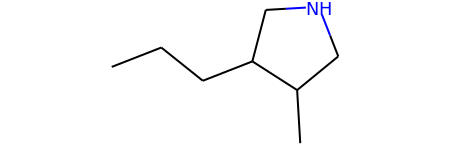

In [44]:
a = Chem.MolFromSmiles('CC1CN([H])CC1CCC')
a

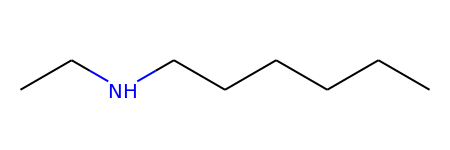

In [45]:
b = Chem.MolFromSmiles('CCN([H])CCCCCC')
b

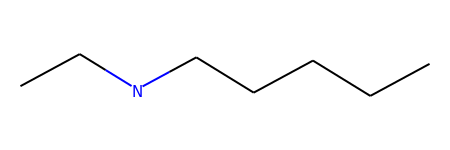

In [46]:
Chem.MolFromSmarts(LigandExpo.calc_mcs(a, b, mcs_flags=['ba'])[0])

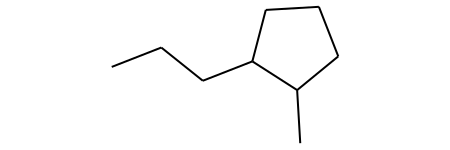

In [59]:
a